In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('./nnPUss/src/nnPUss')

from dataset import PUDatasetBase, BinaryTargetTransformer, PULabeler, SCAR_SS_Labeler, SCAR_CC_Labeler
from dataset_configs import DatasetConfig
from experiment_config import ExperimentConfig
from loss import nnPUccLoss, nnPUssLoss, uPUccLoss, uPUssLoss
from run_experiment import Experiment
from MPE import KM2_estimate

In [3]:
class SyntheticPUDataset(PUDatasetBase):

    N = None
    PI = None
    MEAN = None

    def __init__(
        self,
        root,
        pu_labeler: PULabeler = None,
        target_transformer: BinaryTargetTransformer = BinaryTargetTransformer(
            included_classes=[1, -1], positive_classes=[1]
        ),
        train = True,
        download=True,  # ignored
        random_seed=None,
    ) -> None:

        assert self.N is not None
        assert self.PI is not None
        assert self.MEAN is not None

        self.root = root
        self.train = train
        self.download = download
        self.random_seed = random_seed
        self.target_transformer = target_transformer
        self.pu_labeler = pu_labeler

        self.data = torch.cat(
            [
                torch.normal(0, 1, (int(self.PI * self.N), 10)),
                torch.normal(self.MEAN, 1, (int((1 - self.PI) * self.N), 10)),
            ]
        )
        self.targets = torch.cat(
            [
                torch.ones(int(self.PI * self.N)),
                -1 * torch.ones(int((1 - self.PI) * self.N)),
            ]
        )

        self._convert_to_pu_data()

In [4]:
def create_pu_dataset_class(N, PI, PI_NEW, MEAN):
    """
    Dynamically creates a PU dataset class with given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.

    Returns:
    - tuple: A tuple containing the two dynamically created classes (SyntheticPUDataset_1, SyntheticPUDataset_2).
    """
    # Define class attributes dynamically
    class_attrs_train = {
        'N': N,
        'PI': PI,
        'MEAN': MEAN
    }
    class_attrs_new = {
        'N': N,
        'PI': PI_NEW,
        'MEAN': MEAN
    }
    
    # Dynamically create the new class
    return (type('SyntheticPUDataset_1', (SyntheticPUDataset,), class_attrs_train), 
    type('SyntheticPUDataset_2', (SyntheticPUDataset,), class_attrs_new))

In [5]:
N = 1000
PI = 0.5
PI_NEW = 0.2
MEAN = 0
exp_number = 1  

SyntheticPUDataset_1, SyntheticPUDataset_2 = create_pu_dataset_class(N=N, PI=PI, PI_NEW=PI_NEW, MEAN=MEAN)

dataset_config = DatasetConfig(
    f"Synthetic3/{N}/{MEAN}/{PI}/{PI_NEW}",
    DatasetClass=SyntheticPUDataset_1,
    PULabelerClass=SCAR_CC_Labeler,
)

# Train the model on the first dataset
label_frequency = 0.5
PULoss = nnPUssLoss

experiment_config = ExperimentConfig(
    PULoss=PULoss,
    dataset_config=dataset_config,
    label_frequency=label_frequency,
    exp_number=exp_number,
)
# print(f"Starting: {experiment_config}...")

# experiment = Experiment(experiment_config)
# experiment.run()

# print(f"Finished: {experiment_config}")

# Test the model on the second dataset

data = SyntheticPUDataset_1(
    root = "data",
    train=True,
    pu_labeler=SCAR_CC_Labeler(label_frequency=0.5),
)

new_data = SyntheticPUDataset_2(
    root = "data",
    train=False,
    pu_labeler=SCAR_CC_Labeler(label_frequency=0),
)

In [6]:
new_data.binary_targets[new_data.binary_targets == 1].shape

# new_data.pu_targets[new_data.pu_targets == -1].shape

torch.Size([202])

In [7]:
def perform_synthetic_experiment(N, PI, PI_NEW, MEAN):
    """
    Perform a synthetic experiment with the given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.
    """
        
    for exp_number in range(0, 10):

        # Dynamically create the dataset classes
        SyntheticPUDataset_1, SyntheticPUDataset_2 = create_pu_dataset_class(N=N, PI=PI, PI_NEW=PI_NEW, MEAN=MEAN)

        dataset_config = DatasetConfig(
            f"Synthetic4/{N}/{MEAN}/{PI}/{PI_NEW}",
            DatasetClass=SyntheticPUDataset_1,
            PULabelerClass=SCAR_CC_Labeler,
        )

        # Train the model on the first dataset
        label_frequency = 0.5
        PULoss = nnPUssLoss

        experiment_config = ExperimentConfig(
            PULoss=PULoss,
            dataset_config=dataset_config,
            label_frequency=label_frequency,
            exp_number=exp_number,
        )
        print(f"Starting: {experiment_config}...")

        experiment = Experiment(experiment_config)
        experiment.run()

        print(f"Finished: {experiment_config}")

        # Test the model on the second dataset
        new_data = SyntheticPUDataset_2(
            root = "data",
            train=True,
            pu_labeler=SCAR_CC_Labeler(label_frequency=0),
        )
        experiment.test_on_new_data(new_data)
 
        print(experiment.new_data_metrics)

        # Estimate the proportion of positive samples in the new dataset
        # pos = new_data.data[new_data.pu_targets == 1].numpy()
        pos = experiment.train_set.data.clone()[experiment.train_set.pu_targets == 1].numpy()
        unl = new_data.data.clone().numpy()
        KM1, KM2 = KM2_estimate(pos, unl)
        print(f"Estimated prior: KM1={KM1}, KM2={KM2}")

        # Adjust the model's predictions using the estimated prior
        experiment.test_on_new_data_with_new_pi(new_data, pi=SyntheticPUDataset_1.PI, km1_pi=KM1, km2_pi=KM2, true_new_pi=SyntheticPUDataset_2.PI)


In [8]:
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = 1000
mean = 0.5

for pi in PI_LIST:
    if pi == 0.1:
        continue
    for pi_new in PI_LIST:
        perform_synthetic_experiment(n, pi, pi_new, mean)

Starting: Synthetic4/1000/0.5/0.2/0.1, c=0.5, exp 0; nnPUss...
Epoch: 1/50
3/3 [========] - 1s 348ms/step - loss: 0.4997 - acc: 0.4978 - test_loss: 0.5084 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 25ms/step - loss: 0.4969 - acc: 0.5211 - test_loss: 0.5101 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4941 - acc: 0.5292 - test_loss: 0.5114 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4911 - acc: 0.5397 - test_loss: 0.5122 - test_accuracy: 33.5664 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4884 - acc: 0.5641 - test_loss: 0.5126 - test_accuracy: 34.2657 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4855 - acc: 0.5737 - test_loss: 0.5125 - test_accuracy: 34.8651 - pos_fraction: 0.9391
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4833 - acc: 0.5833 - test_loss: 0.5120 - test_accu

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 27ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4778 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] -

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 33ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 34ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4270 - acc: 0.7314 - test_loss: 0.4545 - test_accuracy: 67.6324 - pos_fraction: 0.0769
Epoch: 15/50
3/3 [========] - 0s 32ms/step - loss: 0.4244 - acc: 0.7232 - test_loss: 0.4516 - test_accuracy: 67.8322 - pos_fraction: 0.1009
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4802 - acc: 0.5867 - test_loss: 0.4776 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4752 - acc: 0.6406

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4671 - acc: 0.5430

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4504 - acc: 0.6336 - test_loss: 0.4577 - test_accuracy: 66.6334 - pos_fraction: 0.0799
Epoch: 14/50
3/3 [========] - 0s 27

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4522 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4410 - acc: 0.7148

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 86ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 27ms/step - loss: 0.4270 - acc: 0.7314 - test_loss: 0.4545 - test_accuracy: 67.6324 - pos_fraction: 0.0769
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 75ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 87ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4504 - acc: 0.6336 - test_loss: 0.4577 - test_accuracy: 66.6334 - pos_fraction: 0.0799
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4481 - acc: 0.6602

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4401 - acc: 0.6895

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4270 - acc: 0.7314 - test_loss: 0.4545 - test_accuracy: 67.6324 - pos_fraction: 0.0769
Epoch: 15/50
3/3 [========] - 0s 24ms/step - loss: 0.4244 - acc: 0.7232 - test_loss: 0.4516 - test_accuracy: 67.8322 - pos_fraction: 0.1009
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4752 - acc: 0.6406

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 72ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4731 - acc: 0.6276 - test_loss: 0.4710 - test_accuracy: 66.3337 - pos_fraction: 0.0909
Epoch: 11/50
3/3 [========] - 0s 21ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4731 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4522 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4410 - acc: 0.7148

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4270 - acc: 0.7314 - test_loss: 0.4545 - test_accuracy: 67.6324 - pos_fraction: 0.0769
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4731 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 59ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4437 - acc: 0.6797

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4969 - acc: 0.5211 - test_loss: 0.5101 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4941 - acc: 0.5292 - test_loss: 0.5114 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4911 - acc: 0.5397 - test_loss: 0.5122 - test_accuracy: 33.5664 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4884 - acc: 0.5641 - test_loss: 0.5126 - test_accuracy: 34.2657 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4855 - acc: 0.5737 - test_loss: 0.5125 - test_accuracy: 34.8651 - pos_fraction: 0.9391
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4833 - acc: 0.5833 - test_loss: 0.5120 - test_accuracy: 36.6633 - pos_fraction: 0.8891
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4803 - acc: 0.6019 - test_loss: 0.5111 - test_accuracy: 40.6593 - pos_fraction: 0.8292
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5248 - acc: 0.4747 - test_loss: 0.5001 - test_accuracy: 51.5485 - pos_fraction: 0.6374
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.5229 - acc: 0.4924 - test_loss: 0.5015 - test_accuracy: 45.4545 - pos_fraction: 0.7443
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5198 - acc: 0.5086 - test_loss: 0.5026 - test_accuracy: 45.2547 - pos_fraction: 0.7622
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5168 - acc: 0.5146 - test_loss: 0.5034 - test_accuracy: 45.1548 - pos_fraction: 0.7552
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5144 - acc: 0.5413 - test_loss: 0.5040 - test_accuracy: 46.4535 - pos_fraction: 0.7463
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5116 - acc: 0.5395 - test_loss: 0.5044 - test_accuracy: 48.5514 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5093 - acc: 0.5608 - test_loss: 0.5047 - test_accuracy: 48.9510 - pos_fraction: 0.7153
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4731 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4437 - acc: 0.6797

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4969 - acc: 0.5211 - test_loss: 0.5101 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4941 - acc: 0.5292 - test_loss: 0.5114 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4911 - acc: 0.5397 - test_loss: 0.5122 - test_accuracy: 33.5664 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4884 - acc: 0.5641 - test_loss: 0.5126 - test_accuracy: 34.2657 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4855 - acc: 0.5737 - test_loss: 0.5125 - test_accuracy: 34.8651 - pos_fraction: 0.9391
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4833 - acc: 0.5833 - test_loss: 0.5120 - test_accuracy: 36.6633 - pos_fraction: 0.8891
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4803 - acc: 0.6019 - test_loss: 0.5111 - test_accuracy: 40.6593 - pos_fraction: 0.8292
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4968 - acc: 0.5207 - test_loss: 0.4984 - test_accuracy: 50.2498 - pos_fraction: 0.3457
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4938 - acc: 0.5422 - test_loss: 0.5015 - test_accuracy: 43.0569 - pos_fraction: 0.6773
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4915 - acc: 0.5610 - test_loss: 0.5037 - test_accuracy: 41.7582 - pos_fraction: 0.7722
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4889 - acc: 0.5690 - test_loss: 0.5050 - test_accuracy: 42.2577 - pos_fraction: 0.7752
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4863 - acc: 0.5771 - test_loss: 0.5055 - test_accuracy: 43.8561 - pos_fraction: 0.7512
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4838 - acc: 0.6090 - test_loss: 0.5050 - test_accuracy: 46.3536 - pos_fraction: 0.7083
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4809 - acc: 0.6174 - test_loss: 0.5037 - test_accuracy: 49.7502 - pos_fraction: 0.6703
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5251 - acc: 0.4736 - test_loss: 0.4961 - test_accuracy: 64.9351 - pos_fraction: 0.0959
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5230 - acc: 0.4855 - test_loss: 0.4974 - test_accuracy: 64.4356 - pos_fraction: 0.2987
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5203 - acc: 0.5052 - test_loss: 0.4985 - test_accuracy: 59.6404 - pos_fraction: 0.4665
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5175 - acc: 0.5196 - test_loss: 0.4994 - test_accuracy: 59.1409 - pos_fraction: 0.5694
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5151 - acc: 0.5359 - test_loss: 0.5002 - test_accuracy: 58.3417 - pos_fraction: 0.6394
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5124 - acc: 0.5553 - test_loss: 0.5008 - test_accuracy: 56.1439 - pos_fraction: 0.6673
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5098 - acc: 0.5668 - test_loss: 0.5014 - test_accuracy: 56.8432 - pos_fraction: 0.6723
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 33ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5248 - acc: 0.4747 - test_loss: 0.5001 - test_accuracy: 51.5485 - pos_fraction: 0.6374
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5229 - acc: 0.4924 - test_loss: 0.5015 - test_accuracy: 45.4545 - pos_fraction: 0.7443
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.5198 - acc: 0.5086 - test_loss: 0.5026 - test_accuracy: 45.2547 - pos_fraction: 0.7622
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5168 - acc: 0.5146 - test_loss: 0.5034 - test_accuracy: 45.1548 - pos_fraction: 0.7552
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5144 - acc: 0.5413 - test_loss: 0.5040 - test_accuracy: 46.4535 - pos_fraction: 0.7463
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5116 - acc: 0.5395 - test_loss: 0.5044 - test_accuracy: 48.5514 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5093 - acc: 0.5608 - test_loss: 0.5047 - test_accuracy: 48.9510 - pos_fraction: 0.7153
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 53ms/step - loss: 0.4827 - acc: 0.4821 - test_loss: 0.4861 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4804 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 54ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4731 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 51ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4481 - acc: 0.6602

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4410 - acc: 0.7148

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4270 - acc: 0.7314 - test_loss: 0.4545 - test_accuracy: 67.6324 - pos_fraction: 0.0769
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4969 - acc: 0.5211 - test_loss: 0.5101 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4941 - acc: 0.5292 - test_loss: 0.5114 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4911 - acc: 0.5397 - test_loss: 0.5122 - test_accuracy: 33.5664 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4884 - acc: 0.5641 - test_loss: 0.5126 - test_accuracy: 34.2657 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4855 - acc: 0.5737 - test_loss: 0.5125 - test_accuracy: 34.8651 - pos_fraction: 0.9391
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4833 - acc: 0.5833 - test_loss: 0.5120 - test_accuracy: 36.6633 - pos_fraction: 0.8891
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4803 - acc: 0.6019 - test_loss: 0.5111 - test_accuracy: 40.6593 - pos_fraction: 0.8292
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 44ms/step - loss: 0.4968 - acc: 0.5207 - test_loss: 0.4984 - test_accuracy: 50.2498 - pos_fraction: 0.3457
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4938 - acc: 0.5422 - test_loss: 0.5015 - test_accuracy: 43.0569 - pos_fraction: 0.6773
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4915 - acc: 0.5610 - test_loss: 0.5037 - test_accuracy: 41.7582 - pos_fraction: 0.7722
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4889 - acc: 0.5690 - test_loss: 0.5050 - test_accuracy: 42.2577 - pos_fraction: 0.7752
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4863 - acc: 0.5771 - test_loss: 0.5055 - test_accuracy: 43.8561 - pos_fraction: 0.7512
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4838 - acc: 0.6090 - test_loss: 0.5050 - test_accuracy: 46.3536 - pos_fraction: 0.7083
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4809 - acc: 0.6174 - test_loss: 0.5037 - test_accuracy: 49.7502 - pos_fraction: 0.6703
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.5251 - acc: 0.4736 - test_loss: 0.4961 - test_accuracy: 64.9351 - pos_fraction: 0.0959
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5230 - acc: 0.4855 - test_loss: 0.4974 - test_accuracy: 64.4356 - pos_fraction: 0.2987
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5203 - acc: 0.5052 - test_loss: 0.4985 - test_accuracy: 59.6404 - pos_fraction: 0.4665
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5175 - acc: 0.5196 - test_loss: 0.4994 - test_accuracy: 59.1409 - pos_fraction: 0.5694
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5151 - acc: 0.5359 - test_loss: 0.5002 - test_accuracy: 58.3417 - pos_fraction: 0.6394
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5124 - acc: 0.5553 - test_loss: 0.5008 - test_accuracy: 56.1439 - pos_fraction: 0.6673
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5098 - acc: 0.5668 - test_loss: 0.5014 - test_accuracy: 56.8432 - pos_fraction: 0.6723
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4802 - acc: 0.5867 - test_loss: 0.4776 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4779 - acc: 0.6250

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 41ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 25m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5248 - acc: 0.4747 - test_loss: 0.5001 - test_accuracy: 51.5485 - pos_fraction: 0.6374
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5229 - acc: 0.4924 - test_loss: 0.5015 - test_accuracy: 45.4545 - pos_fraction: 0.7443
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5198 - acc: 0.5086 - test_loss: 0.5026 - test_accuracy: 45.2547 - pos_fraction: 0.7622
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5168 - acc: 0.5146 - test_loss: 0.5034 - test_accuracy: 45.1548 - pos_fraction: 0.7552
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5144 - acc: 0.5413 - test_loss: 0.5040 - test_accuracy: 46.4535 - pos_fraction: 0.7463
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5116 - acc: 0.5395 - test_loss: 0.5044 - test_accuracy: 48.5514 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5093 - acc: 0.5608 - test_loss: 0.5047 - test_accuracy: 48.9510 - pos_fraction: 0.7153
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4731 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4535 - acc: 0.6347 - test_loss: 0.4596 - test_accuracy: 66.3337 - pos_fraction: 0.0629
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [=

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4969 - acc: 0.5211 - test_loss: 0.5101 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4941 - acc: 0.5292 - test_loss: 0.5114 - test_accuracy: 33.9660 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4911 - acc: 0.5397 - test_loss: 0.5122 - test_accuracy: 33.5664 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4884 - acc: 0.5641 - test_loss: 0.5126 - test_accuracy: 34.2657 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4855 - acc: 0.5737 - test_loss: 0.5125 - test_accuracy: 34.8651 - pos_fraction: 0.9391
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4833 - acc: 0.5833 - test_loss: 0.5120 - test_accuracy: 36.6633 - pos_fraction: 0.8891
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4803 - acc: 0.6019 - test_loss: 0.5111 - test_accuracy: 40.6593 - pos_fraction: 0.8292
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4968 - acc: 0.5207 - test_loss: 0.4984 - test_accuracy: 50.2498 - pos_fraction: 0.3457
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4938 - acc: 0.5422 - test_loss: 0.5015 - test_accuracy: 43.0569 - pos_fraction: 0.6773
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4915 - acc: 0.5610 - test_loss: 0.5037 - test_accuracy: 41.7582 - pos_fraction: 0.7722
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4889 - acc: 0.5690 - test_loss: 0.5050 - test_accuracy: 42.2577 - pos_fraction: 0.7752
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4863 - acc: 0.5771 - test_loss: 0.5055 - test_accuracy: 43.8561 - pos_fraction: 0.7512
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4838 - acc: 0.6090 - test_loss: 0.5050 - test_accuracy: 46.3536 - pos_fraction: 0.7083
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4809 - acc: 0.6174 - test_loss: 0.5037 - test_accuracy: 49.7502 - pos_fraction: 0.6703
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5230 - acc: 0.4855 - test_loss: 0.4974 - test_accuracy: 64.4356 - pos_fraction: 0.2987
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5203 - acc: 0.5052 - test_loss: 0.4985 - test_accuracy: 59.6404 - pos_fraction: 0.4665
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5175 - acc: 0.5196 - test_loss: 0.4994 - test_accuracy: 59.1409 - pos_fraction: 0.5694
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.5151 - acc: 0.5359 - test_loss: 0.5002 - test_accuracy: 58.3417 - pos_fraction: 0.6394
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.5124 - acc: 0.5553 - test_loss: 0.5008 - test_accuracy: 56.1439 - pos_fraction: 0.6673
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5098 - acc: 0.5668 - test_loss: 0.5014 - test_accuracy: 56.8432 - pos_fraction: 0.6723
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.5064 - acc: 0.5823 - test_loss: 0.5019 - test_accuracy: 56.5435 - pos_fraction: 0.6753
Epoch: 10/50
3/3 [========] - 0s 22ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4777 - acc: 0.6245 - test_loss: 0.4738 - test_accuracy: 66.4336 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4750 - acc: 0.6346 - test_loss: 0.4704 - test_accuracy: 66.6334 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4725 - acc: 0.6506 - test_loss: 0.4673 - test_accuracy: 66.7333 - pos_fraction: 0.0030


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4696 - acc: 0.6725 - test_loss: 0.4645 - test_accuracy: 66.7333 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4669 - acc: 0.6823 - test_loss: 0.4620 - test_accuracy: 67.2328 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4648 - acc: 0.7005 - test_loss: 0.4597 - test_accuracy: 68.3317 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4627 - acc: 0.7077 - test_loss: 0.4577 - test_accuracy: 68.9311 - pos_fraction: 0.0649
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4604 - acc: 0.7201 - test_loss: 0.4559 - test_accuracy: 71.1289 - pos_fraction: 0.0989
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4575 - acc: 0.7298 - test_loss: 0.4543 - test_accuracy: 71.6284 - pos_fraction: 0.1279
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4548 - acc: 0.7252 - test_loss: 0.4527 - test_accuracy: 72.3277 - pos_fraction: 0.1568
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4906 - acc: 0.4955 - test_loss: 0.4868 - test_accuracy: 67.1329 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4880 - acc: 0.5225 - test_loss: 0.4839 - test_accuracy: 66.7333 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4857 - acc: 0.5432 - test_loss: 0.4811 - test_accuracy: 66.6334 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4833 - acc: 0.5576 - test_loss: 0.4786 - test_accuracy: 66.5335 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4805 - acc: 0.5625 - test_loss: 0.4763 - test_accuracy: 66.3337 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4783 - acc: 0.5813 - test_loss: 0.4743 - test_accuracy: 65.4346 - pos_fraction: 0.0340
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4758 - acc: 0.6006 - test_loss: 0.4725 - test_accuracy: 65.0350 - pos_fraction: 0.0579
Epoch: 10/50
3/3 [========] - 0s 29ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5248 - acc: 0.4747 - test_loss: 0.5001 - test_accuracy: 51.5485 - pos_fraction: 0.6374
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5229 - acc: 0.4924 - test_loss: 0.5015 - test_accuracy: 45.4545 - pos_fraction: 0.7443
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5198 - acc: 0.5086 - test_loss: 0.5026 - test_accuracy: 45.2547 - pos_fraction: 0.7622
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5168 - acc: 0.5146 - test_loss: 0.5034 - test_accuracy: 45.1548 - pos_fraction: 0.7552
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5144 - acc: 0.5413 - test_loss: 0.5040 - test_accuracy: 46.4535 - pos_fraction: 0.7463
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5116 - acc: 0.5395 - test_loss: 0.5044 - test_accuracy: 48.5514 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5093 - acc: 0.5608 - test_loss: 0.5047 - test_accuracy: 48.9510 - pos_fraction: 0.7153
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4799 - acc: 0.4942 - test_loss: 0.4821 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4772 - acc: 0.4995 - test_loss: 0.4785 - test_accuracy: 66.0340 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4778 - acc: 0.5312

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4739 - acc: 0.5212 - test_loss: 0.4751 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 39ms/step - loss: 0.4714 - acc: 0.5315 - test_loss: 0.4721 - test_accuracy: 65.9341 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4683 - acc: 0.5496 - test_loss: 0.4693 - test_accuracy: 66.6334 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4653 - acc: 0.5680 - test_loss: 0.4670 - test_accuracy: 66.0340 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4620 - acc: 0.5834 - test_loss: 0.4649 - test_accuracy: 66.0340 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4591 - acc: 0.6105 - test_loss: 0.4631 - test_accuracy: 65.6344 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4564 - acc: 0.6282 - test_loss: 0.4613 - test_accuracy: 65.0350 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] -

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4543 - acc: 0.6303 - test_loss: 0.4860 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.4521 - acc: 0.6462 - test_loss: 0.4826 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4522 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4493 - acc: 0.6525 - test_loss: 0.4794 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 44ms/step - loss: 0.4467 - acc: 0.6603 - test_loss: 0.4765 - test_accuracy: 65.9341 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4437 - acc: 0.6797

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4443 - acc: 0.6711 - test_loss: 0.4738 - test_accuracy: 65.8342 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4414 - acc: 0.6856 - test_loss: 0.4712 - test_accuracy: 65.7343 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4391 - acc: 0.6975 - test_loss: 0.4686 - test_accuracy: 65.6344 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4365 - acc: 0.6995 - test_loss: 0.4659 - test_accuracy: 66.7333 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.4334 - acc: 0.7144 - test_loss: 0.4631 - test_accuracy: 66.3337 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4318 - acc: 0.7141 - test_loss: 0.4603 - test_accuracy: 67.4326 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 32ms/step - loss: 0.4299 - acc: 0.7177 - test_loss: 0.4574 - test_accuracy: 66.9331 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 48ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4790 - acc: 0.6136 - test_loss: 0.4804 - test_accuracy: 54.9451 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4776 - acc: 0.6223 - test_loss: 0.4795 - test_accuracy: 55.6444 - pos_fraction: 0.0979
Epoch: 12/50
3/3 [========] - 0s 24ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4579 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 35ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 32

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] - 0s 35ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 34ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4752 - acc: 0.5117

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 34ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4657 - acc: 0.5566

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 51ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4579 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 33ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4628 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4488 - acc: 0.6264 - test_loss: 0.4689 - test_accuracy: 59.4406 - pos_fraction: 0.1059
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4560 - acc: 0.5957

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4558 - acc: 0.6289

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4427 - acc: 0.6313 - test_loss: 0.4652 - test_accuracy: 57.8422 - pos_fraction: 0.0789
Epoch: 15/50
3/3 [========] - 0s 18ms/step - loss: 0.4412 - acc: 0.6475 - test_loss: 0.4623 - test_accuracy: 58.2418 - pos_fraction: 0.0929
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 55ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 22ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4657 - acc: 0.5566

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 44ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4579 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 26

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 40ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 31ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 75ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4657 - acc: 0.5566

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4427 - acc: 0.6313 - test_loss: 0.4652 - test_accuracy: 57.8422 - pos_fraction: 0.0789
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 36ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4816 - acc: 0.5993 - test_loss: 0.4815 - test_accuracy: 54.0460 - pos_fraction: 0.0639
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5125 - acc: 0.5431 - test_loss: 0.4999 - test_accuracy: 51.3487 - pos_fraction: 0.6873
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5095 - acc: 0.5418 - test_loss: 0.5009 - test_accuracy: 52.7473 - pos_fraction: 0.8012
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5064 - acc: 0.5525 - test_loss: 0.5016 - test_accuracy: 52.1479 - pos_fraction: 0.8212
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5034 - acc: 0.5757 - test_loss: 0.5020 - test_accuracy: 52.2478 - pos_fraction: 0.8062
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5002 - acc: 0.5815 - test_loss: 0.5022 - test_accuracy: 53.1469 - pos_fraction: 0.7932
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4968 - acc: 0.6059 - test_loss: 0.5021 - test_accuracy: 56.9431 - pos_fraction: 0.7632
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4938 - acc: 0.6001 - test_loss: 0.5017 - test_accuracy: 57.3427 - pos_fraction: 0.7532
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4752 - acc: 0.5117

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 23ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4560 - acc: 0.5957

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4558 - acc: 0.6289

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 43ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4427 - acc: 0.6313 - test_loss: 0.4652 - test_accuracy: 57.8422 - pos_fraction: 0.0789
Epoch: 15/50
3/3 [========] - 0s 24ms/step - loss: 0.4412 - acc: 0.6475 - test_loss: 0.4623 - test_accuracy: 58.2418 - pos_fraction: 0.0929
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4974 - acc: 0.5253 - test_loss: 0.4984 - test_accuracy: 45.4545 - pos_fraction: 0.3007
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4950 - acc: 0.5352 - test_loss: 0.5004 - test_accuracy: 49.3506 - pos_fraction: 0.6094
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4926 - acc: 0.5462 - test_loss: 0.5018 - test_accuracy: 50.9491 - pos_fraction: 0.7333
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4900 - acc: 0.5702 - test_loss: 0.5025 - test_accuracy: 51.9481 - pos_fraction: 0.7512
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4868 - acc: 0.5748 - test_loss: 0.5024 - test_accuracy: 52.1479 - pos_fraction: 0.7373
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4849 - acc: 0.5782 - test_loss: 0.5016 - test_accuracy: 53.8462 - pos_fraction: 0.6823
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4821 - acc: 0.5879 - test_loss: 0.5001 - test_accuracy: 55.4446 - pos_fraction: 0.6324
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5115 - acc: 0.5530 - test_loss: 0.4971 - test_accuracy: 53.7463 - pos_fraction: 0.0889
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5083 - acc: 0.5787 - test_loss: 0.4978 - test_accuracy: 55.0450 - pos_fraction: 0.2777
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5056 - acc: 0.5897 - test_loss: 0.4984 - test_accuracy: 59.3407 - pos_fraction: 0.4386
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5030 - acc: 0.5926 - test_loss: 0.4988 - test_accuracy: 62.3377 - pos_fraction: 0.5564
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5001 - acc: 0.6007 - test_loss: 0.4991 - test_accuracy: 61.4386 - pos_fraction: 0.6234
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4981 - acc: 0.6130 - test_loss: 0.4991 - test_accuracy: 60.9391 - pos_fraction: 0.6424
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4947 - acc: 0.6266 - test_loss: 0.4990 - test_accuracy: 61.7383 - pos_fraction: 0.6543
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4841 - acc: 0.5588 - test_loss: 0.4909 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 56ms/step - loss: 0.4819 - acc: 0.5794 - test_loss: 0.4877 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.5586

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 84ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 53ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] -

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4975 - acc: 0.4776 - test_loss: 0.4931 - test_accuracy: 52.8472 - pos_fraction: 0.0040
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 43ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5125 - acc: 0.5431 - test_loss: 0.4999 - test_accuracy: 51.3487 - pos_fraction: 0.6873
Epoch: 3/50
3/3 [========] - 0s 48ms/step - loss: 0.5095 - acc: 0.5418 - test_loss: 0.5009 - test_accuracy: 52.7473 - pos_fraction: 0.8012
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5064 - acc: 0.5525 - test_loss: 0.5016 - test_accuracy: 52.1479 - pos_fraction: 0.8212
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5034 - acc: 0.5757 - test_loss: 0.5020 - test_accuracy: 52.2478 - pos_fraction: 0.8062
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5002 - acc: 0.5815 - test_loss: 0.5022 - test_accuracy: 53.1469 - pos_fraction: 0.7932
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4968 - acc: 0.6059 - test_loss: 0.5021 - test_accuracy: 56.9431 - pos_fraction: 0.7632
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4938 - acc: 0.6001 - test_loss: 0.5017 - test_accuracy: 57.3427 - pos_fraction: 0.7532
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 52ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4752 - acc: 0.5117

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 59ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 24ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4657 - acc: 0.5566

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 42ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4579 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 62ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 36ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 35ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 27

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 67ms/step - loss: 0.4974 - acc: 0.5253 - test_loss: 0.4984 - test_accuracy: 45.4545 - pos_fraction: 0.3007
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4950 - acc: 0.5352 - test_loss: 0.5004 - test_accuracy: 49.3506 - pos_fraction: 0.6094
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4926 - acc: 0.5462 - test_loss: 0.5018 - test_accuracy: 50.9491 - pos_fraction: 0.7333
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4900 - acc: 0.5702 - test_loss: 0.5025 - test_accuracy: 51.9481 - pos_fraction: 0.7512
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4868 - acc: 0.5748 - test_loss: 0.5024 - test_accuracy: 52.1479 - pos_fraction: 0.7373
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4849 - acc: 0.5782 - test_loss: 0.5016 - test_accuracy: 53.8462 - pos_fraction: 0.6823
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4821 - acc: 0.5879 - test_loss: 0.5001 - test_accuracy: 55.4446 - pos_fraction: 0.6324
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 44ms/step - loss: 0.5115 - acc: 0.5530 - test_loss: 0.4971 - test_accuracy: 53.7463 - pos_fraction: 0.0889
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5083 - acc: 0.5787 - test_loss: 0.4978 - test_accuracy: 55.0450 - pos_fraction: 0.2777
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5056 - acc: 0.5897 - test_loss: 0.4984 - test_accuracy: 59.3407 - pos_fraction: 0.4386
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5030 - acc: 0.5926 - test_loss: 0.4988 - test_accuracy: 62.3377 - pos_fraction: 0.5564
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5001 - acc: 0.6007 - test_loss: 0.4991 - test_accuracy: 61.4386 - pos_fraction: 0.6234
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4981 - acc: 0.6130 - test_loss: 0.4991 - test_accuracy: 60.9391 - pos_fraction: 0.6424
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4947 - acc: 0.6266 - test_loss: 0.4990 - test_accuracy: 61.7383 - pos_fraction: 0.6543
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4841 - acc: 0.5588 - test_loss: 0.4909 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.4819 - acc: 0.5794 - test_loss: 0.4877 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 58ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4975 - acc: 0.4776 - test_loss: 0.4931 - test_accuracy: 52.8472 - pos_fraction: 0.0040
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5125 - acc: 0.5431 - test_loss: 0.4999 - test_accuracy: 51.3487 - pos_fraction: 0.6873
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5095 - acc: 0.5418 - test_loss: 0.5009 - test_accuracy: 52.7473 - pos_fraction: 0.8012
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5064 - acc: 0.5525 - test_loss: 0.5016 - test_accuracy: 52.1479 - pos_fraction: 0.8212
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5034 - acc: 0.5757 - test_loss: 0.5020 - test_accuracy: 52.2478 - pos_fraction: 0.8062
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5002 - acc: 0.5815 - test_loss: 0.5022 - test_accuracy: 53.1469 - pos_fraction: 0.7932
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4968 - acc: 0.6059 - test_loss: 0.5021 - test_accuracy: 56.9431 - pos_fraction: 0.7632
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4938 - acc: 0.6001 - test_loss: 0.5017 - test_accuracy: 57.3427 - pos_fraction: 0.7532
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4760 - acc: 0.5633 - test_loss: 0.4975 - test_accuracy: 57.9421 - pos_fraction: 0.1598
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4727 - acc: 0.5742 - test_loss: 0.4955 - test_accuracy: 58.8412 - pos_fraction: 0.0809
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4691 - acc: 0.5798 - test_loss: 0.4935 - test_accuracy: 58.4416 - pos_fraction: 0.0729
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4657 - acc: 0.6018 - test_loss: 0.4913 - test_accuracy: 59.4406 - pos_fraction: 0.0889
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4635 - acc: 0.6136 - test_loss: 0.4891 - test_accuracy: 60.2398 - pos_fraction: 0.1069
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4602 - acc: 0.6193 - test_loss: 0.4868 - test_accuracy: 61.0390 - pos_fraction: 0.1249
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4573 - acc: 0.6288 - test_loss: 0.4843 - test_accuracy: 62.5375 - pos_fraction: 0.1499
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.4863 - acc: 0.4964 - test_loss: 0.4908 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4766 - acc: 0.5410

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 52ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4724 - acc: 0.5332

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4702 - acc: 0.5275 - test_loss: 0.4931 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.4954 - acc: 0.5115 - test_loss: 0.5066 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4923 - acc: 0.5212 - test_loss: 0.5075 - test_accuracy: 46.2537 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4886 - acc: 0.5430 - test_loss: 0.5080 - test_accuracy: 45.7542 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4859 - acc: 0.5659 - test_loss: 0.5081 - test_accuracy: 45.7542 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4831 - acc: 0.5914 - test_loss: 0.5079 - test_accuracy: 46.4535 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.4804 - acc: 0.6094 - test_loss: 0.5073 - test_accuracy: 47.6523 - pos_fraction: 0.9401
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4772 - acc: 0.6310 - test_loss: 0.5064 - test_accuracy: 49.9500 - pos_fraction: 0.8911
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4974 - acc: 0.5253 - test_loss: 0.4984 - test_accuracy: 45.4545 - pos_fraction: 0.3007
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4950 - acc: 0.5352 - test_loss: 0.5004 - test_accuracy: 49.3506 - pos_fraction: 0.6094
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4926 - acc: 0.5462 - test_loss: 0.5018 - test_accuracy: 50.9491 - pos_fraction: 0.7333
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4900 - acc: 0.5702 - test_loss: 0.5025 - test_accuracy: 51.9481 - pos_fraction: 0.7512
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4868 - acc: 0.5748 - test_loss: 0.5024 - test_accuracy: 52.1479 - pos_fraction: 0.7373
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4849 - acc: 0.5782 - test_loss: 0.5016 - test_accuracy: 53.8462 - pos_fraction: 0.6823
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4821 - acc: 0.5879 - test_loss: 0.5001 - test_accuracy: 55.4446 - pos_fraction: 0.6324
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5115 - acc: 0.5530 - test_loss: 0.4971 - test_accuracy: 53.7463 - pos_fraction: 0.0889
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.5083 - acc: 0.5787 - test_loss: 0.4978 - test_accuracy: 55.0450 - pos_fraction: 0.2777
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.5056 - acc: 0.5897 - test_loss: 0.4984 - test_accuracy: 59.3407 - pos_fraction: 0.4386
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5030 - acc: 0.5926 - test_loss: 0.4988 - test_accuracy: 62.3377 - pos_fraction: 0.5564
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5001 - acc: 0.6007 - test_loss: 0.4991 - test_accuracy: 61.4386 - pos_fraction: 0.6234
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4981 - acc: 0.6130 - test_loss: 0.4991 - test_accuracy: 60.9391 - pos_fraction: 0.6424
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4947 - acc: 0.6266 - test_loss: 0.4990 - test_accuracy: 61.7383 - pos_fraction: 0.6543
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4841 - acc: 0.5588 - test_loss: 0.4909 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4819 - acc: 0.5794 - test_loss: 0.4877 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4793 - acc: 0.5794 - test_loss: 0.4848 - test_accuracy: 53.0470 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 53ms/step - loss: 0.4765 - acc: 0.5973 - test_loss: 0.4822 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4732 - acc: 0.6140 - test_loss: 0.4797 - test_accuracy: 53.1469 - pos_fraction: 9.9900e-04
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4708 - acc: 0.6143 - test_loss: 0.4775 - test_accuracy: 53.7463 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4684 - acc: 0.6253 - test_loss: 0.4753 - test_accuracy: 54.2458 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4651 - acc: 0.6457 - test_loss: 0.4733 - test_accuracy: 55.7443 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4632 - acc: 0.6570 - test_loss: 0.4714 - test_accuracy: 56.7433 - pos_fraction: 0.0749
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4609 - acc: 0.6591 - test_loss: 0.4695 - test_accuracy: 57.4426 - pos_fraction: 0.0939
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4577 - acc: 0.6671 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1199
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4975 - acc: 0.4776 - test_loss: 0.4931 - test_accuracy: 52.8472 - pos_fraction: 0.0040
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4950 - acc: 0.5032 - test_loss: 0.4911 - test_accuracy: 52.6474 - pos_fraction: 0.0060
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4926 - acc: 0.5106 - test_loss: 0.4892 - test_accuracy: 52.5475 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4901 - acc: 0.5420 - test_loss: 0.4874 - test_accuracy: 52.1479 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4882 - acc: 0.5593 - test_loss: 0.4857 - test_accuracy: 52.9471 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4859 - acc: 0.5680 - test_loss: 0.4842 - test_accuracy: 53.1469 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4835 - acc: 0.5874 - test_loss: 0.4828 - test_accuracy: 53.0470 - pos_fraction: 0.0400
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5125 - acc: 0.5431 - test_loss: 0.4999 - test_accuracy: 51.3487 - pos_fraction: 0.6873
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5095 - acc: 0.5418 - test_loss: 0.5009 - test_accuracy: 52.7473 - pos_fraction: 0.8012
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5064 - acc: 0.5525 - test_loss: 0.5016 - test_accuracy: 52.1479 - pos_fraction: 0.8212
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5034 - acc: 0.5757 - test_loss: 0.5020 - test_accuracy: 52.2478 - pos_fraction: 0.8062
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5002 - acc: 0.5815 - test_loss: 0.5022 - test_accuracy: 53.1469 - pos_fraction: 0.7932
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4968 - acc: 0.6059 - test_loss: 0.5021 - test_accuracy: 56.9431 - pos_fraction: 0.7632
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4938 - acc: 0.6001 - test_loss: 0.5017 - test_accuracy: 57.3427 - pos_fraction: 0.7532
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4760 - acc: 0.5633 - test_loss: 0.4975 - test_accuracy: 57.9421 - pos_fraction: 0.1598
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4727 - acc: 0.5742 - test_loss: 0.4955 - test_accuracy: 58.8412 - pos_fraction: 0.0809
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4691 - acc: 0.5798 - test_loss: 0.4935 - test_accuracy: 58.4416 - pos_fraction: 0.0729
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4657 - acc: 0.6018 - test_loss: 0.4913 - test_accuracy: 59.4406 - pos_fraction: 0.0889
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4635 - acc: 0.6136 - test_loss: 0.4891 - test_accuracy: 60.2398 - pos_fraction: 0.1069
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4602 - acc: 0.6193 - test_loss: 0.4868 - test_accuracy: 61.0390 - pos_fraction: 0.1249
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4573 - acc: 0.6288 - test_loss: 0.4843 - test_accuracy: 62.5375 - pos_fraction: 0.1499
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4863 - acc: 0.4964 - test_loss: 0.4908 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4825 - acc: 0.4976 - test_loss: 0.4883 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4766 - acc: 0.5410

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4791 - acc: 0.5200 - test_loss: 0.4860 - test_accuracy: 54.6454 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4754 - acc: 0.5370 - test_loss: 0.4839 - test_accuracy: 54.2458 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4722 - acc: 0.5560 - test_loss: 0.4819 - test_accuracy: 54.1459 - pos_fraction: 0.0050
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4628 - acc: 0.5840

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4692 - acc: 0.5568 - test_loss: 0.4801 - test_accuracy: 54.6454 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 42ms/step - loss: 0.4656 - acc: 0.5748 - test_loss: 0.4784 - test_accuracy: 54.7453 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4620 - acc: 0.5836 - test_loss: 0.4766 - test_accuracy: 56.0440 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4587 - acc: 0.5966 - test_loss: 0.4749 - test_accuracy: 56.7433 - pos_fraction: 0.0589
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4549 - acc: 0.6053 - test_loss: 0.4730 - test_accuracy: 57.7423 - pos_fraction: 0.0749
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4519 - acc: 0.6171 - test_loss: 0.4710 - test_accuracy: 58.2418 - pos_fraction: 0.0919
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4488 - acc: 0.6264 - test_loss: 0.4689 - test_accuracy: 59.4406 - pos_fraction: 0.1059
Epoch: 14/50
3/3 [========] - 0s 29

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4702 - acc: 0.5275 - test_loss: 0.4931 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4682 - acc: 0.5447 - test_loss: 0.4907 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4653 - acc: 0.5566

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4657 - acc: 0.5442 - test_loss: 0.4884 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4637 - acc: 0.5493 - test_loss: 0.4863 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4560 - acc: 0.5957

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4607 - acc: 0.5647 - test_loss: 0.4843 - test_accuracy: 53.9461 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4592 - acc: 0.5824 - test_loss: 0.4823 - test_accuracy: 54.3457 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4563 - acc: 0.5968 - test_loss: 0.4802 - test_accuracy: 54.8452 - pos_fraction: 0.0090


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4545 - acc: 0.5967 - test_loss: 0.4780 - test_accuracy: 54.7453 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4518 - acc: 0.6120 - test_loss: 0.4758 - test_accuracy: 55.6444 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4500 - acc: 0.6128 - test_loss: 0.4734 - test_accuracy: 56.1439 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4472 - acc: 0.6290 - test_loss: 0.4708 - test_accuracy: 56.4436 - pos_fraction: 0.0549
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.4453 - acc: 0.6285 - test_loss: 0.4680 - test_accuracy: 56.7433 - pos_fraction: 0.0639
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4427 - acc: 0.6313 - test_loss: 0.4652 - test_accuracy: 57.8422 - pos_fraction: 0.0789
Epoch: 15/50
3/3 [========] - 0s 34ms/step - loss: 0.4412 - acc: 0.6475 - test_loss: 0.4623 - test_accuracy: 58.2418 - pos_fraction: 0.0929
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4979 - acc: 0.4982 - test_loss: 0.5024 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4942 - acc: 0.5182 - test_loss: 0.5029 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4910 - acc: 0.5317 - test_loss: 0.5031 - test_accuracy: 56.7433 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4873 - acc: 0.5384 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4845 - acc: 0.5513 - test_loss: 0.5029 - test_accuracy: 57.2428 - pos_fraction: 0.9560
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4818 - acc: 0.5646 - test_loss: 0.5024 - test_accuracy: 57.8422 - pos_fraction: 0.9001
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4786 - acc: 0.5828 - test_loss: 0.5015 - test_accuracy: 57.6424 - pos_fraction: 0.8501
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4963 - acc: 0.6147 - test_loss: 0.4976 - test_accuracy: 47.4525 - pos_fraction: 0.0959
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4927 - acc: 0.6286 - test_loss: 0.4978 - test_accuracy: 53.8462 - pos_fraction: 0.3217
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4892 - acc: 0.6425 - test_loss: 0.4979 - test_accuracy: 56.6434 - pos_fraction: 0.4755
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4860 - acc: 0.6562 - test_loss: 0.4978 - test_accuracy: 61.6384 - pos_fraction: 0.5914
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4831 - acc: 0.6736 - test_loss: 0.4975 - test_accuracy: 63.2368 - pos_fraction: 0.6494
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4802 - acc: 0.6793 - test_loss: 0.4970 - test_accuracy: 64.7353 - pos_fraction: 0.6923
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4762 - acc: 0.6875 - test_loss: 0.4962 - test_accuracy: 66.2338 - pos_fraction: 0.7133
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 36ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4601 - acc: 0.6366 - test_loss: 0.4703 - test_accuracy: 55.9441 - pos_fraction: 0.1548
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 63ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 68ms/step - loss: 0.4986 - acc: 0.6046 - test_loss: 0.4990 - test_accuracy: 59.0410 - pos_fraction: 0.6563
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4954 - acc: 0.6151 - test_loss: 0.4994 - test_accuracy: 57.2428 - pos_fraction: 0.7502
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4929 - acc: 0.6346 - test_loss: 0.4995 - test_accuracy: 57.9421 - pos_fraction: 0.7752
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4895 - acc: 0.6332 - test_loss: 0.4995 - test_accuracy: 58.9411 - pos_fraction: 0.7692
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4871 - acc: 0.6317 - test_loss: 0.4992 - test_accuracy: 59.7403 - pos_fraction: 0.7572
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4840 - acc: 0.6392 - test_loss: 0.4987 - test_accuracy: 59.9401 - pos_fraction: 0.7532
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4807 - acc: 0.6503 - test_loss: 0.4979 - test_accuracy: 61.2388 - pos_fraction: 0.7463
Epoch: 9/50
3/3 [========] - 0s 33ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 81ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 28

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4789 - acc: 0.4609

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4979 - acc: 0.4982 - test_loss: 0.5024 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4942 - acc: 0.5182 - test_loss: 0.5029 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4910 - acc: 0.5317 - test_loss: 0.5031 - test_accuracy: 56.7433 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4873 - acc: 0.5384 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4845 - acc: 0.5513 - test_loss: 0.5029 - test_accuracy: 57.2428 - pos_fraction: 0.9560
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4818 - acc: 0.5646 - test_loss: 0.5024 - test_accuracy: 57.8422 - pos_fraction: 0.9001
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4786 - acc: 0.5828 - test_loss: 0.5015 - test_accuracy: 57.6424 - pos_fraction: 0.8501
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 45ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4601 - acc: 0.6366 - test_loss: 0.4703 - test_accuracy: 55.9441 - pos_fraction: 0.1548
Epoch: 14/50
3/3 [========] - 0s 36ms/step - loss: 0.4571 - acc: 0.6425 - test_loss: 0.4676 - test_accuracy: 58.6414 - pos_fraction: 0.1918
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 35ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4973 - acc: 0.4082

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4650 - acc: 0.5308 - test_loss: 0.4792 - test_accuracy: 48.0519 - pos_fraction: 0.1089
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0s 33ms/step - loss: 0.4562 - acc: 0.5468 - test_loss: 0.4745 - test_accuracy: 50.4496 - pos_fraction: 0.0879
Epoch: 15/50
3/3 [========] - 0s 30ms/step - loss: 0.4532 - acc: 0.5523 - test_loss: 0.4717 - test_accuracy: 51.2488 - pos_fraction: 0.1059
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 82ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 48ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4827 - acc: 0.5723

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 62ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 49ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 33m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 26ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 77ms/step - loss: 0.5007 - acc: 0.3753 - test_loss: 0.4947 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4972 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4920 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4650 - acc: 0.5308 - test_loss: 0.4792 - test_accuracy: 48.0519 - pos_fraction: 0.1089
Epoch: 15/50
3/3 [========] - 0s 30ms/step - loss: 0.4617 - acc: 0.5348 - test_loss: 0.4771 - test_accuracy: 49.5504 - pos_fraction: 0.1339
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4778 - acc: 0.5156

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 54ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4698 - acc: 0.4961

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 37ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4562 - acc: 0.5468 - test_loss: 0.4745 - test_accuracy: 50.4496 - pos_fraction: 0.0879
Epoch: 15/50
3/3 [========] - 0s 4

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 60ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4827 - acc: 0.5723

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4973 - acc: 0.4082

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 55ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 70ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 55ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 37ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 31

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 51ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4789 - acc: 0.4609

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 43ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 44ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 37ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 36ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 37ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 52ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4827 - acc: 0.5723

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 19m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4743 - acc: 0.5852 - test_loss: 0.4875 - test_accuracy: 44.7552 - pos_fraction: 0.0829
Epoch: 11/50
3/3 [========] - 0s 26ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 101ms/step - loss: 0.5007 - acc: 0.3753 - test_loss: 0.4947 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4972 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 52ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4920 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 43ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4846 - acc: 0.4648

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 47ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 36ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 32ms/step - loss: 0.4650 - acc: 0.5308 - test_loss: 0.4792 - test_accuracy: 48.0519 - pos_fraction: 0.1089
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 55ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 79ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 42ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 65ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 46ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 41ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 42ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4827 - acc: 0.5723

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 27m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 24ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 59ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 48ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4650 - acc: 0.5308 - test_loss: 0.4792 - test_accuracy: 48.0519 - pos_fraction: 0.1089
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.4927 - acc: 0.6286 - test_loss: 0.4978 - test_accuracy: 53.8462 - pos_fraction: 0.3217
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4892 - acc: 0.6425 - test_loss: 0.4979 - test_accuracy: 56.6434 - pos_fraction: 0.4755
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4860 - acc: 0.6562 - test_loss: 0.4978 - test_accuracy: 61.6384 - pos_fraction: 0.5914
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4831 - acc: 0.6736 - test_loss: 0.4975 - test_accuracy: 63.2368 - pos_fraction: 0.6494
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4802 - acc: 0.6793 - test_loss: 0.4970 - test_accuracy: 64.7353 - pos_fraction: 0.6923
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4762 - acc: 0.6875 - test_loss: 0.4962 - test_accuracy: 66.2338 - pos_fraction: 0.7133
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4734 - acc: 0.6974 - test_loss: 0.4951 - test_accuracy: 67.4326 - pos_fraction: 0.7233
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4827 - acc: 0.5723

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.4958 - acc: 0.4621 - test_loss: 0.4961 - test_accuracy: 41.8581 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4917 - acc: 0.5215

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4743 - acc: 0.5852 - test_loss: 0.4875 - test_accuracy: 44.7552 - pos_fraction: 0.0829
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 56ms/step - loss: 0.4986 - acc: 0.6046 - test_loss: 0.4990 - test_accuracy: 59.0410 - pos_fraction: 0.6563
Epoch: 3/50
3/3 [========] - 0s 56ms/step - loss: 0.4954 - acc: 0.6151 - test_loss: 0.4994 - test_accuracy: 57.2428 - pos_fraction: 0.7502
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4929 - acc: 0.6346 - test_loss: 0.4995 - test_accuracy: 57.9421 - pos_fraction: 0.7752
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4895 - acc: 0.6332 - test_loss: 0.4995 - test_accuracy: 58.9411 - pos_fraction: 0.7692
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4871 - acc: 0.6317 - test_loss: 0.4992 - test_accuracy: 59.7403 - pos_fraction: 0.7572
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4840 - acc: 0.6392 - test_loss: 0.4987 - test_accuracy: 59.9401 - pos_fraction: 0.7532
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4807 - acc: 0.6503 - test_loss: 0.4979 - test_accuracy: 61.2388 - pos_fraction: 0.7463
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5207 - acc: 0.5329 - test_loss: 0.5024 - test_accuracy: 57.1429 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5180 - acc: 0.5428 - test_loss: 0.5029 - test_accuracy: 56.7433 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5150 - acc: 0.5531 - test_loss: 0.5031 - test_accuracy: 57.0430 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5119 - acc: 0.5601 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9790
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5088 - acc: 0.5767 - test_loss: 0.5031 - test_accuracy: 55.7443 - pos_fraction: 0.9441
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5065 - acc: 0.5858 - test_loss: 0.5028 - test_accuracy: 55.3447 - pos_fraction: 0.9041
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.5044 - acc: 0.5831 - test_loss: 0.5022 - test_accuracy: 56.6434 - pos_fraction: 0.8771
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5007 - acc: 0.3753 - test_loss: 0.4947 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4972 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4857 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 39ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 27

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4863 - acc: 0.4348 - test_loss: 0.4960 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4825 - acc: 0.4805

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4778 - acc: 0.5156

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4562 - acc: 0.5468 - test_loss: 0.4745 - test_accuracy: 50.4496 - pos_fraction: 0.0879
Epoch: 15/50
3/3 [========] - 0s 27ms/step - loss: 0.4532 - acc: 0.5523 - test_loss: 0.4717 - test_accuracy: 51.2488 - pos_fraction: 0.1059
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4979 - acc: 0.4982 - test_loss: 0.5024 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4942 - acc: 0.5182 - test_loss: 0.5029 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4910 - acc: 0.5317 - test_loss: 0.5031 - test_accuracy: 56.7433 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4873 - acc: 0.5384 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4845 - acc: 0.5513 - test_loss: 0.5029 - test_accuracy: 57.2428 - pos_fraction: 0.9560
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4818 - acc: 0.5646 - test_loss: 0.5024 - test_accuracy: 57.8422 - pos_fraction: 0.9001
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4786 - acc: 0.5828 - test_loss: 0.5015 - test_accuracy: 57.6424 - pos_fraction: 0.8501
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4983 - acc: 0.5041 - test_loss: 0.4997 - test_accuracy: 53.0470 - pos_fraction: 0.6663
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4957 - acc: 0.5003 - test_loss: 0.5004 - test_accuracy: 56.8432 - pos_fraction: 0.7962
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4935 - acc: 0.5060 - test_loss: 0.5008 - test_accuracy: 57.4426 - pos_fraction: 0.8102
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4901 - acc: 0.5272 - test_loss: 0.5008 - test_accuracy: 59.0410 - pos_fraction: 0.7862
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4879 - acc: 0.5352 - test_loss: 0.5003 - test_accuracy: 59.0410 - pos_fraction: 0.7363
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4847 - acc: 0.5517 - test_loss: 0.4994 - test_accuracy: 58.0420 - pos_fraction: 0.6903
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4819 - acc: 0.5585 - test_loss: 0.4981 - test_accuracy: 59.4406 - pos_fraction: 0.6384
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4927 - acc: 0.6286 - test_loss: 0.4978 - test_accuracy: 53.8462 - pos_fraction: 0.3217
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4892 - acc: 0.6425 - test_loss: 0.4979 - test_accuracy: 56.6434 - pos_fraction: 0.4755
Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.4860 - acc: 0.6562 - test_loss: 0.4978 - test_accuracy: 61.6384 - pos_fraction: 0.5914
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4831 - acc: 0.6736 - test_loss: 0.4975 - test_accuracy: 63.2368 - pos_fraction: 0.6494
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4802 - acc: 0.6793 - test_loss: 0.4970 - test_accuracy: 64.7353 - pos_fraction: 0.6923
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4762 - acc: 0.6875 - test_loss: 0.4962 - test_accuracy: 66.2338 - pos_fraction: 0.7133
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4734 - acc: 0.6974 - test_loss: 0.4951 - test_accuracy: 67.4326 - pos_fraction: 0.7233
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4909 - acc: 0.5094 - test_loss: 0.4944 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4885 - acc: 0.5175 - test_loss: 0.4924 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4831 - acc: 0.5742

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4787 - acc: 0.5410

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4601 - acc: 0.6366 - test_loss: 0.4703 - test_accuracy: 55.9441 - pos_fraction: 0.1548
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4958 - acc: 0.4621 - test_loss: 0.4961 - test_accuracy: 41.8581 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4917 - acc: 0.5215

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4743 - acc: 0.5852 - test_loss: 0.4875 - test_accuracy: 44.7552 - pos_fraction: 0.0829
Epoch: 11/50
3/3 [========] - 0s 22ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4986 - acc: 0.6046 - test_loss: 0.4990 - test_accuracy: 59.0410 - pos_fraction: 0.6563
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4954 - acc: 0.6151 - test_loss: 0.4994 - test_accuracy: 57.2428 - pos_fraction: 0.7502
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4929 - acc: 0.6346 - test_loss: 0.4995 - test_accuracy: 57.9421 - pos_fraction: 0.7752
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4895 - acc: 0.6332 - test_loss: 0.4995 - test_accuracy: 58.9411 - pos_fraction: 0.7692
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4871 - acc: 0.6317 - test_loss: 0.4992 - test_accuracy: 59.7403 - pos_fraction: 0.7572
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4840 - acc: 0.6392 - test_loss: 0.4987 - test_accuracy: 59.9401 - pos_fraction: 0.7532
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4807 - acc: 0.6503 - test_loss: 0.4979 - test_accuracy: 61.2388 - pos_fraction: 0.7463
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5180 - acc: 0.5428 - test_loss: 0.5029 - test_accuracy: 56.7433 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5150 - acc: 0.5531 - test_loss: 0.5031 - test_accuracy: 57.0430 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5119 - acc: 0.5601 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9790
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5088 - acc: 0.5767 - test_loss: 0.5031 - test_accuracy: 55.7443 - pos_fraction: 0.9441
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5065 - acc: 0.5858 - test_loss: 0.5028 - test_accuracy: 55.3447 - pos_fraction: 0.9041
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5044 - acc: 0.5831 - test_loss: 0.5022 - test_accuracy: 56.6434 - pos_fraction: 0.8771
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5001 - acc: 0.5999 - test_loss: 0.5014 - test_accuracy: 58.3417 - pos_fraction: 0.8302
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4828 - acc: 0.4907 - test_loss: 0.4978 - test_accuracy: 51.1489 - pos_fraction: 0.1578
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4797 - acc: 0.5095 - test_loss: 0.4966 - test_accuracy: 48.3516 - pos_fraction: 0.0799
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4759 - acc: 0.5329 - test_loss: 0.4952 - test_accuracy: 48.6513 - pos_fraction: 0.0749
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4750 - acc: 0.5373 - test_loss: 0.4937 - test_accuracy: 48.8511 - pos_fraction: 0.0749
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4704 - acc: 0.5440 - test_loss: 0.4920 - test_accuracy: 51.5485 - pos_fraction: 0.1079
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4669 - acc: 0.5675 - test_loss: 0.4902 - test_accuracy: 53.6464 - pos_fraction: 0.1349
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4645 - acc: 0.5823 - test_loss: 0.4881 - test_accuracy: 55.4446 - pos_fraction: 0.1628
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5007 - acc: 0.3753 - test_loss: 0.4947 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4972 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4920 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 36ms/step - loss: 0.4650 - acc: 0.5308 - test_loss: 0.4792 - test_accuracy: 48.0519 - pos_fraction: 0.1089
Epoch: 15/50
3/3 [========] - 0s 31ms/step - loss: 0.4617 - acc: 0.5348 - test_loss: 0.4771 - test_accuracy: 49.5504 - pos_fraction: 0.1339
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4863 - acc: 0.4348 - test_loss: 0.4960 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4698 - acc: 0.4961

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4562 - acc: 0.5468 - test_loss: 0.4745 - test_accuracy: 50.4496 - pos_fraction: 0.0879
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4979 - acc: 0.4982 - test_loss: 0.5024 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4942 - acc: 0.5182 - test_loss: 0.5029 - test_accuracy: 57.4426 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4910 - acc: 0.5317 - test_loss: 0.5031 - test_accuracy: 56.7433 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4873 - acc: 0.5384 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4845 - acc: 0.5513 - test_loss: 0.5029 - test_accuracy: 57.2428 - pos_fraction: 0.9560
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.4818 - acc: 0.5646 - test_loss: 0.5024 - test_accuracy: 57.8422 - pos_fraction: 0.9001
Epoch: 8/50
3/3 [========] - 0s 50ms/step - loss: 0.4786 - acc: 0.5828 - test_loss: 0.5015 - test_accuracy: 57.6424 - pos_fraction: 0.8501
Epoch: 9/50
3/3 [========] - 0s 44ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.4983 - acc: 0.5041 - test_loss: 0.4997 - test_accuracy: 53.0470 - pos_fraction: 0.6663
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4957 - acc: 0.5003 - test_loss: 0.5004 - test_accuracy: 56.8432 - pos_fraction: 0.7962
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4935 - acc: 0.5060 - test_loss: 0.5008 - test_accuracy: 57.4426 - pos_fraction: 0.8102
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4901 - acc: 0.5272 - test_loss: 0.5008 - test_accuracy: 59.0410 - pos_fraction: 0.7862
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4879 - acc: 0.5352 - test_loss: 0.5003 - test_accuracy: 59.0410 - pos_fraction: 0.7363
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.4847 - acc: 0.5517 - test_loss: 0.4994 - test_accuracy: 58.0420 - pos_fraction: 0.6903
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4819 - acc: 0.5585 - test_loss: 0.4981 - test_accuracy: 59.4406 - pos_fraction: 0.6384
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4963 - acc: 0.6147 - test_loss: 0.4976 - test_accuracy: 47.4525 - pos_fraction: 0.0959
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4927 - acc: 0.6286 - test_loss: 0.4978 - test_accuracy: 53.8462 - pos_fraction: 0.3217
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4892 - acc: 0.6425 - test_loss: 0.4979 - test_accuracy: 56.6434 - pos_fraction: 0.4755
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4860 - acc: 0.6562 - test_loss: 0.4978 - test_accuracy: 61.6384 - pos_fraction: 0.5914
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4831 - acc: 0.6736 - test_loss: 0.4975 - test_accuracy: 63.2368 - pos_fraction: 0.6494
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4802 - acc: 0.6793 - test_loss: 0.4970 - test_accuracy: 64.7353 - pos_fraction: 0.6923
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4762 - acc: 0.6875 - test_loss: 0.4962 - test_accuracy: 66.2338 - pos_fraction: 0.7133
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4909 - acc: 0.5094 - test_loss: 0.4944 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4885 - acc: 0.5175 - test_loss: 0.4924 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4906 - acc: 0.5156

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4854 - acc: 0.5298 - test_loss: 0.4905 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 61ms/step - loss: 0.4830 - acc: 0.5478 - test_loss: 0.4886 - test_accuracy: 43.4565 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4804 - acc: 0.5591 - test_loss: 0.4866 - test_accuracy: 43.7562 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4772 - acc: 0.5609 - test_loss: 0.4846 - test_accuracy: 44.2557 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4739 - acc: 0.5729 - test_loss: 0.4825 - test_accuracy: 45.4545 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4721 - acc: 0.5850 - test_loss: 0.4802 - test_accuracy: 46.7532 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4694 - acc: 0.6026 - test_loss: 0.4779 - test_accuracy: 49.2507 - pos_fraction: 0.0619
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4657 - acc: 0.6167 - test_loss: 0.4755 - test_accuracy: 50.3497 - pos_fraction: 0.0849
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4633 - acc: 0.6120 - test_loss: 0.4729 - test_accuracy: 51.7483 - pos_fraction: 0.1089
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4958 - acc: 0.4621 - test_loss: 0.4961 - test_accuracy: 41.8581 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.4933 - acc: 0.4755 - test_loss: 0.4950 - test_accuracy: 42.2577 - pos_fraction: 0.0040
Epoch: 4/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4906 - acc: 0.5010 - test_loss: 0.4939 - test_accuracy: 41.8581 - pos_fraction: 0.0080
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4880 - acc: 0.5133 - test_loss: 0.4928 - test_accuracy: 41.7582 - pos_fraction: 0.0110
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4855 - acc: 0.5370 - test_loss: 0.4917 - test_accuracy: 42.1578 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4829 - acc: 0.5438 - test_loss: 0.4906 - test_accuracy: 42.6573 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5575 - test_loss: 0.4896 - test_accuracy: 42.6573 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4774 - acc: 0.5653 - test_loss: 0.4886 - test_accuracy: 43.8561 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4743 - acc: 0.5852 - test_loss: 0.4875 - test_accuracy: 44.7552 - pos_fraction: 0.0829
Epoch: 11/50
3/3 [========] - 0s 37ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 51ms/step - loss: 0.4986 - acc: 0.6046 - test_loss: 0.4990 - test_accuracy: 59.0410 - pos_fraction: 0.6563
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4954 - acc: 0.6151 - test_loss: 0.4994 - test_accuracy: 57.2428 - pos_fraction: 0.7502
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4929 - acc: 0.6346 - test_loss: 0.4995 - test_accuracy: 57.9421 - pos_fraction: 0.7752
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4895 - acc: 0.6332 - test_loss: 0.4995 - test_accuracy: 58.9411 - pos_fraction: 0.7692
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4871 - acc: 0.6317 - test_loss: 0.4992 - test_accuracy: 59.7403 - pos_fraction: 0.7572
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4840 - acc: 0.6392 - test_loss: 0.4987 - test_accuracy: 59.9401 - pos_fraction: 0.7532
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4807 - acc: 0.6503 - test_loss: 0.4979 - test_accuracy: 61.2388 - pos_fraction: 0.7463
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5207 - acc: 0.5329 - test_loss: 0.5024 - test_accuracy: 57.1429 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5180 - acc: 0.5428 - test_loss: 0.5029 - test_accuracy: 56.7433 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5150 - acc: 0.5531 - test_loss: 0.5031 - test_accuracy: 57.0430 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5119 - acc: 0.5601 - test_loss: 0.5032 - test_accuracy: 56.4436 - pos_fraction: 0.9790
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5088 - acc: 0.5767 - test_loss: 0.5031 - test_accuracy: 55.7443 - pos_fraction: 0.9441
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.5065 - acc: 0.5858 - test_loss: 0.5028 - test_accuracy: 55.3447 - pos_fraction: 0.9041
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.5044 - acc: 0.5831 - test_loss: 0.5022 - test_accuracy: 56.6434 - pos_fraction: 0.8771
Epoch: 9/50
3/3 [========] - 0s 41ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4828 - acc: 0.4907 - test_loss: 0.4978 - test_accuracy: 51.1489 - pos_fraction: 0.1578
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4797 - acc: 0.5095 - test_loss: 0.4966 - test_accuracy: 48.3516 - pos_fraction: 0.0799
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4759 - acc: 0.5329 - test_loss: 0.4952 - test_accuracy: 48.6513 - pos_fraction: 0.0749
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4750 - acc: 0.5373 - test_loss: 0.4937 - test_accuracy: 48.8511 - pos_fraction: 0.0749
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4704 - acc: 0.5440 - test_loss: 0.4920 - test_accuracy: 51.5485 - pos_fraction: 0.1079
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4669 - acc: 0.5675 - test_loss: 0.4902 - test_accuracy: 53.6464 - pos_fraction: 0.1349
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4645 - acc: 0.5823 - test_loss: 0.4881 - test_accuracy: 55.4446 - pos_fraction: 0.1628
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5007 - acc: 0.3753 - test_loss: 0.4947 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4987 - acc: 0.3897 - test_loss: 0.4935 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4972 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4954 - acc: 0.4056 - test_loss: 0.4923 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4926 - acc: 0.4035 - test_loss: 0.4913 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4255 - test_loss: 0.4902 - test_accuracy: 42.3576 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4857 - acc: 0.4378 - test_loss: 0.4892 - test_accuracy: 42.7572 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4827 - acc: 0.4461 - test_loss: 0.4882 - test_accuracy: 42.2577 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4792 - acc: 0.4717 - test_loss: 0.4872 - test_accuracy: 42.3576 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4770 - acc: 0.4968 - test_loss: 0.4860 - test_accuracy: 42.7572 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4735 - acc: 0.5001 - test_loss: 0.4845 - test_accuracy: 43.5564 - pos_fraction: 0.0460
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4704 - acc: 0.5095 - test_loss: 0.4829 - test_accuracy: 45.2547 - pos_fraction: 0.0669
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4680 - acc: 0.5148 - test_loss: 0.4811 - test_accuracy: 46.6533 - pos_fraction: 0.0889
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4863 - acc: 0.4348 - test_loss: 0.4960 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4837 - acc: 0.4452 - test_loss: 0.4946 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4825 - acc: 0.4805

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4812 - acc: 0.4539 - test_loss: 0.4933 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 50ms/step - loss: 0.4786 - acc: 0.4697 - test_loss: 0.4921 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4778 - acc: 0.5156

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4762 - acc: 0.4879 - test_loss: 0.4908 - test_accuracy: 44.0559 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 42ms/step - loss: 0.4733 - acc: 0.4924 - test_loss: 0.4894 - test_accuracy: 43.9560 - pos_fraction: 9.9900e-04
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4698 - acc: 0.4961

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4705 - acc: 0.4965 - test_loss: 0.4879 - test_accuracy: 43.8561 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 42ms/step - loss: 0.4687 - acc: 0.5099 - test_loss: 0.4862 - test_accuracy: 44.6553 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 38ms/step - loss: 0.4653 - acc: 0.5191 - test_loss: 0.4843 - test_accuracy: 44.9550 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4632 - acc: 0.5222 - test_loss: 0.4822 - test_accuracy: 45.8541 - pos_fraction: 0.0320
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4611 - acc: 0.5271 - test_loss: 0.4798 - test_accuracy: 47.2527 - pos_fraction: 0.0500
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.4582 - acc: 0.5380 - test_loss: 0.4772 - test_accuracy: 49.1508 - pos_fraction: 0.0689
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4562 - acc: 0.5468 - test_loss: 0.4745 - test_accuracy: 50.4496 - pos_fraction: 0.0879
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4956 - acc: 0.5329 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4930 - acc: 0.5457 - test_loss: 0.4987 - test_accuracy: 66.7333 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4886 - acc: 0.5538 - test_loss: 0.4985 - test_accuracy: 66.8332 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4861 - acc: 0.5722 - test_loss: 0.4980 - test_accuracy: 66.1339 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4835 - acc: 0.5971 - test_loss: 0.4973 - test_accuracy: 65.7343 - pos_fraction: 0.9361
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4803 - acc: 0.5955 - test_loss: 0.4964 - test_accuracy: 63.9361 - pos_fraction: 0.8941
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4771 - acc: 0.6126 - test_loss: 0.4952 - test_accuracy: 63.5365 - pos_fraction: 0.8561
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4989 - acc: 0.4817 - test_loss: 0.4989 - test_accuracy: 41.8581 - pos_fraction: 0.3327
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4878 - acc: 0.6752 - test_loss: 0.4985 - test_accuracy: 37.2627 - pos_fraction: 0.0779
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4851 - acc: 0.6810 - test_loss: 0.4983 - test_accuracy: 45.3546 - pos_fraction: 0.2767
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4820 - acc: 0.6923 - test_loss: 0.4979 - test_accuracy: 58.1419 - pos_fraction: 0.4805
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4796 - acc: 0.7114 - test_loss: 0.4974 - test_accuracy: 64.7353 - pos_fraction: 0.6204
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4768 - acc: 0.7091 - test_loss: 0.4968 - test_accuracy: 66.7333 - pos_fraction: 0.6763
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4738 - acc: 0.7177 - test_loss: 0.4959 - test_accuracy: 67.4326 - pos_fraction: 0.6953
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4711 - acc: 0.7258 - test_loss: 0.4947 - test_accuracy: 68.2318 - pos_fraction: 0.6953
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4895 - acc: 0.4918 - test_loss: 0.4989 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4868 - acc: 0.4928 - test_loss: 0.4986 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4807 - acc: 0.4902

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4895 - acc: 0.5403 - test_loss: 0.4970 - test_accuracy: 36.5634 - pos_fraction: 0.0939
Epoch: 11/50
3/3 [========] - 0s 29ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4889 - acc: 0.6648 - test_loss: 0.4986 - test_accuracy: 58.4416 - pos_fraction: 0.6973
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4860 - acc: 0.6615 - test_loss: 0.4983 - test_accuracy: 63.1369 - pos_fraction: 0.8142
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4830 - acc: 0.6778 - test_loss: 0.4978 - test_accuracy: 64.3357 - pos_fraction: 0.8322
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4799 - acc: 0.6819 - test_loss: 0.4972 - test_accuracy: 64.6354 - pos_fraction: 0.8412
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4782 - acc: 0.6962 - test_loss: 0.4964 - test_accuracy: 65.4346 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4748 - acc: 0.6973 - test_loss: 0.4953 - test_accuracy: 65.3347 - pos_fraction: 0.8202
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4722 - acc: 0.7041 - test_loss: 0.4939 - test_accuracy: 66.1339 - pos_fraction: 0.8042
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5109 - acc: 0.6228 - test_loss: 0.4992 - test_accuracy: 67.1329 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5076 - acc: 0.6266 - test_loss: 0.4993 - test_accuracy: 66.7333 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5050 - acc: 0.6311 - test_loss: 0.4993 - test_accuracy: 66.6334 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5022 - acc: 0.6378 - test_loss: 0.4992 - test_accuracy: 66.2338 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4988 - acc: 0.6474 - test_loss: 0.4990 - test_accuracy: 65.5345 - pos_fraction: 0.9740
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4959 - acc: 0.6529 - test_loss: 0.4987 - test_accuracy: 64.9351 - pos_fraction: 0.9461
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4940 - acc: 0.6581 - test_loss: 0.4981 - test_accuracy: 64.5355 - pos_fraction: 0.9201
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4893 - acc: 0.4439 - test_loss: 0.4980 - test_accuracy: 42.6573 - pos_fraction: 0.1019
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4863 - acc: 0.4558 - test_loss: 0.4975 - test_accuracy: 42.4575 - pos_fraction: 0.0919
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4834 - acc: 0.4711 - test_loss: 0.4967 - test_accuracy: 43.3566 - pos_fraction: 0.1069
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4798 - acc: 0.4814 - test_loss: 0.4957 - test_accuracy: 45.5544 - pos_fraction: 0.1369
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4769 - acc: 0.4971 - test_loss: 0.4944 - test_accuracy: 49.1508 - pos_fraction: 0.1768
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4740 - acc: 0.5033 - test_loss: 0.4929 - test_accuracy: 51.3487 - pos_fraction: 0.1988
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4700 - acc: 0.5293 - test_loss: 0.4910 - test_accuracy: 52.9471 - pos_fraction: 0.2168
Epoch: 10/50
3/3 [========] - 0s 24ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 90ms/step - loss: 0.5055 - acc: 0.3815 - test_loss: 0.4991 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 33ms/step - loss: 0.5024 - acc: 0.4007 - test_loss: 0.4993 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4987 - acc: 0.4045 - test_loss: 0.4995 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4921 - acc: 0.3965

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 44ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4775 - acc: 0.4968 - test_loss: 0.4961 - test_accuracy: 34.4655 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 24ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4996 - acc: 0.3788 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4960 - acc: 0.3784 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4879 - acc: 0.4102

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 56ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 22ms/step - loss: 0.4649 - acc: 0.4863 - test_loss: 0.4882 - test_accuracy: 40.7592 - pos_fraction: 0.1059
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4986 - acc: 0.5165 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4956 - acc: 0.5329 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4930 - acc: 0.5457 - test_loss: 0.4987 - test_accuracy: 66.7333 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4886 - acc: 0.5538 - test_loss: 0.4985 - test_accuracy: 66.8332 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4861 - acc: 0.5722 - test_loss: 0.4980 - test_accuracy: 66.1339 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4835 - acc: 0.5971 - test_loss: 0.4973 - test_accuracy: 65.7343 - pos_fraction: 0.9361
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4803 - acc: 0.5955 - test_loss: 0.4964 - test_accuracy: 63.9361 - pos_fraction: 0.8941
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========] - 0s 28ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4763 - acc: 0.5195

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4610 - acc: 0.5876 - test_loss: 0.4880 - test_accuracy: 46.2537 - pos_fraction: 0.1568
Epoch: 13/50
3/3 [========] - 0s 28m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4895 - acc: 0.5403 - test_loss: 0.4970 - test_accuracy: 36.5634 - pos_fraction: 0.0939
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 30

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4986 - acc: 0.5165 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4956 - acc: 0.5329 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4930 - acc: 0.5457 - test_loss: 0.4987 - test_accuracy: 66.7333 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4886 - acc: 0.5538 - test_loss: 0.4985 - test_accuracy: 66.8332 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4861 - acc: 0.5722 - test_loss: 0.4980 - test_accuracy: 66.1339 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4835 - acc: 0.5971 - test_loss: 0.4973 - test_accuracy: 65.7343 - pos_fraction: 0.9361
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4803 - acc: 0.5955 - test_loss: 0.4964 - test_accuracy: 63.9361 - pos_fraction: 0.8941
Epoch: 9/50
3/3 [========] - 0s 38ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 103ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========] - 0s 25ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4895 - acc: 0.5403 - test_loss: 0.4970 - test_accuracy: 36.5634 - pos_fraction: 0.0939
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4960 - acc: 0.3784 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4927 - acc: 0.3789

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.4102

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 75ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4772 - acc: 0.5742 - test_loss: 0.4937 - test_accuracy: 58.4416 - pos_fraction: 0.5964
Epoch: 11/50
3/3 [========] - 0s 30ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5063 - acc: 0.4382 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4960 - acc: 0.3784 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 65ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4790 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 28ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 26ms/step - loss: 0.4649 - acc: 0.4863 - test_loss: 0.4882 - test_accuracy: 40.7592 - pos_fraction: 0.1059
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4772 - acc: 0.5742 - test_loss: 0.4937 - test_accuracy: 58.4416 - pos_fraction: 0.5964
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4763 - acc: 0.5195

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 45ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4610 - acc: 0.5876 - test_loss: 0.4880 - test_accuracy: 46.2537 - pos_fraction: 0.1568
Epoch: 13/50
3/3 [========] - 0s 31m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5063 - acc: 0.4382 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 36ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4790 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.4102

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 45ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 32ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4772 - acc: 0.5742 - test_loss: 0.4937 - test_accuracy: 58.4416 - pos_fraction: 0.5964
Epoch: 11/50
3/3 [========] - 0s 27ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4895 - acc: 0.5403 - test_loss: 0.4970 - test_accuracy: 36.5634 - pos_fraction: 0.0939
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4987 - acc: 0.4045 - test_loss: 0.4995 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4921 - acc: 0.3965

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 69ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4775 - acc: 0.4968 - test_loss: 0.4961 - test_accuracy: 34.4655 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 31ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4838 - acc: 0.4141

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4989 - acc: 0.4817 - test_loss: 0.4989 - test_accuracy: 41.8581 - pos_fraction: 0.3327
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4918 - test_loss: 0.4989 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4868 - acc: 0.4928 - test_loss: 0.4986 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4807 - acc: 0.4902

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5095 - acc: 0.4155 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5063 - acc: 0.4382 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5109 - acc: 0.6228 - test_loss: 0.4992 - test_accuracy: 67.1329 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5076 - acc: 0.6266 - test_loss: 0.4993 - test_accuracy: 66.7333 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5050 - acc: 0.6311 - test_loss: 0.4993 - test_accuracy: 66.6334 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 85ms/step - loss: 0.5022 - acc: 0.6378 - test_loss: 0.4992 - test_accuracy: 66.2338 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4988 - acc: 0.6474 - test_loss: 0.4990 - test_accuracy: 65.5345 - pos_fraction: 0.9740
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4959 - acc: 0.6529 - test_loss: 0.4987 - test_accuracy: 64.9351 - pos_fraction: 0.9461
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4940 - acc: 0.6581 - test_loss: 0.4981 - test_accuracy: 64.5355 - pos_fraction: 0.9201
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4923 - acc: 0.4347 - test_loss: 0.4984 - test_accuracy: 45.7542 - pos_fraction: 0.1908
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4893 - acc: 0.4439 - test_loss: 0.4980 - test_accuracy: 42.6573 - pos_fraction: 0.1019
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4863 - acc: 0.4558 - test_loss: 0.4975 - test_accuracy: 42.4575 - pos_fraction: 0.0919
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4834 - acc: 0.4711 - test_loss: 0.4967 - test_accuracy: 43.3566 - pos_fraction: 0.1069
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4798 - acc: 0.4814 - test_loss: 0.4957 - test_accuracy: 45.5544 - pos_fraction: 0.1369
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4769 - acc: 0.4971 - test_loss: 0.4944 - test_accuracy: 49.1508 - pos_fraction: 0.1768
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4740 - acc: 0.5033 - test_loss: 0.4929 - test_accuracy: 51.3487 - pos_fraction: 0.1988
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5024 - acc: 0.4007 - test_loss: 0.4993 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4987 - acc: 0.4045 - test_loss: 0.4995 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4935 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4996 - acc: 0.3788 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4960 - acc: 0.3784 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4927 - acc: 0.3789

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.4102

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 28ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4986 - acc: 0.5165 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4956 - acc: 0.5329 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4930 - acc: 0.5457 - test_loss: 0.4987 - test_accuracy: 66.7333 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4886 - acc: 0.5538 - test_loss: 0.4985 - test_accuracy: 66.8332 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4861 - acc: 0.5722 - test_loss: 0.4980 - test_accuracy: 66.1339 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4835 - acc: 0.5971 - test_loss: 0.4973 - test_accuracy: 65.7343 - pos_fraction: 0.9361
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4803 - acc: 0.5955 - test_loss: 0.4964 - test_accuracy: 63.9361 - pos_fraction: 0.8941
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4989 - acc: 0.4817 - test_loss: 0.4989 - test_accuracy: 41.8581 - pos_fraction: 0.3327
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4878 - acc: 0.6752 - test_loss: 0.4985 - test_accuracy: 37.2627 - pos_fraction: 0.0779
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4851 - acc: 0.6810 - test_loss: 0.4983 - test_accuracy: 45.3546 - pos_fraction: 0.2767
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4820 - acc: 0.6923 - test_loss: 0.4979 - test_accuracy: 58.1419 - pos_fraction: 0.4805
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4796 - acc: 0.7114 - test_loss: 0.4974 - test_accuracy: 64.7353 - pos_fraction: 0.6204
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4768 - acc: 0.7091 - test_loss: 0.4968 - test_accuracy: 66.7333 - pos_fraction: 0.6763
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4738 - acc: 0.7177 - test_loss: 0.4959 - test_accuracy: 67.4326 - pos_fraction: 0.6953
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4711 - acc: 0.7258 - test_loss: 0.4947 - test_accuracy: 68.2318 - pos_fraction: 0.6953
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4895 - acc: 0.4918 - test_loss: 0.4989 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4868 - acc: 0.4928 - test_loss: 0.4986 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4860 - acc: 0.5273

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4750 - acc: 0.5488

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4610 - acc: 0.5876 - test_loss: 0.4880 - test_accuracy: 46.2537 - pos_fraction: 0.1568
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4584 - acc: 0.5988 - test_loss: 0.4857 - test_accuracy: 47.6523 - pos_fraction: 0.1768
Epoch: 14/50
3/3 [========] - 0s 31

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5095 - acc: 0.4155 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5063 - acc: 0.4382 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 77ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4889 - acc: 0.6648 - test_loss: 0.4986 - test_accuracy: 58.4416 - pos_fraction: 0.6973
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4860 - acc: 0.6615 - test_loss: 0.4983 - test_accuracy: 63.1369 - pos_fraction: 0.8142
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4830 - acc: 0.6778 - test_loss: 0.4978 - test_accuracy: 64.3357 - pos_fraction: 0.8322
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4799 - acc: 0.6819 - test_loss: 0.4972 - test_accuracy: 64.6354 - pos_fraction: 0.8412
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4782 - acc: 0.6962 - test_loss: 0.4964 - test_accuracy: 65.4346 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4748 - acc: 0.6973 - test_loss: 0.4953 - test_accuracy: 65.3347 - pos_fraction: 0.8202
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4722 - acc: 0.7041 - test_loss: 0.4939 - test_accuracy: 66.1339 - pos_fraction: 0.8042
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5109 - acc: 0.6228 - test_loss: 0.4992 - test_accuracy: 67.1329 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5076 - acc: 0.6266 - test_loss: 0.4993 - test_accuracy: 66.7333 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5050 - acc: 0.6311 - test_loss: 0.4993 - test_accuracy: 66.6334 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5022 - acc: 0.6378 - test_loss: 0.4992 - test_accuracy: 66.2338 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4988 - acc: 0.6474 - test_loss: 0.4990 - test_accuracy: 65.5345 - pos_fraction: 0.9740
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4959 - acc: 0.6529 - test_loss: 0.4987 - test_accuracy: 64.9351 - pos_fraction: 0.9461
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4940 - acc: 0.6581 - test_loss: 0.4981 - test_accuracy: 64.5355 - pos_fraction: 0.9201
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4923 - acc: 0.4347 - test_loss: 0.4984 - test_accuracy: 45.7542 - pos_fraction: 0.1908
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4893 - acc: 0.4439 - test_loss: 0.4980 - test_accuracy: 42.6573 - pos_fraction: 0.1019
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4863 - acc: 0.4558 - test_loss: 0.4975 - test_accuracy: 42.4575 - pos_fraction: 0.0919
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4834 - acc: 0.4711 - test_loss: 0.4967 - test_accuracy: 43.3566 - pos_fraction: 0.1069
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4798 - acc: 0.4814 - test_loss: 0.4957 - test_accuracy: 45.5544 - pos_fraction: 0.1369
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4769 - acc: 0.4971 - test_loss: 0.4944 - test_accuracy: 49.1508 - pos_fraction: 0.1768
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4740 - acc: 0.5033 - test_loss: 0.4929 - test_accuracy: 51.3487 - pos_fraction: 0.1988
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5024 - acc: 0.4007 - test_loss: 0.4993 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4987 - acc: 0.4045 - test_loss: 0.4995 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4935 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 86ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4996 - acc: 0.3788 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4960 - acc: 0.3784 - test_loss: 0.4994 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4879 - acc: 0.4102

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [========] - 0s 23ms/step - loss: 0.4649 - acc: 0.4863 - test_loss: 0.4882 - test_accuracy: 40.7592 - pos_fraction: 0.1059
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4956 - acc: 0.5329 - test_loss: 0.4989 - test_accuracy: 66.9331 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4930 - acc: 0.5457 - test_loss: 0.4987 - test_accuracy: 66.7333 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4886 - acc: 0.5538 - test_loss: 0.4985 - test_accuracy: 66.8332 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4861 - acc: 0.5722 - test_loss: 0.4980 - test_accuracy: 66.1339 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4835 - acc: 0.5971 - test_loss: 0.4973 - test_accuracy: 65.7343 - pos_fraction: 0.9361
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4803 - acc: 0.5955 - test_loss: 0.4964 - test_accuracy: 63.9361 - pos_fraction: 0.8941
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4771 - acc: 0.6126 - test_loss: 0.4952 - test_accuracy: 63.5365 - pos_fraction: 0.8561
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4953 - acc: 0.5046 - test_loss: 0.4989 - test_accuracy: 58.3417 - pos_fraction: 0.6553
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4934 - acc: 0.5097 - test_loss: 0.4988 - test_accuracy: 64.1359 - pos_fraction: 0.7712
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4907 - acc: 0.5281 - test_loss: 0.4985 - test_accuracy: 66.1339 - pos_fraction: 0.7952
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4883 - acc: 0.5339 - test_loss: 0.4980 - test_accuracy: 65.3347 - pos_fraction: 0.7732
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4851 - acc: 0.5392 - test_loss: 0.4973 - test_accuracy: 64.5355 - pos_fraction: 0.7433
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4823 - acc: 0.5590 - test_loss: 0.4963 - test_accuracy: 63.3367 - pos_fraction: 0.6933
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4809 - acc: 0.5627 - test_loss: 0.4952 - test_accuracy: 60.5395 - pos_fraction: 0.6434
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 59ms/step - loss: 0.4878 - acc: 0.6752 - test_loss: 0.4985 - test_accuracy: 37.2627 - pos_fraction: 0.0779
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4851 - acc: 0.6810 - test_loss: 0.4983 - test_accuracy: 45.3546 - pos_fraction: 0.2767
Epoch: 4/50
3/3 [========] - 0s 59ms/step - loss: 0.4820 - acc: 0.6923 - test_loss: 0.4979 - test_accuracy: 58.1419 - pos_fraction: 0.4805
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4796 - acc: 0.7114 - test_loss: 0.4974 - test_accuracy: 64.7353 - pos_fraction: 0.6204
Epoch: 6/50
3/3 [========] - 0s 79ms/step - loss: 0.4768 - acc: 0.7091 - test_loss: 0.4968 - test_accuracy: 66.7333 - pos_fraction: 0.6763
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4738 - acc: 0.7177 - test_loss: 0.4959 - test_accuracy: 67.4326 - pos_fraction: 0.6953
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4711 - acc: 0.7258 - test_loss: 0.4947 - test_accuracy: 68.2318 - pos_fraction: 0.6953
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4895 - acc: 0.4918 - test_loss: 0.4989 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 3/50
1/3 [=>......] - ETA: 0s - loss: 0.4875 - acc: 0.4805

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 72ms/step - loss: 0.4868 - acc: 0.4928 - test_loss: 0.4986 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4837 - acc: 0.5132 - test_loss: 0.4981 - test_accuracy: 33.9660 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4807 - acc: 0.4902

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4802 - acc: 0.5171 - test_loss: 0.4976 - test_accuracy: 34.0659 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4780 - acc: 0.5328 - test_loss: 0.4969 - test_accuracy: 34.2657 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4746 - acc: 0.5413 - test_loss: 0.4960 - test_accuracy: 34.8651 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4722 - acc: 0.5574 - test_loss: 0.4948 - test_accuracy: 35.3646 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4688 - acc: 0.5635 - test_loss: 0.4935 - test_accuracy: 38.2617 - pos_fraction: 0.0549
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4662 - acc: 0.5718 - test_loss: 0.4919 - test_accuracy: 40.2597 - pos_fraction: 0.0769
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4636 - acc: 0.5830 - test_loss: 0.4901 - test_accuracy: 43.4565 - pos_fraction: 0.1129
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5115 - acc: 0.4035 - test_loss: 0.4994 - test_accuracy: 32.3676 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 44ms/step - loss: 0.5095 - acc: 0.4155 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 3/50
1/3 [=>......] - ETA: 0s - loss: 0.5055 - acc: 0.4531

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5063 - acc: 0.4382 - test_loss: 0.4994 - test_accuracy: 31.8681 - pos_fraction: 0.0050
Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.5047 - acc: 0.4567 - test_loss: 0.4993 - test_accuracy: 31.6683 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5012 - acc: 0.4639 - test_loss: 0.4992 - test_accuracy: 31.5684 - pos_fraction: 0.0120
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4996 - acc: 0.4854 - test_loss: 0.4989 - test_accuracy: 31.6683 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4973 - acc: 0.4913 - test_loss: 0.4986 - test_accuracy: 31.7682 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4942 - acc: 0.5007 - test_loss: 0.4982 - test_accuracy: 32.4675 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4923 - acc: 0.5207 - test_loss: 0.4977 - test_accuracy: 34.6653 - pos_fraction: 0.0709
Epoch: 10/50
3/3 [========] - 0s 37ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4889 - acc: 0.6648 - test_loss: 0.4986 - test_accuracy: 58.4416 - pos_fraction: 0.6973
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.4860 - acc: 0.6615 - test_loss: 0.4983 - test_accuracy: 63.1369 - pos_fraction: 0.8142
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4830 - acc: 0.6778 - test_loss: 0.4978 - test_accuracy: 64.3357 - pos_fraction: 0.8322
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4799 - acc: 0.6819 - test_loss: 0.4972 - test_accuracy: 64.6354 - pos_fraction: 0.8412
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4782 - acc: 0.6962 - test_loss: 0.4964 - test_accuracy: 65.4346 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4748 - acc: 0.6973 - test_loss: 0.4953 - test_accuracy: 65.3347 - pos_fraction: 0.8202
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4722 - acc: 0.7041 - test_loss: 0.4939 - test_accuracy: 66.1339 - pos_fraction: 0.8042
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5076 - acc: 0.6266 - test_loss: 0.4993 - test_accuracy: 66.7333 - pos_fraction: 0.9960
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5050 - acc: 0.6311 - test_loss: 0.4993 - test_accuracy: 66.6334 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5022 - acc: 0.6378 - test_loss: 0.4992 - test_accuracy: 66.2338 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4988 - acc: 0.6474 - test_loss: 0.4990 - test_accuracy: 65.5345 - pos_fraction: 0.9740
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4959 - acc: 0.6529 - test_loss: 0.4987 - test_accuracy: 64.9351 - pos_fraction: 0.9461
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4940 - acc: 0.6581 - test_loss: 0.4981 - test_accuracy: 64.5355 - pos_fraction: 0.9201
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4908 - acc: 0.6630 - test_loss: 0.4974 - test_accuracy: 64.4356 - pos_fraction: 0.8771
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4923 - acc: 0.4347 - test_loss: 0.4984 - test_accuracy: 45.7542 - pos_fraction: 0.1908
Epoch: 3/50
3/3 [========] - 0s 62ms/step - loss: 0.4893 - acc: 0.4439 - test_loss: 0.4980 - test_accuracy: 42.6573 - pos_fraction: 0.1019
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4863 - acc: 0.4558 - test_loss: 0.4975 - test_accuracy: 42.4575 - pos_fraction: 0.0919
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4834 - acc: 0.4711 - test_loss: 0.4967 - test_accuracy: 43.3566 - pos_fraction: 0.1069
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4798 - acc: 0.4814 - test_loss: 0.4957 - test_accuracy: 45.5544 - pos_fraction: 0.1369
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4769 - acc: 0.4971 - test_loss: 0.4944 - test_accuracy: 49.1508 - pos_fraction: 0.1768
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4740 - acc: 0.5033 - test_loss: 0.4929 - test_accuracy: 51.3487 - pos_fraction: 0.1988
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5024 - acc: 0.4007 - test_loss: 0.4993 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 64ms/step - loss: 0.4987 - acc: 0.4045 - test_loss: 0.4995 - test_accuracy: 31.8681 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4966 - acc: 0.4123 - test_loss: 0.4996 - test_accuracy: 31.7682 - pos_fraction: 9.9900e-04
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4921 - acc: 0.3965

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4938 - acc: 0.4252 - test_loss: 0.4996 - test_accuracy: 31.5684 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 39ms/step - loss: 0.4910 - acc: 0.4380 - test_loss: 0.4995 - test_accuracy: 31.4685 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4886 - acc: 0.4543 - test_loss: 0.4992 - test_accuracy: 31.3686 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4854 - acc: 0.4702 - test_loss: 0.4987 - test_accuracy: 31.4685 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4829 - acc: 0.4717 - test_loss: 0.4981 - test_accuracy: 33.3666 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 37ms/step - loss: 0.4800 - acc: 0.4872 - test_loss: 0.4972 - test_accuracy: 34.0659 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4775 - acc: 0.4968 - test_loss: 0.4961 - test_accuracy: 34.4655 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 28ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.4929 - acc: 0.3840 - test_loss: 0.4993 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4909 - acc: 0.4032 - test_loss: 0.4991 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4873 - acc: 0.4072 - test_loss: 0.4988 - test_accuracy: 33.3666 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4854 - acc: 0.4177 - test_loss: 0.4984 - test_accuracy: 33.5664 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4828 - acc: 0.4331 - test_loss: 0.4978 - test_accuracy: 33.5664 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4803 - acc: 0.4434 - test_loss: 0.4970 - test_accuracy: 33.9660 - pos_fraction: 0.0120
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4773 - acc: 0.4455 - test_loss: 0.4960 - test_accuracy: 34.6653 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4749 - acc: 0.4426 - test_loss: 0.4948 - test_accuracy: 35.1648 - pos_fraction: 0.0260
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4726 - acc: 0.4658 - test_loss: 0.4933 - test_accuracy: 36.0639 - pos_fraction: 0.0529
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4705 - acc: 0.4714 - test_loss: 0.4917 - test_accuracy: 38.2617 - pos_fraction: 0.0769
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4674 - acc: 0.4775 - test_loss: 0.4900 - test_accuracy: 39.8601 - pos_fraction: 0.0929
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 61ms/step - loss: 0.5034 - acc: 0.4870 - test_loss: 0.4960 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 36ms/step - loss: 0.5008 - acc: 0.5021 - test_loss: 0.4953 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4977 - acc: 0.5129 - test_loss: 0.4948 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4940 - acc: 0.5297 - test_loss: 0.4944 - test_accuracy: 75.0000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4904 - acc: 0.5399 - test_loss: 0.4938 - test_accuracy: 74.9000 - pos_fraction: 0.9980
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4867 - acc: 0.5471 - test_loss: 0.4932 - test_accuracy: 74.3000 - pos_fraction: 0.9860
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4845 - acc: 0.5573 - test_loss: 0.4925 - test_accuracy: 73.1000 - pos_fraction: 0.9580
Epoch: 8/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.5045 - acc: 0.4699 - test_loss: 0.4997 - test_accuracy: 38.1000 - pos_fraction: 0.3210
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5023 - acc: 0.4890 - test_loss: 0.4989 - test_accuracy: 58.2000 - pos_fraction: 0.6940
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4991 - acc: 0.4999 - test_loss: 0.4981 - test_accuracy: 65.2000 - pos_fraction: 0.8160
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4961 - acc: 0.5169 - test_loss: 0.4976 - test_accuracy: 67.8000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4940 - acc: 0.5305 - test_loss: 0.4972 - test_accuracy: 66.3000 - pos_fraction: 0.8230
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4914 - acc: 0.5289 - test_loss: 0.4968 - test_accuracy: 64.2000 - pos_fraction: 0.7860
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4891 - acc: 0.5451 - test_loss: 0.4966 - test_accuracy: 63.2000 - pos_fraction: 0.7260
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4727 - acc: 0.7158 - test_loss: 0.4995 - test_accuracy: 32.3000 - pos_fraction: 0.1230
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.4702 - acc: 0.7206 - test_loss: 0.4986 - test_accuracy: 50.3000 - pos_fraction: 0.3570
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4674 - acc: 0.7330 - test_loss: 0.4977 - test_accuracy: 62.7000 - pos_fraction: 0.5970
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4645 - acc: 0.7515 - test_loss: 0.4966 - test_accuracy: 67.1000 - pos_fraction: 0.6730
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4611 - acc: 0.7523 - test_loss: 0.4954 - test_accuracy: 71.1000 - pos_fraction: 0.7230
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4580 - acc: 0.7591 - test_loss: 0.4939 - test_accuracy: 72.7000 - pos_fraction: 0.7450
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4561 - acc: 0.7731 - test_loss: 0.4921 - test_accuracy: 74.7000 - pos_fraction: 0.7610
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4960 - acc: 0.4654 - test_loss: 0.5040 - test_accuracy: 25.6000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4924 - acc: 0.4775 - test_loss: 0.5047 - test_accuracy: 25.8000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4892 - acc: 0.4924 - test_loss: 0.5052 - test_accuracy: 26.1000 - pos_fraction: 0.0050


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4668 - acc: 0.5670 - test_loss: 0.4983 - test_accuracy: 39.5000 - pos_fraction: 0.1610
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4758 - acc: 0.6971 - test_loss: 0.4982 - test_accuracy: 61.3000 - pos_fraction: 0.6730
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4721 - acc: 0.7056 - test_loss: 0.4974 - test_accuracy: 69.0000 - pos_fraction: 0.8020
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4709 - acc: 0.7077 - test_loss: 0.4965 - test_accuracy: 70.1000 - pos_fraction: 0.8250
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4677 - acc: 0.7239 - test_loss: 0.4955 - test_accuracy: 71.0000 - pos_fraction: 0.8380
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4660 - acc: 0.7184 - test_loss: 0.4944 - test_accuracy: 71.2000 - pos_fraction: 0.8300
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4627 - acc: 0.7162 - test_loss: 0.4931 - test_accuracy: 71.3000 - pos_fraction: 0.8250
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4596 - acc: 0.7319 - test_loss: 0.4915 - test_accuracy: 71.0000 - pos_fraction: 0.8180
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4885 - acc: 0.6689 - test_loss: 0.4955 - test_accuracy: 75.9000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4852 - acc: 0.6652 - test_loss: 0.4950 - test_accuracy: 75.6000 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.6699 - test_loss: 0.4946 - test_accuracy: 74.2000 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4802 - acc: 0.6745 - test_loss: 0.4942 - test_accuracy: 72.4000 - pos_fraction: 0.9550
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4777 - acc: 0.6852 - test_loss: 0.4936 - test_accuracy: 70.7000 - pos_fraction: 0.9320
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4736 - acc: 0.6918 - test_loss: 0.4928 - test_accuracy: 70.2000 - pos_fraction: 0.8910
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4703 - acc: 0.6982 - test_loss: 0.4919 - test_accuracy: 69.4000 - pos_fraction: 0.8630
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 55ms/step - loss: 0.5072 - acc: 0.4069 - test_loss: 0.4986 - test_accuracy: 63.0000 - pos_fraction: 0.6720
Epoch: 2/50
3/3 [========] - 0s 22ms/step - loss: 0.5047 - acc: 0.4011 - test_loss: 0.4990 - test_accuracy: 44.1000 - pos_fraction: 0.2110
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.5022 - acc: 0.4058 - test_loss: 0.4994 - test_accuracy: 37.1000 - pos_fraction: 0.1130
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4993 - acc: 0.4201 - test_loss: 0.4996 - test_accuracy: 36.6000 - pos_fraction: 0.1040
Epoch: 5/50
3/3 [========] - 0s 52ms/step - loss: 0.4951 - acc: 0.4372 - test_loss: 0.4994 - test_accuracy: 38.0000 - pos_fraction: 0.1180
Epoch: 6/50
3/3 [========] - 0s 42ms/step - loss: 0.4929 - acc: 0.4440 - test_loss: 0.4990 - test_accuracy: 39.2000 - pos_fraction: 0.1300
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4893 - acc: 0.4464 - test_loss: 0.4983 - test_accuracy: 40.5000 - pos_fraction: 0.1490
Epoch: 8/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 1/50
3/3 [========] - 0s 52ms/step - loss: 0.5246 - acc: 0.3422 - test_loss: 0.5022 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 2/50
1/3 [=>......] - ETA: 0s - loss: 0.5190 - acc: 0.3145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 68ms/step - loss: 0.5222 - acc: 0.3396 - test_loss: 0.5039 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 3/50
2/3 [====>...] - ETA: 0s - loss: 0.5190 - acc: 0.3448

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 116ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 113ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
2/3 [====>...] - ETA: 0s - loss: 0.5133 - acc: 0.3726

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 162ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
2/3 [====>...] - ETA: 0s - loss: 0.5103 - acc: 0.3725

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 71ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 110ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 81ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 66ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 66ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 54ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 70ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 69ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 7

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5112 - acc: 0.3343 - test_loss: 0.5015 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 38ms/step - loss: 0.5080 - acc: 0.3453 - test_loss: 0.5030 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
1/3 [=>......] - ETA: 0s - loss: 0.5036 - acc: 0.3477

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 49ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - ETA: 0s - loss: 0.4915 - acc: 0.396 - 0s 31ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 43ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0s 28ms/step - loss: 0.4775 - acc: 0.4474 - test_loss: 0.5041 - test_accuracy: 31.3000 - pos_fraction: 0.0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 46ms/step - loss: 0.5008 - acc: 0.5021 - test_loss: 0.4953 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4977 - acc: 0.5129 - test_loss: 0.4948 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 55ms/step - loss: 0.4940 - acc: 0.5297 - test_loss: 0.4944 - test_accuracy: 75.0000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4904 - acc: 0.5399 - test_loss: 0.4938 - test_accuracy: 74.9000 - pos_fraction: 0.9980
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4867 - acc: 0.5471 - test_loss: 0.4932 - test_accuracy: 74.3000 - pos_fraction: 0.9860
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4845 - acc: 0.5573 - test_loss: 0.4925 - test_accuracy: 73.1000 - pos_fraction: 0.9580
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4814 - acc: 0.5783 - test_loss: 0.4916 - test_accuracy: 73.1000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4727 - acc: 0.7158 - test_loss: 0.4995 - test_accuracy: 32.3000 - pos_fraction: 0.1230
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4702 - acc: 0.7206 - test_loss: 0.4986 - test_accuracy: 50.3000 - pos_fraction: 0.3570
Epoch: 4/50
3/3 [========] - 0s 59ms/step - loss: 0.4674 - acc: 0.7330 - test_loss: 0.4977 - test_accuracy: 62.7000 - pos_fraction: 0.5970
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4645 - acc: 0.7515 - test_loss: 0.4966 - test_accuracy: 67.1000 - pos_fraction: 0.6730
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4611 - acc: 0.7523 - test_loss: 0.4954 - test_accuracy: 71.1000 - pos_fraction: 0.7230
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4580 - acc: 0.7591 - test_loss: 0.4939 - test_accuracy: 72.7000 - pos_fraction: 0.7450
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4561 - acc: 0.7731 - test_loss: 0.4921 - test_accuracy: 74.7000 - pos_fraction: 0.7610
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 36ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4668 - acc: 0.5670 - test_loss: 0.4983 - test_accuracy: 39.5000 - pos_fraction: 0.1610
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5081 - acc: 0.4113 - test_loss: 0.5030 - test_accuracy: 24.4000 - pos_fraction: 0.0020
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5047 - acc: 0.4011 - test_loss: 0.4990 - test_accuracy: 44.1000 - pos_fraction: 0.2110
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5022 - acc: 0.4058 - test_loss: 0.4994 - test_accuracy: 37.1000 - pos_fraction: 0.1130
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4993 - acc: 0.4201 - test_loss: 0.4996 - test_accuracy: 36.6000 - pos_fraction: 0.1040
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4951 - acc: 0.4372 - test_loss: 0.4994 - test_accuracy: 38.0000 - pos_fraction: 0.1180
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4929 - acc: 0.4440 - test_loss: 0.4990 - test_accuracy: 39.2000 - pos_fraction: 0.1300
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4893 - acc: 0.4464 - test_loss: 0.4983 - test_accuracy: 40.5000 - pos_fraction: 0.1490
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4879 - acc: 0.4716 - test_loss: 0.4974 - test_accuracy: 42.9000 - pos_fraction: 0.1810
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5162 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5065 - acc: 0.3809

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 58ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 34

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5080 - acc: 0.3453 - test_loss: 0.5030 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4976 - acc: 0.3594

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5008 - acc: 0.5021 - test_loss: 0.4953 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4977 - acc: 0.5129 - test_loss: 0.4948 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4940 - acc: 0.5297 - test_loss: 0.4944 - test_accuracy: 75.0000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4904 - acc: 0.5399 - test_loss: 0.4938 - test_accuracy: 74.9000 - pos_fraction: 0.9980
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4867 - acc: 0.5471 - test_loss: 0.4932 - test_accuracy: 74.3000 - pos_fraction: 0.9860
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4845 - acc: 0.5573 - test_loss: 0.4925 - test_accuracy: 73.1000 - pos_fraction: 0.9580
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4814 - acc: 0.5783 - test_loss: 0.4916 - test_accuracy: 73.1000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4668 - acc: 0.5670 - test_loss: 0.4983 - test_accuracy: 39.5000 - pos_fraction: 0.1610
Epoch: 13/50
3/3 [========] - 0s 25m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4883 - acc: 0.5256 - test_loss: 0.5060 - test_accuracy: 28.6000 - pos_fraction: 0.1340
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5162 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5012 - acc: 0.3477

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 59ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 34ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [=

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4668 - acc: 0.5670 - test_loss: 0.4983 - test_accuracy: 39.5000 - pos_fraction: 0.1610
Epoch: 13/50
3/3 [========] - 0s 25m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 58ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 112ms/step - loss: 0.5222 - acc: 0.3396 - test_loss: 0.5039 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5074 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 46ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 42ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4965 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 35ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 37ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 42ms/step - loss: 0.4668 - acc: 0.5670 - test_loss: 0.4983 - test_accuracy: 39.5000 - pos_fraction: 0.1610
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4883 - acc: 0.5256 - test_loss: 0.5060 - test_accuracy: 28.6000 - pos_fraction: 0.1340
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5162 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 56ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 54ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5012 - acc: 0.3477

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4958 - acc: 0.3770

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 37ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4892 - acc: 0.4924 - test_loss: 0.5052 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 116ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 23m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 46ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 78ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4883 - acc: 0.5256 - test_loss: 0.5060 - test_accuracy: 28.6000 - pos_fraction: 0.1340
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5074 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 94ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 25ms/step - loss: 0.4819 - acc: 0.4793 - test_loss: 0.5013 - test_accuracy: 36.2000 - pos_fraction: 0.1620
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 59ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 50ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4958 - acc: 0.3770

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 46ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 47ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4727 - acc: 0.7158 - test_loss: 0.4995 - test_accuracy: 32.3000 - pos_fraction: 0.1230
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4702 - acc: 0.7206 - test_loss: 0.4986 - test_accuracy: 50.3000 - pos_fraction: 0.3570
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4674 - acc: 0.7330 - test_loss: 0.4977 - test_accuracy: 62.7000 - pos_fraction: 0.5970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4645 - acc: 0.7515 - test_loss: 0.4966 - test_accuracy: 67.1000 - pos_fraction: 0.6730
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4611 - acc: 0.7523 - test_loss: 0.4954 - test_accuracy: 71.1000 - pos_fraction: 0.7230
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4580 - acc: 0.7591 - test_loss: 0.4939 - test_accuracy: 72.7000 - pos_fraction: 0.7450
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4561 - acc: 0.7731 - test_loss: 0.4921 - test_accuracy: 74.7000 - pos_fraction: 0.7610
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4892 - acc: 0.4924 - test_loss: 0.5052 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 30ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4906 - acc: 0.5111 - test_loss: 0.5063 - test_accuracy: 26.5000 - pos_fraction: 0.0930
Epoch: 10/50
3/3 [========] - 0s 24ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4758 - acc: 0.6971 - test_loss: 0.4982 - test_accuracy: 61.3000 - pos_fraction: 0.6730
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4721 - acc: 0.7056 - test_loss: 0.4974 - test_accuracy: 69.0000 - pos_fraction: 0.8020
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4709 - acc: 0.7077 - test_loss: 0.4965 - test_accuracy: 70.1000 - pos_fraction: 0.8250
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4677 - acc: 0.7239 - test_loss: 0.4955 - test_accuracy: 71.0000 - pos_fraction: 0.8380
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4660 - acc: 0.7184 - test_loss: 0.4944 - test_accuracy: 71.2000 - pos_fraction: 0.8300
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4627 - acc: 0.7162 - test_loss: 0.4931 - test_accuracy: 71.3000 - pos_fraction: 0.8250
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4596 - acc: 0.7319 - test_loss: 0.4915 - test_accuracy: 71.0000 - pos_fraction: 0.8180
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4912 - acc: 0.6588 - test_loss: 0.4960 - test_accuracy: 76.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4885 - acc: 0.6689 - test_loss: 0.4955 - test_accuracy: 75.9000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4852 - acc: 0.6652 - test_loss: 0.4950 - test_accuracy: 75.6000 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4827 - acc: 0.6699 - test_loss: 0.4946 - test_accuracy: 74.2000 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4802 - acc: 0.6745 - test_loss: 0.4942 - test_accuracy: 72.4000 - pos_fraction: 0.9550
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4777 - acc: 0.6852 - test_loss: 0.4936 - test_accuracy: 70.7000 - pos_fraction: 0.9320
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4736 - acc: 0.6918 - test_loss: 0.4928 - test_accuracy: 70.2000 - pos_fraction: 0.8910
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5222 - acc: 0.3396 - test_loss: 0.5039 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5074 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 48ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 40ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5012 - acc: 0.3477

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4958 - acc: 0.3770

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 33ms/step - loss: 0.4795 - acc: 0.4478 - test_loss: 0.5051 - test_accuracy: 29.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5008 - acc: 0.5021 - test_loss: 0.4953 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4977 - acc: 0.5129 - test_loss: 0.4948 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4940 - acc: 0.5297 - test_loss: 0.4944 - test_accuracy: 75.0000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4904 - acc: 0.5399 - test_loss: 0.4938 - test_accuracy: 74.9000 - pos_fraction: 0.9980
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4867 - acc: 0.5471 - test_loss: 0.4932 - test_accuracy: 74.3000 - pos_fraction: 0.9860
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4845 - acc: 0.5573 - test_loss: 0.4925 - test_accuracy: 73.1000 - pos_fraction: 0.9580
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4814 - acc: 0.5783 - test_loss: 0.4916 - test_accuracy: 73.1000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5045 - acc: 0.4699 - test_loss: 0.4997 - test_accuracy: 38.1000 - pos_fraction: 0.3210
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5023 - acc: 0.4890 - test_loss: 0.4989 - test_accuracy: 58.2000 - pos_fraction: 0.6940
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4991 - acc: 0.4999 - test_loss: 0.4981 - test_accuracy: 65.2000 - pos_fraction: 0.8160
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4961 - acc: 0.5169 - test_loss: 0.4976 - test_accuracy: 67.8000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4940 - acc: 0.5305 - test_loss: 0.4972 - test_accuracy: 66.3000 - pos_fraction: 0.8230
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4914 - acc: 0.5289 - test_loss: 0.4968 - test_accuracy: 64.2000 - pos_fraction: 0.7860
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4891 - acc: 0.5451 - test_loss: 0.4966 - test_accuracy: 63.2000 - pos_fraction: 0.7260
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4727 - acc: 0.7158 - test_loss: 0.4995 - test_accuracy: 32.3000 - pos_fraction: 0.1230
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4702 - acc: 0.7206 - test_loss: 0.4986 - test_accuracy: 50.3000 - pos_fraction: 0.3570
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4674 - acc: 0.7330 - test_loss: 0.4977 - test_accuracy: 62.7000 - pos_fraction: 0.5970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4645 - acc: 0.7515 - test_loss: 0.4966 - test_accuracy: 67.1000 - pos_fraction: 0.6730
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4611 - acc: 0.7523 - test_loss: 0.4954 - test_accuracy: 71.1000 - pos_fraction: 0.7230
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4580 - acc: 0.7591 - test_loss: 0.4939 - test_accuracy: 72.7000 - pos_fraction: 0.7450
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4561 - acc: 0.7731 - test_loss: 0.4921 - test_accuracy: 74.7000 - pos_fraction: 0.7610
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4980 - acc: 0.4533 - test_loss: 0.5030 - test_accuracy: 25.8000 - pos_fraction: 0.0020
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4960 - acc: 0.4654 - test_loss: 0.5040 - test_accuracy: 25.6000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4924 - acc: 0.4775 - test_loss: 0.5047 - test_accuracy: 25.8000 - pos_fraction: 0.0020
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4863 - acc: 0.5176

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4892 - acc: 0.4924 - test_loss: 0.5052 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 29ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5081 - acc: 0.4113 - test_loss: 0.5030 - test_accuracy: 24.4000 - pos_fraction: 0.0020
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4758 - acc: 0.6971 - test_loss: 0.4982 - test_accuracy: 61.3000 - pos_fraction: 0.6730
Epoch: 3/50
3/3 [========] - 0s 56ms/step - loss: 0.4721 - acc: 0.7056 - test_loss: 0.4974 - test_accuracy: 69.0000 - pos_fraction: 0.8020
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4709 - acc: 0.7077 - test_loss: 0.4965 - test_accuracy: 70.1000 - pos_fraction: 0.8250
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4677 - acc: 0.7239 - test_loss: 0.4955 - test_accuracy: 71.0000 - pos_fraction: 0.8380
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4660 - acc: 0.7184 - test_loss: 0.4944 - test_accuracy: 71.2000 - pos_fraction: 0.8300
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4627 - acc: 0.7162 - test_loss: 0.4931 - test_accuracy: 71.3000 - pos_fraction: 0.8250
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4596 - acc: 0.7319 - test_loss: 0.4915 - test_accuracy: 71.0000 - pos_fraction: 0.8180
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4912 - acc: 0.6588 - test_loss: 0.4960 - test_accuracy: 76.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4885 - acc: 0.6689 - test_loss: 0.4955 - test_accuracy: 75.9000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4852 - acc: 0.6652 - test_loss: 0.4950 - test_accuracy: 75.6000 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4827 - acc: 0.6699 - test_loss: 0.4946 - test_accuracy: 74.2000 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4802 - acc: 0.6745 - test_loss: 0.4942 - test_accuracy: 72.4000 - pos_fraction: 0.9550
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4777 - acc: 0.6852 - test_loss: 0.4936 - test_accuracy: 70.7000 - pos_fraction: 0.9320
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4736 - acc: 0.6918 - test_loss: 0.4928 - test_accuracy: 70.2000 - pos_fraction: 0.8910
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 73ms/step - loss: 0.5047 - acc: 0.4011 - test_loss: 0.4990 - test_accuracy: 44.1000 - pos_fraction: 0.2110
Epoch: 3/50
3/3 [========] - 0s 69ms/step - loss: 0.5022 - acc: 0.4058 - test_loss: 0.4994 - test_accuracy: 37.1000 - pos_fraction: 0.1130
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4993 - acc: 0.4201 - test_loss: 0.4996 - test_accuracy: 36.6000 - pos_fraction: 0.1040
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4951 - acc: 0.4372 - test_loss: 0.4994 - test_accuracy: 38.0000 - pos_fraction: 0.1180
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4929 - acc: 0.4440 - test_loss: 0.4990 - test_accuracy: 39.2000 - pos_fraction: 0.1300
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4893 - acc: 0.4464 - test_loss: 0.4983 - test_accuracy: 40.5000 - pos_fraction: 0.1490
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4879 - acc: 0.4716 - test_loss: 0.4974 - test_accuracy: 42.9000 - pos_fraction: 0.1810
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5222 - acc: 0.3396 - test_loss: 0.5039 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5074 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 43ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 28ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5080 - acc: 0.3453 - test_loss: 0.5030 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4976 - acc: 0.3594

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4965 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5008 - acc: 0.5021 - test_loss: 0.4953 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.4977 - acc: 0.5129 - test_loss: 0.4948 - test_accuracy: 75.1000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 51ms/step - loss: 0.4940 - acc: 0.5297 - test_loss: 0.4944 - test_accuracy: 75.0000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4904 - acc: 0.5399 - test_loss: 0.4938 - test_accuracy: 74.9000 - pos_fraction: 0.9980
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4867 - acc: 0.5471 - test_loss: 0.4932 - test_accuracy: 74.3000 - pos_fraction: 0.9860
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4845 - acc: 0.5573 - test_loss: 0.4925 - test_accuracy: 73.1000 - pos_fraction: 0.9580
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4814 - acc: 0.5783 - test_loss: 0.4916 - test_accuracy: 73.1000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 35ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5045 - acc: 0.4699 - test_loss: 0.4997 - test_accuracy: 38.1000 - pos_fraction: 0.3210
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5023 - acc: 0.4890 - test_loss: 0.4989 - test_accuracy: 58.2000 - pos_fraction: 0.6940
Epoch: 4/50
3/3 [========] - 0s 53ms/step - loss: 0.4991 - acc: 0.4999 - test_loss: 0.4981 - test_accuracy: 65.2000 - pos_fraction: 0.8160
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4961 - acc: 0.5169 - test_loss: 0.4976 - test_accuracy: 67.8000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4940 - acc: 0.5305 - test_loss: 0.4972 - test_accuracy: 66.3000 - pos_fraction: 0.8230
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4914 - acc: 0.5289 - test_loss: 0.4968 - test_accuracy: 64.2000 - pos_fraction: 0.7860
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4891 - acc: 0.5451 - test_loss: 0.4966 - test_accuracy: 63.2000 - pos_fraction: 0.7260
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4727 - acc: 0.7158 - test_loss: 0.4995 - test_accuracy: 32.3000 - pos_fraction: 0.1230
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.4702 - acc: 0.7206 - test_loss: 0.4986 - test_accuracy: 50.3000 - pos_fraction: 0.3570
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4674 - acc: 0.7330 - test_loss: 0.4977 - test_accuracy: 62.7000 - pos_fraction: 0.5970
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4645 - acc: 0.7515 - test_loss: 0.4966 - test_accuracy: 67.1000 - pos_fraction: 0.6730
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4611 - acc: 0.7523 - test_loss: 0.4954 - test_accuracy: 71.1000 - pos_fraction: 0.7230
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4580 - acc: 0.7591 - test_loss: 0.4939 - test_accuracy: 72.7000 - pos_fraction: 0.7450
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4561 - acc: 0.7731 - test_loss: 0.4921 - test_accuracy: 74.7000 - pos_fraction: 0.7610
Epoch: 9/50
3/3 [========] - 0s 37ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4980 - acc: 0.4533 - test_loss: 0.5030 - test_accuracy: 25.8000 - pos_fraction: 0.0020
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4960 - acc: 0.4654 - test_loss: 0.5040 - test_accuracy: 25.6000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4924 - acc: 0.4775 - test_loss: 0.5047 - test_accuracy: 25.8000 - pos_fraction: 0.0020
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4863 - acc: 0.5176

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4892 - acc: 0.4924 - test_loss: 0.5052 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 55ms/step - loss: 0.4851 - acc: 0.5029 - test_loss: 0.5053 - test_accuracy: 26.1000 - pos_fraction: 0.0050
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4815 - acc: 0.5130 - test_loss: 0.5050 - test_accuracy: 26.4000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4786 - acc: 0.5150 - test_loss: 0.5043 - test_accuracy: 28.7000 - pos_fraction: 0.0310
Epoch: 9/50
3/3 [========] - 0s 43ms/step - loss: 0.4760 - acc: 0.5220 - test_loss: 0.5033 - test_accuracy: 31.8000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 36ms/step - loss: 0.4727 - acc: 0.5345 - test_loss: 0.5019 - test_accuracy: 34.7000 - pos_fraction: 0.0950
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4693 - acc: 0.5510 - test_loss: 0.5003 - test_accuracy: 37.5000 - pos_fraction: 0.1250
Epoch: 12/50
3/3 [========] - 0s 31ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5081 - acc: 0.4113 - test_loss: 0.5030 - test_accuracy: 24.4000 - pos_fraction: 0.0020
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5065 - acc: 0.4224 - test_loss: 0.5039 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5036 - acc: 0.4418 - test_loss: 0.5047 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5006 - acc: 0.4551 - test_loss: 0.5054 - test_accuracy: 24.1000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4984 - acc: 0.4726 - test_loss: 0.5059 - test_accuracy: 24.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4960 - acc: 0.4929 - test_loss: 0.5062 - test_accuracy: 24.4000 - pos_fraction: 0.0320
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4937 - acc: 0.5012 - test_loss: 0.5064 - test_accuracy: 25.7000 - pos_fraction: 0.0610
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4758 - acc: 0.6971 - test_loss: 0.4982 - test_accuracy: 61.3000 - pos_fraction: 0.6730
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4721 - acc: 0.7056 - test_loss: 0.4974 - test_accuracy: 69.0000 - pos_fraction: 0.8020
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4709 - acc: 0.7077 - test_loss: 0.4965 - test_accuracy: 70.1000 - pos_fraction: 0.8250
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4677 - acc: 0.7239 - test_loss: 0.4955 - test_accuracy: 71.0000 - pos_fraction: 0.8380
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4660 - acc: 0.7184 - test_loss: 0.4944 - test_accuracy: 71.2000 - pos_fraction: 0.8300
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4627 - acc: 0.7162 - test_loss: 0.4931 - test_accuracy: 71.3000 - pos_fraction: 0.8250
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4596 - acc: 0.7319 - test_loss: 0.4915 - test_accuracy: 71.0000 - pos_fraction: 0.8180
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4912 - acc: 0.6588 - test_loss: 0.4960 - test_accuracy: 76.1000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4885 - acc: 0.6689 - test_loss: 0.4955 - test_accuracy: 75.9000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4852 - acc: 0.6652 - test_loss: 0.4950 - test_accuracy: 75.6000 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4827 - acc: 0.6699 - test_loss: 0.4946 - test_accuracy: 74.2000 - pos_fraction: 0.9810
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4802 - acc: 0.6745 - test_loss: 0.4942 - test_accuracy: 72.4000 - pos_fraction: 0.9550
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4777 - acc: 0.6852 - test_loss: 0.4936 - test_accuracy: 70.7000 - pos_fraction: 0.9320
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4736 - acc: 0.6918 - test_loss: 0.4928 - test_accuracy: 70.2000 - pos_fraction: 0.8910
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5047 - acc: 0.4011 - test_loss: 0.4990 - test_accuracy: 44.1000 - pos_fraction: 0.2110
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5022 - acc: 0.4058 - test_loss: 0.4994 - test_accuracy: 37.1000 - pos_fraction: 0.1130
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4993 - acc: 0.4201 - test_loss: 0.4996 - test_accuracy: 36.6000 - pos_fraction: 0.1040
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4951 - acc: 0.4372 - test_loss: 0.4994 - test_accuracy: 38.0000 - pos_fraction: 0.1180
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4929 - acc: 0.4440 - test_loss: 0.4990 - test_accuracy: 39.2000 - pos_fraction: 0.1300
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4893 - acc: 0.4464 - test_loss: 0.4983 - test_accuracy: 40.5000 - pos_fraction: 0.1490
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4879 - acc: 0.4716 - test_loss: 0.4974 - test_accuracy: 42.9000 - pos_fraction: 0.1810
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5222 - acc: 0.3396 - test_loss: 0.5039 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5190 - acc: 0.3448 - test_loss: 0.5054 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5154 - acc: 0.3675 - test_loss: 0.5066 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.5133 - acc: 0.3726 - test_loss: 0.5076 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5074 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5103 - acc: 0.3725 - test_loss: 0.5084 - test_accuracy: 24.4000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 51ms/step - loss: 0.5071 - acc: 0.3820 - test_loss: 0.5088 - test_accuracy: 25.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5029 - acc: 0.3887 - test_loss: 0.5090 - test_accuracy: 25.7000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 72ms/step - loss: 0.5005 - acc: 0.4043 - test_loss: 0.5088 - test_accuracy: 25.7000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 40ms/step - loss: 0.4969 - acc: 0.4199 - test_loss: 0.5083 - test_accuracy: 26.2000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4937 - acc: 0.4371 - test_loss: 0.5074 - test_accuracy: 27.8000 - pos_fraction: 0.0600
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4901 - acc: 0.4410 - test_loss: 0.5062 - test_accuracy: 30.2000 - pos_fraction: 0.0900
Epoch: 13/50
3/3 [========] - 0s 41ms/step - loss: 0.4876 - acc: 0.4615 - test_loss: 0.5048 - test_accuracy: 32.2000 - pos_fraction: 0.1200
Epoch: 14/50
3/3 [========] - 0s 33ms/step - loss: 0.4853 - acc: 0.4654 - test_loss: 0.5031 - test_accuracy: 33.7000 - pos_fraction: 0.1370
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5080 - acc: 0.3453 - test_loss: 0.5030 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5057 - acc: 0.3480 - test_loss: 0.5042 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4976 - acc: 0.3594

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5028 - acc: 0.3549 - test_loss: 0.5052 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5003 - acc: 0.3613 - test_loss: 0.5060 - test_accuracy: 24.2000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4965 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4980 - acc: 0.3702 - test_loss: 0.5066 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 44ms/step - loss: 0.4945 - acc: 0.3821 - test_loss: 0.5071 - test_accuracy: 24.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4919 - acc: 0.3929 - test_loss: 0.5073 - test_accuracy: 24.3000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4901 - acc: 0.3835 - test_loss: 0.5073 - test_accuracy: 25.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4879 - acc: 0.3981 - test_loss: 0.5071 - test_accuracy: 26.0000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.4851 - acc: 0.4151 - test_loss: 0.5067 - test_accuracy: 27.4000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4827 - acc: 0.4222 - test_loss: 0.5060 - test_accuracy: 28.8000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5071 - acc: 0.4640 - test_loss: 0.4993 - test_accuracy: 38.7612 - pos_fraction: 0.3676
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5038 - acc: 0.4665 - test_loss: 0.4972 - test_accuracy: 63.7363 - pos_fraction: 0.6973
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5008 - acc: 0.4755 - test_loss: 0.4955 - test_accuracy: 73.0270 - pos_fraction: 0.8062
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4980 - acc: 0.4859 - test_loss: 0.4941 - test_accuracy: 76.2238 - pos_fraction: 0.8382
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4966 - acc: 0.4913 - test_loss: 0.4930 - test_accuracy: 75.5245 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4929 - acc: 0.4964 - test_loss: 0.4923 - test_accuracy: 71.6284 - pos_fraction: 0.7822
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.4901 - acc: 0.5029 - test_loss: 0.4918 - test_accuracy: 68.5315 - pos_fraction: 0.7373
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 137ms/step - loss: 0.4678 - acc: 0.7285 - test_loss: 0.5016 - test_accuracy: 17.5824 - pos_fraction: 9.9900e-04
Epoch: 2/50
3/3 [========] - 0s 44ms/step - loss: 0.4640 - acc: 0.7431 - test_loss: 0.5001 - test_accuracy: 24.3756 - pos_fraction: 0.0849
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4611 - acc: 0.7507 - test_loss: 0.4988 - test_accuracy: 41.4585 - pos_fraction: 0.3317
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4596 - acc: 0.7543 - test_loss: 0.4976 - test_accuracy: 57.4426 - pos_fraction: 0.5355
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4557 - acc: 0.7572 - test_loss: 0.4962 - test_accuracy: 67.3327 - pos_fraction: 0.6643
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4529 - acc: 0.7616 - test_loss: 0.4947 - test_accuracy: 71.0290 - pos_fraction: 0.7073
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4510 - acc: 0.7656 - test_loss: 0.4929 - test_accuracy: 71.4286 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 30

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5068 - acc: 0.4157 - test_loss: 0.5092 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5033 - acc: 0.4213 - test_loss: 0.5112 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4836 - acc: 0.4862 - test_loss: 0.5104 - test_accuracy: 29.2707 - pos_fraction: 0.1289
Epoch: 13/50
3/3 [========] - 0s 23m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5073 - acc: 0.4218 - test_loss: 0.5073 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4614 - acc: 0.7304 - test_loss: 0.4970 - test_accuracy: 66.7333 - pos_fraction: 0.7133
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4765 - acc: 0.7212 - test_loss: 0.4925 - test_accuracy: 83.2168 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4733 - acc: 0.7335 - test_loss: 0.4917 - test_accuracy: 83.0170 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4701 - acc: 0.7302 - test_loss: 0.4910 - test_accuracy: 82.8172 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4678 - acc: 0.7369 - test_loss: 0.4905 - test_accuracy: 81.6184 - pos_fraction: 0.9840
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4660 - acc: 0.7405 - test_loss: 0.4900 - test_accuracy: 79.0210 - pos_fraction: 0.9580
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4627 - acc: 0.7465 - test_loss: 0.4894 - test_accuracy: 77.3227 - pos_fraction: 0.9211
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4606 - acc: 0.7479 - test_loss: 0.4887 - test_accuracy: 74.1259 - pos_fraction: 0.8791
Epoch: 9/50
3/3 [========] - 0s 39ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5172 - acc: 0.3680 - test_loss: 0.4994 - test_accuracy: 35.3646 - pos_fraction: 0.2208
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.5138 - acc: 0.3828 - test_loss: 0.5006 - test_accuracy: 27.1728 - pos_fraction: 0.0969
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5103 - acc: 0.3924 - test_loss: 0.5015 - test_accuracy: 27.1728 - pos_fraction: 0.0909
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5086 - acc: 0.4042 - test_loss: 0.5021 - test_accuracy: 29.2707 - pos_fraction: 0.1139
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5044 - acc: 0.4138 - test_loss: 0.5023 - test_accuracy: 31.4685 - pos_fraction: 0.1359
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5024 - acc: 0.4323 - test_loss: 0.5023 - test_accuracy: 33.7662 - pos_fraction: 0.1648
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4983 - acc: 0.4391 - test_loss: 0.5019 - test_accuracy: 37.5624 - pos_fraction: 0.2028
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5178 - acc: 0.3315 - test_loss: 0.5078 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3496

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5061 - acc: 0.3574

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5065 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 21ms/step - loss: 0.4925 - acc: 0.3427 - test_loss: 0.5168 - test_accuracy: 27.1728 - pos_fraction: 0.1219
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5071 - acc: 0.4640 - test_loss: 0.4993 - test_accuracy: 38.7612 - pos_fraction: 0.3676
Epoch: 3/50
3/3 [========] - 0s 61ms/step - loss: 0.5038 - acc: 0.4665 - test_loss: 0.4972 - test_accuracy: 63.7363 - pos_fraction: 0.6973
Epoch: 4/50
3/3 [========] - 0s 46ms/step - loss: 0.5008 - acc: 0.4755 - test_loss: 0.4955 - test_accuracy: 73.0270 - pos_fraction: 0.8062
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4980 - acc: 0.4859 - test_loss: 0.4941 - test_accuracy: 76.2238 - pos_fraction: 0.8382
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4966 - acc: 0.4913 - test_loss: 0.4930 - test_accuracy: 75.5245 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4929 - acc: 0.4964 - test_loss: 0.4923 - test_accuracy: 71.6284 - pos_fraction: 0.7822
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4901 - acc: 0.5029 - test_loss: 0.4918 - test_accuracy: 68.5315 - pos_fraction: 0.7373
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4640 - acc: 0.7431 - test_loss: 0.5001 - test_accuracy: 24.3756 - pos_fraction: 0.0849
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4611 - acc: 0.7507 - test_loss: 0.4988 - test_accuracy: 41.4585 - pos_fraction: 0.3317
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4596 - acc: 0.7543 - test_loss: 0.4976 - test_accuracy: 57.4426 - pos_fraction: 0.5355
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4557 - acc: 0.7572 - test_loss: 0.4962 - test_accuracy: 67.3327 - pos_fraction: 0.6643
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4529 - acc: 0.7616 - test_loss: 0.4947 - test_accuracy: 71.0290 - pos_fraction: 0.7073
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4510 - acc: 0.7656 - test_loss: 0.4929 - test_accuracy: 71.4286 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4467 - acc: 0.7836 - test_loss: 0.4909 - test_accuracy: 71.6284 - pos_fraction: 0.7293
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5033 - acc: 0.4213 - test_loss: 0.5112 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4836 - acc: 0.4862 - test_loss: 0.5104 - test_accuracy: 29.2707 - pos_fraction: 0.1289
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5104 - acc: 0.4117 - test_loss: 0.5056 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5073 - acc: 0.4218 - test_loss: 0.5073 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4394 - acc: 0.7739 - test_loss: 0.4820 - test_accuracy: 78.4216 - pos_fraction: 0.8282
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4765 - acc: 0.7212 - test_loss: 0.4925 - test_accuracy: 83.2168 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 60ms/step - loss: 0.4733 - acc: 0.7335 - test_loss: 0.4917 - test_accuracy: 83.0170 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.4701 - acc: 0.7302 - test_loss: 0.4910 - test_accuracy: 82.8172 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4678 - acc: 0.7369 - test_loss: 0.4905 - test_accuracy: 81.6184 - pos_fraction: 0.9840
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4660 - acc: 0.7405 - test_loss: 0.4900 - test_accuracy: 79.0210 - pos_fraction: 0.9580
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4627 - acc: 0.7465 - test_loss: 0.4894 - test_accuracy: 77.3227 - pos_fraction: 0.9211
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4606 - acc: 0.7479 - test_loss: 0.4887 - test_accuracy: 74.1259 - pos_fraction: 0.8791
Epoch: 9/50
3/3 [========] - 0s 33ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5172 - acc: 0.3680 - test_loss: 0.4994 - test_accuracy: 35.3646 - pos_fraction: 0.2208
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5138 - acc: 0.3828 - test_loss: 0.5006 - test_accuracy: 27.1728 - pos_fraction: 0.0969
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5103 - acc: 0.3924 - test_loss: 0.5015 - test_accuracy: 27.1728 - pos_fraction: 0.0909
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5086 - acc: 0.4042 - test_loss: 0.5021 - test_accuracy: 29.2707 - pos_fraction: 0.1139
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5044 - acc: 0.4138 - test_loss: 0.5023 - test_accuracy: 31.4685 - pos_fraction: 0.1359
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5024 - acc: 0.4323 - test_loss: 0.5023 - test_accuracy: 33.7662 - pos_fraction: 0.1648
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4983 - acc: 0.4391 - test_loss: 0.5019 - test_accuracy: 37.5624 - pos_fraction: 0.2028
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5178 - acc: 0.3315 - test_loss: 0.5078 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3496

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5061 - acc: 0.3574

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 37ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 37ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 30m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 28ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5149 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5065 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 24ms/step - loss: 0.4925 - acc: 0.3427 - test_loss: 0.5168 - test_accuracy: 27.1728 - pos_fraction: 0.1219
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5071 - acc: 0.4640 - test_loss: 0.4993 - test_accuracy: 38.7612 - pos_fraction: 0.3676
Epoch: 3/50
3/3 [========] - 0s 48ms/step - loss: 0.5038 - acc: 0.4665 - test_loss: 0.4972 - test_accuracy: 63.7363 - pos_fraction: 0.6973
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.5008 - acc: 0.4755 - test_loss: 0.4955 - test_accuracy: 73.0270 - pos_fraction: 0.8062
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4980 - acc: 0.4859 - test_loss: 0.4941 - test_accuracy: 76.2238 - pos_fraction: 0.8382
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4966 - acc: 0.4913 - test_loss: 0.4930 - test_accuracy: 75.5245 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4929 - acc: 0.4964 - test_loss: 0.4923 - test_accuracy: 71.6284 - pos_fraction: 0.7822
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4901 - acc: 0.5029 - test_loss: 0.4918 - test_accuracy: 68.5315 - pos_fraction: 0.7373
Epoch: 9/50
3/3 [========] - 0s 35ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4640 - acc: 0.7431 - test_loss: 0.5001 - test_accuracy: 24.3756 - pos_fraction: 0.0849
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4611 - acc: 0.7507 - test_loss: 0.4988 - test_accuracy: 41.4585 - pos_fraction: 0.3317
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4596 - acc: 0.7543 - test_loss: 0.4976 - test_accuracy: 57.4426 - pos_fraction: 0.5355
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4557 - acc: 0.7572 - test_loss: 0.4962 - test_accuracy: 67.3327 - pos_fraction: 0.6643
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4529 - acc: 0.7616 - test_loss: 0.4947 - test_accuracy: 71.0290 - pos_fraction: 0.7073
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4510 - acc: 0.7656 - test_loss: 0.4929 - test_accuracy: 71.4286 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4467 - acc: 0.7836 - test_loss: 0.4909 - test_accuracy: 71.6284 - pos_fraction: 0.7293
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4918 - acc: 0.4750 - test_loss: 0.5123 - test_accuracy: 22.3776 - pos_fraction: 0.0959
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4614 - acc: 0.7304 - test_loss: 0.4970 - test_accuracy: 66.7333 - pos_fraction: 0.7133
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.3379

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4899 - acc: 0.3982 - test_loss: 0.5154 - test_accuracy: 27.7722 - pos_fraction: 0.1149
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5235 - acc: 0.2988

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 51ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5149 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.2676

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 47ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 36ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4918 - acc: 0.4750 - test_loss: 0.5123 - test_accuracy: 22.3776 - pos_fraction: 0.0959
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4937 - test_loss: 0.5120 - test_accuracy: 24.9750 - pos_fraction: 0.1259
Epoch: 12/50
3/3 [========] - 0s 18ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4394 - acc: 0.7739 - test_loss: 0.4820 - test_accuracy: 78.4216 - pos_fraction: 0.8282
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.3379

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 41ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4899 - acc: 0.3982 - test_loss: 0.5154 - test_accuracy: 27.7722 - pos_fraction: 0.1149
Epoch: 14/50
3/3 [========] - 0s 35

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5235 - acc: 0.2988

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5149 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 45ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.2676

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 48ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 29ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5073 - acc: 0.4218 - test_loss: 0.5073 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.3379

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4899 - acc: 0.3982 - test_loss: 0.5154 - test_accuracy: 27.7722 - pos_fraction: 0.1149
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
2/3 [====>...] - ETA: 0s - loss: 0.5204 - acc: 0.2701

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 67ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 51ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5149 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 61ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 45ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 37ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4918 - acc: 0.4750 - test_loss: 0.5123 - test_accuracy: 22.3776 - pos_fraction: 0.0959
Epoch: 11/50
3/3 [========] - 0s 27ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5064 - acc: 0.3379

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 42ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4899 - acc: 0.3982 - test_loss: 0.5154 - test_accuracy: 27.7722 - pos_fraction: 0.1149
Epoch: 14/50
3/3 [========] - 0s 30

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5065 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 25ms/step - loss: 0.4925 - acc: 0.3427 - test_loss: 0.5168 - test_accuracy: 27.1728 - pos_fraction: 0.1219
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5033 - acc: 0.4213 - test_loss: 0.5112 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 44ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 47ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4836 - acc: 0.4862 - test_loss: 0.5104 - test_accuracy: 29.2707 - pos_fraction: 0.1289
Epoch: 13/50
3/3 [========] - 0s 29m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4940 - acc: 0.4705 - test_loss: 0.5125 - test_accuracy: 20.1798 - pos_fraction: 0.0679
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4918 - acc: 0.4750 - test_loss: 0.5123 - test_accuracy: 22.3776 - pos_fraction: 0.0959
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4394 - acc: 0.7739 - test_loss: 0.4820 - test_accuracy: 78.4216 - pos_fraction: 0.8282
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.2676

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5038 - acc: 0.4665 - test_loss: 0.4972 - test_accuracy: 63.7363 - pos_fraction: 0.6973
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5008 - acc: 0.4755 - test_loss: 0.4955 - test_accuracy: 73.0270 - pos_fraction: 0.8062
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4980 - acc: 0.4859 - test_loss: 0.4941 - test_accuracy: 76.2238 - pos_fraction: 0.8382
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4966 - acc: 0.4913 - test_loss: 0.4930 - test_accuracy: 75.5245 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4929 - acc: 0.4964 - test_loss: 0.4923 - test_accuracy: 71.6284 - pos_fraction: 0.7822
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4901 - acc: 0.5029 - test_loss: 0.4918 - test_accuracy: 68.5315 - pos_fraction: 0.7373
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4885 - acc: 0.5111 - test_loss: 0.4916 - test_accuracy: 66.7333 - pos_fraction: 0.7053
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4611 - acc: 0.7507 - test_loss: 0.4988 - test_accuracy: 41.4585 - pos_fraction: 0.3317
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4596 - acc: 0.7543 - test_loss: 0.4976 - test_accuracy: 57.4426 - pos_fraction: 0.5355
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4557 - acc: 0.7572 - test_loss: 0.4962 - test_accuracy: 67.3327 - pos_fraction: 0.6643
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4529 - acc: 0.7616 - test_loss: 0.4947 - test_accuracy: 71.0290 - pos_fraction: 0.7073
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4510 - acc: 0.7656 - test_loss: 0.4929 - test_accuracy: 71.4286 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4467 - acc: 0.7836 - test_loss: 0.4909 - test_accuracy: 71.6284 - pos_fraction: 0.7293
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4440 - acc: 0.7819 - test_loss: 0.4886 - test_accuracy: 72.9271 - pos_fraction: 0.7383
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5068 - acc: 0.4157 - test_loss: 0.5092 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4992 - acc: 0.4336

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5033 - acc: 0.4213 - test_loss: 0.5112 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5010 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4836 - acc: 0.4862 - test_loss: 0.5104 - test_accuracy: 29.2707 - pos_fraction: 0.1289
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4818 - acc: 0.4908 - test_loss: 0.5083 - test_accuracy: 32.3676 - pos_fraction: 0.1678
Epoch: 14/50
3/3 [========] - 0s 27

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5104 - acc: 0.4117 - test_loss: 0.5056 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5073 - acc: 0.4218 - test_loss: 0.5073 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4394 - acc: 0.7739 - test_loss: 0.4820 - test_accuracy: 78.4216 - pos_fraction: 0.8282
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 64ms/step - loss: 0.5172 - acc: 0.3680 - test_loss: 0.4994 - test_accuracy: 35.3646 - pos_fraction: 0.2208
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5138 - acc: 0.3828 - test_loss: 0.5006 - test_accuracy: 27.1728 - pos_fraction: 0.0969
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.5103 - acc: 0.3924 - test_loss: 0.5015 - test_accuracy: 27.1728 - pos_fraction: 0.0909
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5086 - acc: 0.4042 - test_loss: 0.5021 - test_accuracy: 29.2707 - pos_fraction: 0.1139
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5044 - acc: 0.4138 - test_loss: 0.5023 - test_accuracy: 31.4685 - pos_fraction: 0.1359
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5024 - acc: 0.4323 - test_loss: 0.5023 - test_accuracy: 33.7662 - pos_fraction: 0.1648
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4983 - acc: 0.4391 - test_loss: 0.5019 - test_accuracy: 37.5624 - pos_fraction: 0.2028
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5178 - acc: 0.3315 - test_loss: 0.5078 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 48ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3496

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
2/3 [====>...] - ETA: 0s - loss: 0.5100 - acc: 0.3420

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 69ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5061 - acc: 0.3574

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 69ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 55ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 37ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 27m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5235 - acc: 0.2988

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5149 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 60ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4957 - acc: 0.5127 - test_loss: 0.4909 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4931 - acc: 0.5261 - test_loss: 0.4899 - test_accuracy: 82.6174 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4898 - acc: 0.5415 - test_loss: 0.4889 - test_accuracy: 82.4176 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4867 - acc: 0.5446 - test_loss: 0.4880 - test_accuracy: 82.4176 - pos_fraction: 0.9940
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4831 - acc: 0.5530 - test_loss: 0.4871 - test_accuracy: 81.5185 - pos_fraction: 0.9810
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4807 - acc: 0.5572 - test_loss: 0.4863 - test_accuracy: 80.8192 - pos_fraction: 0.9600
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4776 - acc: 0.5629 - test_loss: 0.4855 - test_accuracy: 78.9211 - pos_fraction: 0.9351
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.5038 - acc: 0.4665 - test_loss: 0.4972 - test_accuracy: 63.7363 - pos_fraction: 0.6973
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5008 - acc: 0.4755 - test_loss: 0.4955 - test_accuracy: 73.0270 - pos_fraction: 0.8062
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4980 - acc: 0.4859 - test_loss: 0.4941 - test_accuracy: 76.2238 - pos_fraction: 0.8382
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4966 - acc: 0.4913 - test_loss: 0.4930 - test_accuracy: 75.5245 - pos_fraction: 0.8272
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.4964 - test_loss: 0.4923 - test_accuracy: 71.6284 - pos_fraction: 0.7822
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4901 - acc: 0.5029 - test_loss: 0.4918 - test_accuracy: 68.5315 - pos_fraction: 0.7373
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4885 - acc: 0.5111 - test_loss: 0.4916 - test_accuracy: 66.7333 - pos_fraction: 0.7053
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4640 - acc: 0.7431 - test_loss: 0.5001 - test_accuracy: 24.3756 - pos_fraction: 0.0849
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.4611 - acc: 0.7507 - test_loss: 0.4988 - test_accuracy: 41.4585 - pos_fraction: 0.3317
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4596 - acc: 0.7543 - test_loss: 0.4976 - test_accuracy: 57.4426 - pos_fraction: 0.5355
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4557 - acc: 0.7572 - test_loss: 0.4962 - test_accuracy: 67.3327 - pos_fraction: 0.6643
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4529 - acc: 0.7616 - test_loss: 0.4947 - test_accuracy: 71.0290 - pos_fraction: 0.7073
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4510 - acc: 0.7656 - test_loss: 0.4929 - test_accuracy: 71.4286 - pos_fraction: 0.7293
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4467 - acc: 0.7836 - test_loss: 0.4909 - test_accuracy: 71.6284 - pos_fraction: 0.7293
Epoch: 9/50
3/3 [========] - 0s 36ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5089 - acc: 0.4051 - test_loss: 0.5067 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5068 - acc: 0.4157 - test_loss: 0.5092 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5033 - acc: 0.4213 - test_loss: 0.5112 - test_accuracy: 17.7822 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5017 - acc: 0.4375 - test_loss: 0.5127 - test_accuracy: 17.8821 - pos_fraction: 9.9900e-04
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4983 - acc: 0.4347 - test_loss: 0.5138 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4965 - acc: 0.4484 - test_loss: 0.5145 - test_accuracy: 17.9820 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4941 - acc: 0.4556 - test_loss: 0.5146 - test_accuracy: 19.6803 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4916 - acc: 0.4671 - test_loss: 0.5142 - test_accuracy: 21.4785 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4884 - acc: 0.4697 - test_loss: 0.5134 - test_accuracy: 22.7772 - pos_fraction: 0.0579
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4857 - acc: 0.4790 - test_loss: 0.5121 - test_accuracy: 26.2737 - pos_fraction: 0.0989
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5104 - acc: 0.4117 - test_loss: 0.5056 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5073 - acc: 0.4218 - test_loss: 0.5073 - test_accuracy: 16.0839 - pos_fraction: 0.0030
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5060 - acc: 0.4285 - test_loss: 0.5088 - test_accuracy: 15.7842 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5028 - acc: 0.4381 - test_loss: 0.5101 - test_accuracy: 15.9840 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5006 - acc: 0.4500 - test_loss: 0.5112 - test_accuracy: 16.1838 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4996 - acc: 0.4532 - test_loss: 0.5119 - test_accuracy: 17.0829 - pos_fraction: 0.0350
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4963 - acc: 0.4605 - test_loss: 0.5124 - test_accuracy: 18.2817 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4614 - acc: 0.7304 - test_loss: 0.4970 - test_accuracy: 66.7333 - pos_fraction: 0.7133
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4591 - acc: 0.7476 - test_loss: 0.4953 - test_accuracy: 74.9251 - pos_fraction: 0.8332
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.4545 - acc: 0.7509 - test_loss: 0.4935 - test_accuracy: 77.7223 - pos_fraction: 0.8571
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4516 - acc: 0.7523 - test_loss: 0.4917 - test_accuracy: 78.5215 - pos_fraction: 0.8631
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4482 - acc: 0.7587 - test_loss: 0.4896 - test_accuracy: 78.0220 - pos_fraction: 0.8581
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4456 - acc: 0.7754 - test_loss: 0.4873 - test_accuracy: 77.6224 - pos_fraction: 0.8442
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4429 - acc: 0.7715 - test_loss: 0.4847 - test_accuracy: 77.7223 - pos_fraction: 0.8392
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4765 - acc: 0.7212 - test_loss: 0.4925 - test_accuracy: 83.2168 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4733 - acc: 0.7335 - test_loss: 0.4917 - test_accuracy: 83.0170 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4701 - acc: 0.7302 - test_loss: 0.4910 - test_accuracy: 82.8172 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4678 - acc: 0.7369 - test_loss: 0.4905 - test_accuracy: 81.6184 - pos_fraction: 0.9840
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4660 - acc: 0.7405 - test_loss: 0.4900 - test_accuracy: 79.0210 - pos_fraction: 0.9580
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4627 - acc: 0.7465 - test_loss: 0.4894 - test_accuracy: 77.3227 - pos_fraction: 0.9211
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4606 - acc: 0.7479 - test_loss: 0.4887 - test_accuracy: 74.1259 - pos_fraction: 0.8791
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5172 - acc: 0.3680 - test_loss: 0.4994 - test_accuracy: 35.3646 - pos_fraction: 0.2208
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5138 - acc: 0.3828 - test_loss: 0.5006 - test_accuracy: 27.1728 - pos_fraction: 0.0969
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5103 - acc: 0.3924 - test_loss: 0.5015 - test_accuracy: 27.1728 - pos_fraction: 0.0909
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5086 - acc: 0.4042 - test_loss: 0.5021 - test_accuracy: 29.2707 - pos_fraction: 0.1139
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5044 - acc: 0.4138 - test_loss: 0.5023 - test_accuracy: 31.4685 - pos_fraction: 0.1359
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5024 - acc: 0.4323 - test_loss: 0.5023 - test_accuracy: 33.7662 - pos_fraction: 0.1648
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4983 - acc: 0.4391 - test_loss: 0.5019 - test_accuracy: 37.5624 - pos_fraction: 0.2028
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5178 - acc: 0.3315 - test_loss: 0.5078 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5154 - acc: 0.3405 - test_loss: 0.5105 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5147 - acc: 0.3496

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5129 - acc: 0.3374 - test_loss: 0.5128 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 48ms/step - loss: 0.5100 - acc: 0.3420 - test_loss: 0.5146 - test_accuracy: 18.2817 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5061 - acc: 0.3574

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 51ms/step - loss: 0.5077 - acc: 0.3495 - test_loss: 0.5161 - test_accuracy: 18.2817 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5052 - acc: 0.3469 - test_loss: 0.5171 - test_accuracy: 18.6813 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5026 - acc: 0.3566 - test_loss: 0.5177 - test_accuracy: 19.7802 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4998 - acc: 0.3674 - test_loss: 0.5179 - test_accuracy: 20.9790 - pos_fraction: 0.0330
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4959 - acc: 0.3803 - test_loss: 0.5177 - test_accuracy: 22.0779 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 70ms/step - loss: 0.4945 - acc: 0.3845 - test_loss: 0.5171 - test_accuracy: 23.2767 - pos_fraction: 0.0639
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4921 - acc: 0.3925 - test_loss: 0.5164 - test_accuracy: 26.1738 - pos_fraction: 0.0929
Epoch: 13/50
3/3 [========] - 0s 30m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5246 - acc: 0.2622 - test_loss: 0.5054 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5224 - acc: 0.2623 - test_loss: 0.5077 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5204 - acc: 0.2701 - test_loss: 0.5096 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5167 - acc: 0.2779 - test_loss: 0.5113 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.5146 - acc: 0.2934 - test_loss: 0.5127 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5115 - acc: 0.2926 - test_loss: 0.5139 - test_accuracy: 18.1818 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.2676

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5101 - acc: 0.2994 - test_loss: 0.5149 - test_accuracy: 19.1808 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.5078 - acc: 0.3036 - test_loss: 0.5156 - test_accuracy: 19.7802 - pos_fraction: 0.0180
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5042 - acc: 0.3202 - test_loss: 0.5162 - test_accuracy: 21.1788 - pos_fraction: 0.0360
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5016 - acc: 0.3249 - test_loss: 0.5166 - test_accuracy: 21.9780 - pos_fraction: 0.0539
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5004 - acc: 0.3267 - test_loss: 0.5169 - test_accuracy: 22.8771 - pos_fraction: 0.0689
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4970 - acc: 0.3375 - test_loss: 0.5170 - test_accuracy: 24.3756 - pos_fraction: 0.0859
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4957 - acc: 0.3424 - test_loss: 0.5169 - test_accuracy: 26.4735 - pos_fraction: 0.1109
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4791 - acc: 0.5719 - test_loss: 0.4810 - test_accuracy: 82.0000 - pos_fraction: 0.9090
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5151 - acc: 0.4579 - test_loss: 0.5001 - test_accuracy: 36.0000 - pos_fraction: 0.3380
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4396 - acc: 0.7851 - test_loss: 0.4874 - test_accuracy: 75.6000 - pos_fraction: 0.7860
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 55ms/step - loss: 0.5108 - acc: 0.3831 - test_loss: 0.5109 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5082 - acc: 0.3867 - test_loss: 0.5149 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5122 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5006 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 47ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 26m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 38ms/step - loss: 0.5084 - acc: 0.3810 - test_loss: 0.5091 - test_accuracy: 11.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5071 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========] - 0s 24ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4494 - acc: 0.7856 - test_loss: 0.4812 - test_accuracy: 78.6000 - pos_fraction: 0.8300
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 80ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5269 - acc: 0.3502 - test_loss: 0.5025 - test_accuracy: 20.2000 - pos_fraction: 0.0920
Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5259 - acc: 0.3591 - test_loss: 0.5044 - test_accuracy: 18.8000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5227 - acc: 0.3662 - test_loss: 0.5059 - test_accuracy: 19.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5202 - acc: 0.3727 - test_loss: 0.5071 - test_accuracy: 21.1000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.5170 - acc: 0.3854 - test_loss: 0.5081 - test_accuracy: 23.3000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5143 - acc: 0.3883 - test_loss: 0.5088 - test_accuracy: 26.4000 - pos_fraction: 0.1540
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5118 - acc: 0.3931 - test_loss: 0.5094 - test_accuracy: 29.1000 - pos_fraction: 0.1810
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 29ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5246 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5124 - acc: 0.3496

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4985 - acc: 0.3937 - test_loss: 0.5311 - test_accuracy: 21.6000 - pos_fraction: 0.1250
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 29ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5318 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 48ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5340 - acc: 0.2617

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 60ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 66ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4791 - acc: 0.5719 - test_loss: 0.4810 - test_accuracy: 82.0000 - pos_fraction: 0.9090
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5151 - acc: 0.4579 - test_loss: 0.5001 - test_accuracy: 36.0000 - pos_fraction: 0.3380
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 73ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 29ms/step - loss: 0.4604 - acc: 0.7491 - test_loss: 0.5013 - test_accuracy: 16.6000 - pos_fraction: 0.0920
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5108 - acc: 0.3831 - test_loss: 0.5109 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5082 - acc: 0.3867 - test_loss: 0.5149 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4816 - acc: 0.4764 - test_loss: 0.5203 - test_accuracy: 26.1000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 36ms/step - loss: 0.5084 - acc: 0.3810 - test_loss: 0.5091 - test_accuracy: 11.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 62ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 61ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4679 - acc: 0.7584 - test_loss: 0.4967 - test_accuracy: 70.3000 - pos_fraction: 0.7350
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4406 - acc: 0.8082 - test_loss: 0.4814 - test_accuracy: 81.1000 - pos_fraction: 0.9070
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5321 - acc: 0.3329 - test_loss: 0.5003 - test_accuracy: 24.9000 - pos_fraction: 0.1630
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.5269 - acc: 0.3502 - test_loss: 0.5025 - test_accuracy: 20.2000 - pos_fraction: 0.0920
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5259 - acc: 0.3591 - test_loss: 0.5044 - test_accuracy: 18.8000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5227 - acc: 0.3662 - test_loss: 0.5059 - test_accuracy: 19.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5202 - acc: 0.3727 - test_loss: 0.5071 - test_accuracy: 21.1000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5170 - acc: 0.3854 - test_loss: 0.5081 - test_accuracy: 23.3000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.5143 - acc: 0.3883 - test_loss: 0.5088 - test_accuracy: 26.4000 - pos_fraction: 0.1540
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 26ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5246 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 42ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 42ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 38ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 33ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4959 - acc: 0.5178 - test_loss: 0.4907 - test_accuracy: 67.2000 - pos_fraction: 0.7140
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 33ms/step - loss: 0.4604 - acc: 0.7491 - test_loss: 0.5013 - test_accuracy: 16.6000 - pos_fraction: 0.0920
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5108 - acc: 0.3831 - test_loss: 0.5109 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5082 - acc: 0.3867 - test_loss: 0.5149 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 33ms/step - loss: 0.4816 - acc: 0.4764 - test_loss: 0.5203 - test_accuracy: 26.1000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4791 - acc: 0.4902 - test_loss: 0.5183 - test_accuracy: 29.8000 - pos_fraction: 0.2050
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4853 - acc: 0.4488 - test_loss: 0.5195 - test_accuracy: 22.3000 - pos_fraction: 0.1530
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4679 - acc: 0.7584 - test_loss: 0.4967 - test_accuracy: 70.3000 - pos_fraction: 0.7350
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5269 - acc: 0.3502 - test_loss: 0.5025 - test_accuracy: 20.2000 - pos_fraction: 0.0920
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5259 - acc: 0.3591 - test_loss: 0.5044 - test_accuracy: 18.8000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5227 - acc: 0.3662 - test_loss: 0.5059 - test_accuracy: 19.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5202 - acc: 0.3727 - test_loss: 0.5071 - test_accuracy: 21.1000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5170 - acc: 0.3854 - test_loss: 0.5081 - test_accuracy: 23.3000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5143 - acc: 0.3883 - test_loss: 0.5088 - test_accuracy: 26.4000 - pos_fraction: 0.1540
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5118 - acc: 0.3931 - test_loss: 0.5094 - test_accuracy: 29.1000 - pos_fraction: 0.1810
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 39ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5246 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 43ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 41ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 33ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5318 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5340 - acc: 0.2617

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5326 - acc: 0.3008

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 56ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 43ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 34ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 35ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 29ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4791 - acc: 0.5719 - test_loss: 0.4810 - test_accuracy: 82.0000 - pos_fraction: 0.9090
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5151 - acc: 0.4579 - test_loss: 0.5001 - test_accuracy: 36.0000 - pos_fraction: 0.3380
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4396 - acc: 0.7851 - test_loss: 0.4874 - test_accuracy: 75.6000 - pos_fraction: 0.7860
Epoch: 10/50
3/3 [========] - 0s 30ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.4816 - acc: 0.4764 - test_loss: 0.5203 - test_accuracy: 26.1000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 33

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5084 - acc: 0.3810 - test_loss: 0.5091 - test_accuracy: 11.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5071 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========] - 0s 24ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4679 - acc: 0.7584 - test_loss: 0.4967 - test_accuracy: 70.3000 - pos_fraction: 0.7350
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 42ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5246 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5318 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5340 - acc: 0.2617

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 42ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5326 - acc: 0.3008

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 36ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 58ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5151 - acc: 0.4579 - test_loss: 0.5001 - test_accuracy: 36.0000 - pos_fraction: 0.3380
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4396 - acc: 0.7851 - test_loss: 0.4874 - test_accuracy: 75.6000 - pos_fraction: 0.7860
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4366 - acc: 0.7893 - test_loss: 0.4846 - test_accuracy: 77.1000 - pos_fraction: 0.7950
Epoch: 11/50
3/3 [========] - 0s 35ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.4180

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 46ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4816 - acc: 0.4764 - test_loss: 0.5203 - test_accuracy: 26.1000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 27

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5318 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5340 - acc: 0.2617

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5287 - acc: 0.2930

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 65ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 61ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 50ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 43ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 39ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 43ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 40ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 33ms/step - loss: 0.5092 - acc: 0.3397 - test_loss: 0.5261 - test_accuracy: 23.6000 - pos_fraction: 0.1160
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4396 - acc: 0.7851 - test_loss: 0.4874 - test_accuracy: 75.6000 - pos_fraction: 0.7860
Epoch: 10/50
3/3 [========] - 0s 37ms/step - loss: 0.4366 - acc: 0.7893 - test_loss: 0.4846 - test_accuracy: 77.1000 - pos_fraction: 0.7950
Epoch: 11/50
3/3 [========] - 0s 25ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5006 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 26m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 30

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5083 - acc: 0.3594

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 55ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 58ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 41ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.4985 - acc: 0.3937 - test_loss: 0.5311 - test_accuracy: 21.6000 - pos_fraction: 0.1250
Epoch: 14/50
3/3 [========] - 0s 34

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5283 - acc: 0.2578

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5205 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 47ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 34ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 31ms/step - loss: 0.5092 - acc: 0.3397 - test_loss: 0.5261 - test_accuracy: 23.6000 - pos_fraction: 0.1160
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 81ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4396 - acc: 0.7851 - test_loss: 0.4874 - test_accuracy: 75.6000 - pos_fraction: 0.7860
Epoch: 10/50
3/3 [========] - 0s 37ms/step - loss: 0.4366 - acc: 0.7893 - test_loss: 0.4846 - test_accuracy: 77.1000 - pos_fraction: 0.7950
Epoch: 11/50
3/3 [========] - 0s 27ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.4180

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4816 - acc: 0.4764 - test_loss: 0.5203 - test_accuracy: 26.1000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 51ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 75ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 29

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4679 - acc: 0.7584 - test_loss: 0.4967 - test_accuracy: 70.3000 - pos_fraction: 0.7350
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 1s 257ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
1/3 [=>......] - ETA: 0s - loss: 0.5198 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 73ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5083 - acc: 0.3594

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 65ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 67ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 88ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 62ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 74ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 65ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 4s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5287 - acc: 0.2930

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 52ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5205 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 57ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 43ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 37ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 51ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 41ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 31ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 36ms/step - loss: 0.5092 - acc: 0.3397 - test_loss: 0.5261 - test_accuracy: 23.6000 - pos_fraction: 0.1160
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4959 - acc: 0.5178 - test_loss: 0.4907 - test_accuracy: 67.2000 - pos_fraction: 0.7140
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4928 - acc: 0.5199 - test_loss: 0.4913 - test_accuracy: 64.3000 - pos_fraction: 0.6790
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4604 - acc: 0.7491 - test_loss: 0.5013 - test_accuracy: 16.6000 - pos_fraction: 0.0920
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5108 - acc: 0.3831 - test_loss: 0.5109 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.5082 - acc: 0.3867 - test_loss: 0.5149 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5122 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5006 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 48ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 42ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 23m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5084 - acc: 0.3810 - test_loss: 0.5091 - test_accuracy: 11.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4853 - acc: 0.4488 - test_loss: 0.5195 - test_accuracy: 22.3000 - pos_fraction: 0.1530
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4494 - acc: 0.7856 - test_loss: 0.4812 - test_accuracy: 78.6000 - pos_fraction: 0.8300
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 61ms/step - loss: 0.5321 - acc: 0.3329 - test_loss: 0.5003 - test_accuracy: 24.9000 - pos_fraction: 0.1630
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5269 - acc: 0.3502 - test_loss: 0.5025 - test_accuracy: 20.2000 - pos_fraction: 0.0920
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5259 - acc: 0.3591 - test_loss: 0.5044 - test_accuracy: 18.8000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5227 - acc: 0.3662 - test_loss: 0.5059 - test_accuracy: 19.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5202 - acc: 0.3727 - test_loss: 0.5071 - test_accuracy: 21.1000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5170 - acc: 0.3854 - test_loss: 0.5081 - test_accuracy: 23.3000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.5143 - acc: 0.3883 - test_loss: 0.5088 - test_accuracy: 26.4000 - pos_fraction: 0.1540
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 58ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 55ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 67ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 61ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5318 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5283 - acc: 0.2578

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 70ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
2/3 [====>...] - ETA: 0s - loss: 0.5323 - acc: 0.2794

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 72ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 64ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.5205 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 61ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 24ms/step - loss: 0.5092 - acc: 0.3397 - test_loss: 0.5261 - test_accuracy: 23.6000 - pos_fraction: 0.1160
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4973 - acc: 0.5107 - test_loss: 0.4875 - test_accuracy: 89.5000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 66ms/step - loss: 0.4955 - acc: 0.5115 - test_loss: 0.4860 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4938 - acc: 0.5162 - test_loss: 0.4848 - test_accuracy: 89.3000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4903 - acc: 0.5210 - test_loss: 0.4838 - test_accuracy: 88.5000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4865 - acc: 0.5347 - test_loss: 0.4828 - test_accuracy: 87.2000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4849 - acc: 0.5463 - test_loss: 0.4821 - test_accuracy: 86.5000 - pos_fraction: 0.9660
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4823 - acc: 0.5561 - test_loss: 0.4815 - test_accuracy: 83.5000 - pos_fraction: 0.9300
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5151 - acc: 0.4579 - test_loss: 0.5001 - test_accuracy: 36.0000 - pos_fraction: 0.3380
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5124 - acc: 0.4608 - test_loss: 0.4969 - test_accuracy: 66.2000 - pos_fraction: 0.7240
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5097 - acc: 0.4719 - test_loss: 0.4944 - test_accuracy: 74.5000 - pos_fraction: 0.8190
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5070 - acc: 0.4838 - test_loss: 0.4925 - test_accuracy: 76.5000 - pos_fraction: 0.8390
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5031 - acc: 0.4935 - test_loss: 0.4912 - test_accuracy: 75.0000 - pos_fraction: 0.8240
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5019 - acc: 0.4979 - test_loss: 0.4906 - test_accuracy: 73.0000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4996 - acc: 0.5137 - test_loss: 0.4905 - test_accuracy: 70.0000 - pos_fraction: 0.7560
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4604 - acc: 0.7491 - test_loss: 0.5013 - test_accuracy: 16.6000 - pos_fraction: 0.0920
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4573 - acc: 0.7653 - test_loss: 0.4996 - test_accuracy: 37.3000 - pos_fraction: 0.3410
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4543 - acc: 0.7552 - test_loss: 0.4979 - test_accuracy: 55.9000 - pos_fraction: 0.5690
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4514 - acc: 0.7588 - test_loss: 0.4962 - test_accuracy: 64.5000 - pos_fraction: 0.6690
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4491 - acc: 0.7682 - test_loss: 0.4943 - test_accuracy: 70.4000 - pos_fraction: 0.7320
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4450 - acc: 0.7769 - test_loss: 0.4923 - test_accuracy: 72.8000 - pos_fraction: 0.7660
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4430 - acc: 0.7818 - test_loss: 0.4900 - test_accuracy: 73.9000 - pos_fraction: 0.7730
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5108 - acc: 0.3831 - test_loss: 0.5109 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5082 - acc: 0.3867 - test_loss: 0.5149 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5122 - acc: 0.4004

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5048 - acc: 0.3979 - test_loss: 0.5181 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 53ms/step - loss: 0.5018 - acc: 0.4078 - test_loss: 0.5206 - test_accuracy: 11.3000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5006 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4993 - acc: 0.4142 - test_loss: 0.5225 - test_accuracy: 11.6000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 44ms/step - loss: 0.4977 - acc: 0.4221 - test_loss: 0.5238 - test_accuracy: 11.9000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4947 - acc: 0.4321 - test_loss: 0.5246 - test_accuracy: 13.2000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4913 - acc: 0.4471 - test_loss: 0.5247 - test_accuracy: 14.9000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4894 - acc: 0.4571 - test_loss: 0.5243 - test_accuracy: 16.4000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4864 - acc: 0.4602 - test_loss: 0.5234 - test_accuracy: 18.5000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4839 - acc: 0.4734 - test_loss: 0.5220 - test_accuracy: 22.2000 - pos_fraction: 0.1170
Epoch: 13/50
3/3 [========] - 0s 27m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5084 - acc: 0.3810 - test_loss: 0.5091 - test_accuracy: 11.2000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5053 - acc: 0.3893 - test_loss: 0.5118 - test_accuracy: 11.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5071 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5029 - acc: 0.3979 - test_loss: 0.5142 - test_accuracy: 11.3000 - pos_fraction: 0.0070
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5005 - acc: 0.4008 - test_loss: 0.5163 - test_accuracy: 11.9000 - pos_fraction: 0.0150
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4972 - acc: 0.4183 - test_loss: 0.5180 - test_accuracy: 12.0000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4952 - acc: 0.4274 - test_loss: 0.5192 - test_accuracy: 14.0000 - pos_fraction: 0.0420
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4921 - acc: 0.4270 - test_loss: 0.5199 - test_accuracy: 15.4000 - pos_fraction: 0.0580
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4902 - acc: 0.4328 - test_loss: 0.5203 - test_accuracy: 17.5000 - pos_fraction: 0.0830
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4867 - acc: 0.4449 - test_loss: 0.5201 - test_accuracy: 19.3000 - pos_fraction: 0.1170
Epoch: 11/50
3/3 [========] - 0s 22ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4662 - acc: 0.7596 - test_loss: 0.4946 - test_accuracy: 75.6000 - pos_fraction: 0.8120
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4628 - acc: 0.7624 - test_loss: 0.4927 - test_accuracy: 79.3000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4605 - acc: 0.7603 - test_loss: 0.4908 - test_accuracy: 80.0000 - pos_fraction: 0.8660
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4577 - acc: 0.7698 - test_loss: 0.4887 - test_accuracy: 80.4000 - pos_fraction: 0.8640
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4544 - acc: 0.7737 - test_loss: 0.4865 - test_accuracy: 79.5000 - pos_fraction: 0.8550
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4525 - acc: 0.7795 - test_loss: 0.4840 - test_accuracy: 79.5000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4494 - acc: 0.7856 - test_loss: 0.4812 - test_accuracy: 78.6000 - pos_fraction: 0.8300
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4584 - acc: 0.7666 - test_loss: 0.4890 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4568 - acc: 0.7611 - test_loss: 0.4876 - test_accuracy: 88.4000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4535 - acc: 0.7763 - test_loss: 0.4864 - test_accuracy: 88.3000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4508 - acc: 0.7809 - test_loss: 0.4855 - test_accuracy: 87.9000 - pos_fraction: 0.9910
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4484 - acc: 0.7890 - test_loss: 0.4846 - test_accuracy: 86.3000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4452 - acc: 0.7909 - test_loss: 0.4837 - test_accuracy: 85.0000 - pos_fraction: 0.9520
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4436 - acc: 0.7942 - test_loss: 0.4827 - test_accuracy: 82.5000 - pos_fraction: 0.9250
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 46ms/step - loss: 0.5321 - acc: 0.3329 - test_loss: 0.5003 - test_accuracy: 24.9000 - pos_fraction: 0.1630
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5269 - acc: 0.3502 - test_loss: 0.5025 - test_accuracy: 20.2000 - pos_fraction: 0.0920
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5259 - acc: 0.3591 - test_loss: 0.5044 - test_accuracy: 18.8000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5227 - acc: 0.3662 - test_loss: 0.5059 - test_accuracy: 19.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5202 - acc: 0.3727 - test_loss: 0.5071 - test_accuracy: 21.1000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.5170 - acc: 0.3854 - test_loss: 0.5081 - test_accuracy: 23.3000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5143 - acc: 0.3883 - test_loss: 0.5088 - test_accuracy: 26.4000 - pos_fraction: 0.1540
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5248 - acc: 0.3307 - test_loss: 0.5124 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5220 - acc: 0.3262 - test_loss: 0.5166 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5246 - acc: 0.3457

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5195 - acc: 0.3378 - test_loss: 0.5202 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.5182 - acc: 0.3405 - test_loss: 0.5234 - test_accuracy: 11.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5143 - acc: 0.3164

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5158 - acc: 0.3457 - test_loss: 0.5261 - test_accuracy: 11.8000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.5125 - acc: 0.3428 - test_loss: 0.5282 - test_accuracy: 12.0000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 44ms/step - loss: 0.5106 - acc: 0.3504 - test_loss: 0.5297 - test_accuracy: 12.0000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.5083 - acc: 0.3579 - test_loss: 0.5307 - test_accuracy: 13.1000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5065 - acc: 0.3640 - test_loss: 0.5313 - test_accuracy: 14.8000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5027 - acc: 0.3690 - test_loss: 0.5314 - test_accuracy: 17.1000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.5021 - acc: 0.3718 - test_loss: 0.5313 - test_accuracy: 19.2000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 58ms/step - loss: 0.5429 - acc: 0.2442 - test_loss: 0.5086 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5397 - acc: 0.2488 - test_loss: 0.5120 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 4/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 91ms/step - loss: 0.5371 - acc: 0.2585 - test_loss: 0.5148 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5356 - acc: 0.2601 - test_loss: 0.5172 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5323 - acc: 0.2794 - test_loss: 0.5191 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 46ms/step - loss: 0.5298 - acc: 0.2848 - test_loss: 0.5207 - test_accuracy: 12.8000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5326 - acc: 0.3008

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5265 - acc: 0.2990 - test_loss: 0.5220 - test_accuracy: 13.0000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.5244 - acc: 0.2974 - test_loss: 0.5230 - test_accuracy: 13.1000 - pos_fraction: 0.0030
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5225 - acc: 0.3145 - test_loss: 0.5239 - test_accuracy: 14.2000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5190 - acc: 0.3188 - test_loss: 0.5246 - test_accuracy: 14.8000 - pos_fraction: 0.0220
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5169 - acc: 0.3310 - test_loss: 0.5252 - test_accuracy: 17.6000 - pos_fraction: 0.0520
Epoch: 13/50
3/3 [========] - 0s 33ms/step - loss: 0.5137 - acc: 0.3292 - test_loss: 0.5256 - test_accuracy: 18.8000 - pos_fraction: 0.0640
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.5111 - acc: 0.3355 - test_loss: 0.5259 - test_accuracy: 20.3000 - pos_fraction: 0.0830
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 61ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4950 - acc: 0.5001 - test_loss: 0.4887 - test_accuracy: 70.2000 - pos_fraction: 0.7050
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4424 - acc: 0.7781 - test_loss: 0.5021 - test_accuracy: 15.6000 - pos_fraction: 0.1100
Epoch: 3/50
3/3 [========] - 0s 55ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 31ms/step - loss: 0.5122 - acc: 0.3711 - test_loss: 0.5151 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4963 - acc: 0.4355

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4849 - acc: 0.4220 - test_loss: 0.5344 - test_accuracy: 17.8000 - pos_fraction: 0.1310
Epoch: 14/50
3/3 [========] - 0s 28ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 38ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5063 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 22ms/step 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 69ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4281 - acc: 0.8282 - test_loss: 0.4749 - test_accuracy: 85.4000 - pos_fraction: 0.9060
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5298 - acc: 0.3065 - test_loss: 0.5010 - test_accuracy: 21.3000 - pos_fraction: 0.1720
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5441 - acc: 0.2266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 29ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 27ms/step - loss: 0.5288 - acc: 0.2708 - test_loss: 0.5417 - test_accuracy: 16.6000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========] - 0s 35ms/step - loss: 0.5257 - acc: 0.2809 - test_loss: 0.5427 - test_accuracy: 17.9000 - pos_fraction: 0.1330
Epoch: 16/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 32ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4424 - acc: 0.7781 - test_loss: 0.5021 - test_accuracy: 15.6000 - pos_fraction: 0.1100
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.3828

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 29ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5063 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 25ms/step 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5298 - acc: 0.3065 - test_loss: 0.5010 - test_accuracy: 21.3000 - pos_fraction: 0.1720
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 32ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5400 - acc: 0.3223

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 119ms/step - loss: 0.5628 - acc: 0.1943 - test_loss: 0.5068 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 53ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 58ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5456 - acc: 0.1914

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 57ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5508 - acc: 0.2051

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 49ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 45ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4424 - acc: 0.7781 - test_loss: 0.5021 - test_accuracy: 15.6000 - pos_fraction: 0.1100
Epoch: 3/50
3/3 [========] - 0s 48ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5093 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.3828

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 56ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 34m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 27ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5063 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 31ms/step 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5105 - acc: 0.3522 - test_loss: 0.5161 - test_accuracy: 19.4000 - pos_fraction: 0.1610
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 48ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5400 - acc: 0.3223

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 34ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 25ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5456 - acc: 0.1914

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5508 - acc: 0.2051

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 41ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4424 - acc: 0.7781 - test_loss: 0.5021 - test_accuracy: 15.6000 - pos_fraction: 0.1100
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 45ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 34ms/step - loss: 0.5122 - acc: 0.3711 - test_loss: 0.5151 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5093 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.3828

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 44ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 33ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 25m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 28ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5115 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4939 - acc: 0.4560 - test_loss: 0.5275 - test_accuracy: 16.7000 - pos_fraction: 0.1370
Epoch: 12/50
3/3 [========] - 0s 25ms/ste

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 38ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.5105 - acc: 0.3522 - test_loss: 0.5161 - test_accuracy: 19.4000 - pos_fraction: 0.1610
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 35ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 74ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 29ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5500 - acc: 0.2227

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5441 - acc: 0.2266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5334 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 57ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 36ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.5288 - acc: 0.2708 - test_loss: 0.5417 - test_accuracy: 16.6000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========] - 0s 38ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 39ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4225 - acc: 0.7963 - test_loss: 0.4851 - test_accuracy: 74.9000 - pos_fraction: 0.7450
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5122 - acc: 0.3711 - test_loss: 0.5151 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5093 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.3828

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 28m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5063 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 23ms/step 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 55ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 39ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.5105 - acc: 0.3522 - test_loss: 0.5161 - test_accuracy: 19.4000 - pos_fraction: 0.1610
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5400 - acc: 0.3223

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 48ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 50ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 27ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5500 - acc: 0.2227

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5441 - acc: 0.2266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 53ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5334 - acc: 0.2383

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 40ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 36ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 36ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 35ms/step - loss: 0.5288 - acc: 0.2708 - test_loss: 0.5417 - test_accuracy: 16.6000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========] - 0s 32ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 33ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4424 - acc: 0.7781 - test_loss: 0.5021 - test_accuracy: 15.6000 - pos_fraction: 0.1100
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4963 - acc: 0.4355

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 33ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4849 - acc: 0.4220 - test_loss: 0.5344 - test_accuracy: 17.8000 - pos_fraction: 0.1310
Epoch: 14/50
3/3 [========] - 0s 26ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5400 - acc: 0.3223

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 35ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 54ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5500 - acc: 0.2227

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4225 - acc: 0.7963 - test_loss: 0.4851 - test_accuracy: 74.9000 - pos_fraction: 0.7450
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5372 - acc: 0.2910

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5224 - acc: 0.3359

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.5176 - acc: 0.3554 - test_loss: 0.5365 - test_accuracy: 19.9000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 26ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5441 - acc: 0.2266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 65ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 84ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 52ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 38ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 27ms/step - loss: 0.5288 - acc: 0.2708 - test_loss: 0.5417 - test_accuracy: 16.6000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 48ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4225 - acc: 0.7963 - test_loss: 0.4851 - test_accuracy: 74.9000 - pos_fraction: 0.7450
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5093 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 49ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.3828

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 60ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [========] - 0s 24m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 60ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 79ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 66ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5298 - acc: 0.3065 - test_loss: 0.5010 - test_accuracy: 21.3000 - pos_fraction: 0.1720
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5224 - acc: 0.3359

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.5176 - acc: 0.3554 - test_loss: 0.5365 - test_accuracy: 19.9000 - pos_fraction: 0.1680
Epoch: 14/50
3/3 [========] - 0s 29ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.5288 - acc: 0.2708 - test_loss: 0.5417 - test_accuracy: 16.6000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4963 - acc: 0.5316 - test_loss: 0.4836 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4926 - acc: 0.5339 - test_loss: 0.4816 - test_accuracy: 95.2000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4900 - acc: 0.5307 - test_loss: 0.4798 - test_accuracy: 94.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4872 - acc: 0.5351 - test_loss: 0.4783 - test_accuracy: 94.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4839 - acc: 0.5433 - test_loss: 0.4771 - test_accuracy: 92.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4818 - acc: 0.5488 - test_loss: 0.4761 - test_accuracy: 91.5000 - pos_fraction: 0.9610
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4790 - acc: 0.5512 - test_loss: 0.4754 - test_accuracy: 89.3000 - pos_fraction: 0.9390
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5178 - acc: 0.4545 - test_loss: 0.5005 - test_accuracy: 32.1000 - pos_fraction: 0.2960
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5133 - acc: 0.4710 - test_loss: 0.4962 - test_accuracy: 69.3000 - pos_fraction: 0.7160
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5096 - acc: 0.4806 - test_loss: 0.4928 - test_accuracy: 79.8000 - pos_fraction: 0.8290
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5078 - acc: 0.4899 - test_loss: 0.4903 - test_accuracy: 82.3000 - pos_fraction: 0.8540
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5043 - acc: 0.4790 - test_loss: 0.4887 - test_accuracy: 80.9000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5023 - acc: 0.4949 - test_loss: 0.4880 - test_accuracy: 77.1000 - pos_fraction: 0.7960
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4989 - acc: 0.4960 - test_loss: 0.4880 - test_accuracy: 72.6000 - pos_fraction: 0.7490
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4398 - acc: 0.7840 - test_loss: 0.4997 - test_accuracy: 33.3000 - pos_fraction: 0.3010
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4371 - acc: 0.7843 - test_loss: 0.4975 - test_accuracy: 54.6000 - pos_fraction: 0.5300
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4348 - acc: 0.7958 - test_loss: 0.4953 - test_accuracy: 66.2000 - pos_fraction: 0.6520
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4311 - acc: 0.7870 - test_loss: 0.4930 - test_accuracy: 71.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4294 - acc: 0.7952 - test_loss: 0.4905 - test_accuracy: 73.4000 - pos_fraction: 0.7260
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4249 - acc: 0.7951 - test_loss: 0.4879 - test_accuracy: 74.4000 - pos_fraction: 0.7400
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4225 - acc: 0.7963 - test_loss: 0.4851 - test_accuracy: 74.9000 - pos_fraction: 0.7450
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5098 - acc: 0.3720 - test_loss: 0.5206 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5080 - acc: 0.3930 - test_loss: 0.5251 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5055 - acc: 0.3903 - test_loss: 0.5289 - test_accuracy: 5.5000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5020 - acc: 0.3943 - test_loss: 0.5320 - test_accuracy: 5.6000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4994 - acc: 0.4094 - test_loss: 0.5343 - test_accuracy: 5.8000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4968 - acc: 0.4141 - test_loss: 0.5360 - test_accuracy: 6.2000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4947 - acc: 0.4197 - test_loss: 0.5369 - test_accuracy: 8.0000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4924 - acc: 0.4219 - test_loss: 0.5371 - test_accuracy: 10.2000 - pos_fraction: 0.0490
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4895 - acc: 0.4311 - test_loss: 0.5367 - test_accuracy: 12.4000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4877 - acc: 0.4208 - test_loss: 0.5358 - test_accuracy: 15.0000 - pos_fraction: 0.0990
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5162 - acc: 0.3833 - test_loss: 0.5126 - test_accuracy: 4.8000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5145 - acc: 0.3889 - test_loss: 0.5160 - test_accuracy: 5.0000 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5063 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5105 - acc: 0.4010 - test_loss: 0.5191 - test_accuracy: 5.8000 - pos_fraction: 0.0100
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.5091 - acc: 0.4004 - test_loss: 0.5218 - test_accuracy: 5.9000 - pos_fraction: 0.0130
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5063 - acc: 0.4171 - test_loss: 0.5240 - test_accuracy: 6.7000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5041 - acc: 0.4131 - test_loss: 0.5257 - test_accuracy: 7.7000 - pos_fraction: 0.0370
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.5018 - acc: 0.4252 - test_loss: 0.5270 - test_accuracy: 8.5000 - pos_fraction: 0.0490
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4998 - acc: 0.4251 - test_loss: 0.5277 - test_accuracy: 10.4000 - pos_fraction: 0.0680
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4970 - acc: 0.4391 - test_loss: 0.5279 - test_accuracy: 13.8000 - pos_fraction: 0.1040
Epoch: 11/50
3/3 [========] - 0s 24ms/step 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4531 - acc: 0.7767 - test_loss: 0.4965 - test_accuracy: 73.1000 - pos_fraction: 0.7390
Epoch: 3/50
3/3 [========] - 0s 53ms/step - loss: 0.4508 - acc: 0.7798 - test_loss: 0.4938 - test_accuracy: 82.3000 - pos_fraction: 0.8450
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4478 - acc: 0.7996 - test_loss: 0.4914 - test_accuracy: 84.2000 - pos_fraction: 0.8720
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4451 - acc: 0.7968 - test_loss: 0.4889 - test_accuracy: 85.5000 - pos_fraction: 0.8830
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4416 - acc: 0.7879 - test_loss: 0.4864 - test_accuracy: 85.6000 - pos_fraction: 0.8840
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4400 - acc: 0.7971 - test_loss: 0.4836 - test_accuracy: 85.3000 - pos_fraction: 0.8730
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4361 - acc: 0.8038 - test_loss: 0.4808 - test_accuracy: 84.7000 - pos_fraction: 0.8670
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4434 - acc: 0.8052 - test_loss: 0.4857 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.4425 - acc: 0.8058 - test_loss: 0.4836 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4393 - acc: 0.8172 - test_loss: 0.4819 - test_accuracy: 94.0000 - pos_fraction: 1.0000
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4375 - acc: 0.8166 - test_loss: 0.4804 - test_accuracy: 93.9000 - pos_fraction: 0.9990
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4347 - acc: 0.8245 - test_loss: 0.4791 - test_accuracy: 92.5000 - pos_fraction: 0.9830
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4325 - acc: 0.8121 - test_loss: 0.4779 - test_accuracy: 89.8000 - pos_fraction: 0.9560
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4307 - acc: 0.8287 - test_loss: 0.4765 - test_accuracy: 87.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5298 - acc: 0.3065 - test_loss: 0.5010 - test_accuracy: 21.3000 - pos_fraction: 0.1720
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5270 - acc: 0.3130 - test_loss: 0.5041 - test_accuracy: 13.2000 - pos_fraction: 0.0830
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5244 - acc: 0.3219 - test_loss: 0.5068 - test_accuracy: 12.0000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5221 - acc: 0.3250 - test_loss: 0.5091 - test_accuracy: 12.8000 - pos_fraction: 0.0810
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.5196 - acc: 0.3218 - test_loss: 0.5111 - test_accuracy: 14.2000 - pos_fraction: 0.0970
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.5160 - acc: 0.3321 - test_loss: 0.5129 - test_accuracy: 16.0000 - pos_fraction: 0.1150
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5141 - acc: 0.3486 - test_loss: 0.5145 - test_accuracy: 18.3000 - pos_fraction: 0.1420
Epoch: 9/50
3/3 [========] - 0s 30ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5419 - acc: 0.3000 - test_loss: 0.5166 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 60ms/step - loss: 0.5400 - acc: 0.2910 - test_loss: 0.5218 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.5376 - acc: 0.3036 - test_loss: 0.5263 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5350 - acc: 0.3115 - test_loss: 0.5301 - test_accuracy: 4.9000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5309 - acc: 0.3320

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5324 - acc: 0.3156 - test_loss: 0.5331 - test_accuracy: 5.1000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5292 - acc: 0.3247 - test_loss: 0.5353 - test_accuracy: 6.0000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5262 - acc: 0.3328 - test_loss: 0.5368 - test_accuracy: 7.0000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5247 - acc: 0.3433 - test_loss: 0.5376 - test_accuracy: 9.5000 - pos_fraction: 0.0500
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.5224 - acc: 0.3306 - test_loss: 0.5379 - test_accuracy: 11.4000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5203 - acc: 0.3485 - test_loss: 0.5377 - test_accuracy: 13.6000 - pos_fraction: 0.0950
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5187 - acc: 0.3430 - test_loss: 0.5371 - test_accuracy: 17.1000 - pos_fraction: 0.1340
Epoch: 13/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5607 - acc: 0.1990 - test_loss: 0.5119 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
2/3 [====>...] - ETA: 0s - loss: 0.5560 - acc: 0.2022

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 73ms/step - loss: 0.5560 - acc: 0.2022 - test_loss: 0.5164 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5541 - acc: 0.2138 - test_loss: 0.5203 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5456 - acc: 0.1914

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5523 - acc: 0.2033 - test_loss: 0.5238 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 57ms/step - loss: 0.5496 - acc: 0.2229 - test_loss: 0.5268 - test_accuracy: 6.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5466 - acc: 0.2183 - test_loss: 0.5294 - test_accuracy: 6.4000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.5451 - acc: 0.2267 - test_loss: 0.5318 - test_accuracy: 6.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.5413 - acc: 0.2439 - test_loss: 0.5339 - test_accuracy: 6.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.5394 - acc: 0.2429 - test_loss: 0.5357 - test_accuracy: 8.1000 - pos_fraction: 0.0250
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.5364 - acc: 0.2487 - test_loss: 0.5374 - test_accuracy: 9.9000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5333 - acc: 0.2526 - test_loss: 0.5390 - test_accuracy: 11.9000 - pos_fraction: 0.0670
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.5308 - acc: 0.2671 - test_loss: 0.5404 - test_accuracy: 14.9000 - pos_fraction: 0.0990
Epoch: 14/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# read the results
import json
RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.5
TYPE = "Synthetic4"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

columns = ["pi", "new_pi", "avg_not_adjusted_accuracy", "avg_not_adjusted_precision", "avg_not_adjusted_recall", "avg_not_adjusted_f1", "avg_not_adjusted_auc", 
"avg_not_adjusted_pos_fraction", "avg_true_pi_tres", "avg_true_pi_accuracy", "avg_true_pi_precision", "avg_true_pi_recall", 
"avg_true_pi_f1", "avg_true_pi_auc", "avg_true_pi_pos_fraction", "avg_km1_pi", "avg_km1_tres", "avg_km1_accuracy", "avg_km1_precision", 
"avg_km1_recall", "avg_km1_f1", "avg_km1_auc", "avg_km1_pos_fraction", "avg_km2_pi", "avg_km2_tres", "avg_km2_accuracy", "avg_km2_precision", 
"avg_km2_recall", "avg_km2_f1", "avg_km2_auc", "avg_km2_pos_fraction"]
methods = ["not_adjusted", "true_pi", "km1", "km2"]
metrics = ["pi", "tres", "accuracy", "precision", "recall", "f1", "auc", "pos_fraction"]
results_df = pd.DataFrame(columns=columns)
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        inter_results = {}
        for method in methods:
            inter_results[method] = {}
            for metric in metrics:
                inter_results[method][metric] = []

        for exp_number in range(0, 10):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/new_data_metrics.json"
            with open(metrics_file_path, "r") as f:
                metrics_contents = json.load(f)
                results["pi"] = metrics_contents["pi"]
                results["new_pi"] = metrics_contents["new_pi"]
                for method in methods:
                    for metric in metrics:
                        if f"{method}_{metric}" in ["true_pi_pi", "not_adjusted_pi", "not_adjusted_tres"]:
                            continue
                        inter_results[method][metric].append(metrics_contents[f"{method}_{metric}"])
                
        for method in methods:
            for metric in metrics:
                if f"{method}_{metric}" in ["true_pi_pi", "not_adjusted_pi", "not_adjusted_tres"]:
                    continue
                results[f"avg_{method}_{metric}"] = np.mean(inter_results[method][metric])

        results_df = pd.concat([results_df, pd.DataFrame(results, index=[0])], ignore_index=True)

In [45]:
import json
RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.5
TYPE = "Synthetic4"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_df_train = pd.DataFrame(columns=["pi", "new_pi", "avg_accuracy", "avg_precision", "avg_recall", "avg_f1", "avg_auc",])
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        acc = []
        prec = []
        rec = []
        f1 = []
        auc = []
        pos = []
        for exp_number in range(0, 10):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/train_metrics_per_epoch.json"
            with open(metrics_file_path, "r") as f:
                metrics = json.load(f)[-1]
                results["pi"] = pi
                results["new_pi"] = pi_new
                acc.append(metrics["accuracy"])
                prec.append(metrics["precision"])
                rec.append(metrics["recall"])
                f1.append(metrics["f1"])
                auc.append(metrics["auc"])
            
        results["avg_accuracy"] = np.mean(acc)
        results["avg_precision"] = np.mean(prec)
        results["avg_recall"] = np.mean(rec)
        results["avg_f1"] = np.mean(f1)
        results["avg_auc"] = np.mean(auc)

        results_df_train = pd.concat([results_df_train, pd.DataFrame(results, index=[0])], ignore_index=True)

In [ ]:
# N = 1000
# MEAN = 0.2
# MEAN = 0.5
# MEAN = 1

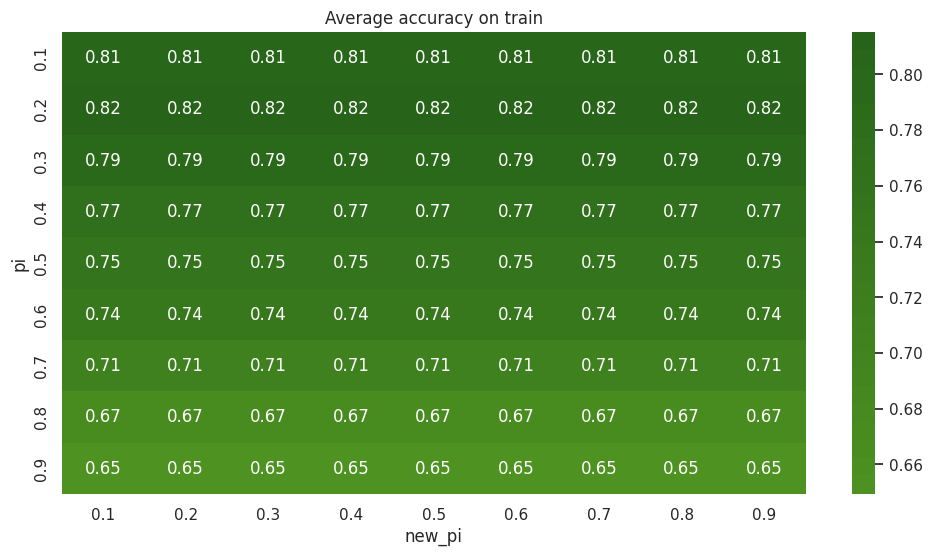

In [46]:
col = "avg_accuracy"

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy on train")
sns.heatmap(results_df_train.pivot(index="pi", columns="new_pi", values=col), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df_train[col]),
    vmax= max(results_df_train[col]),
    center=0)
plt.show()

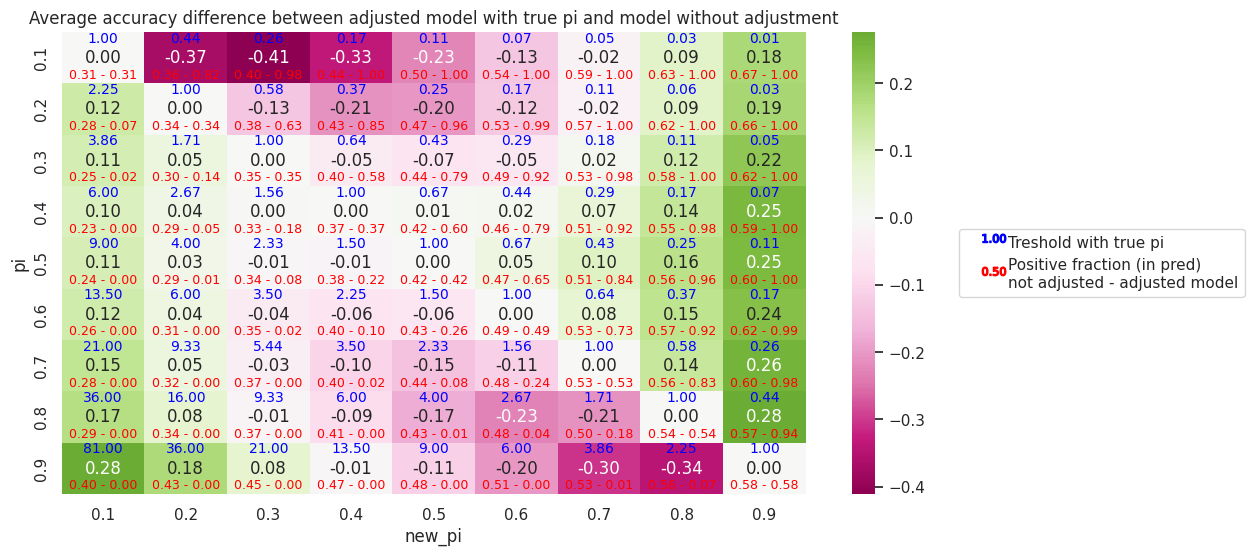

In [47]:
from matplotlib.text import TextPath

results_df["avg_true_accuracy_diff"] = results_df["avg_true_pi_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with true pi and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_true_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_true_accuracy_diff"]),
    vmax= max(results_df["avg_true_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with true pi")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (in pred)\nnot adjusted - adjusted model")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

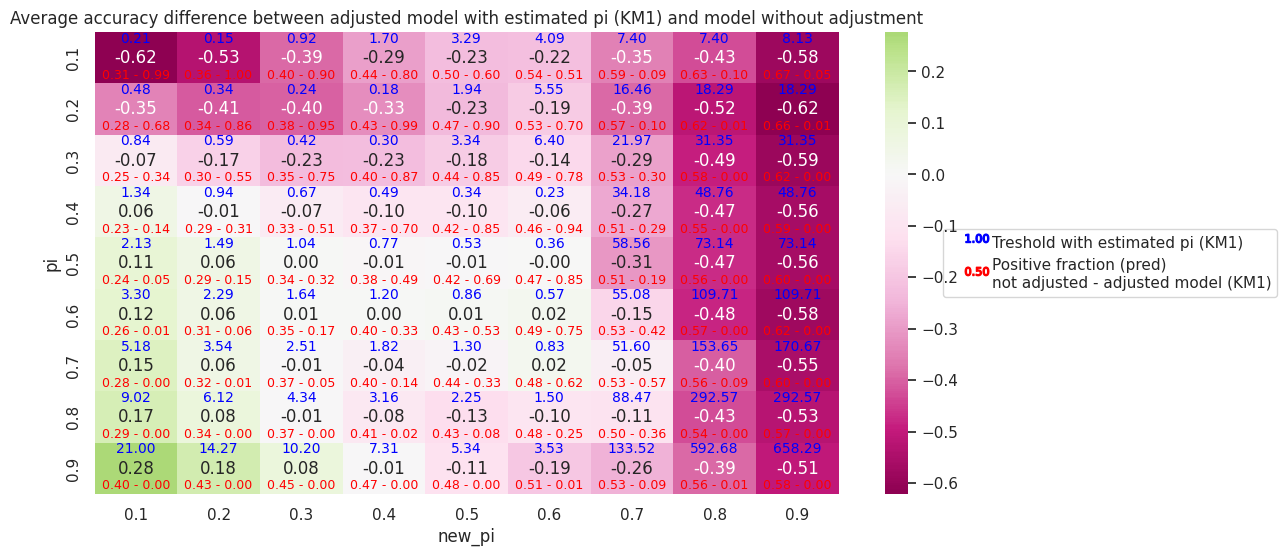

In [48]:
from matplotlib.text import TextPath

results_df["avg_km1_accuracy_diff"] = results_df["avg_km1_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with estimated pi (KM1) and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km1_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km1_accuracy_diff"]),
    vmax= max(results_df["avg_km1_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km1_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km1_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with estimated pi (KM1)")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (pred)\nnot adjusted - adjusted model (KM1)")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

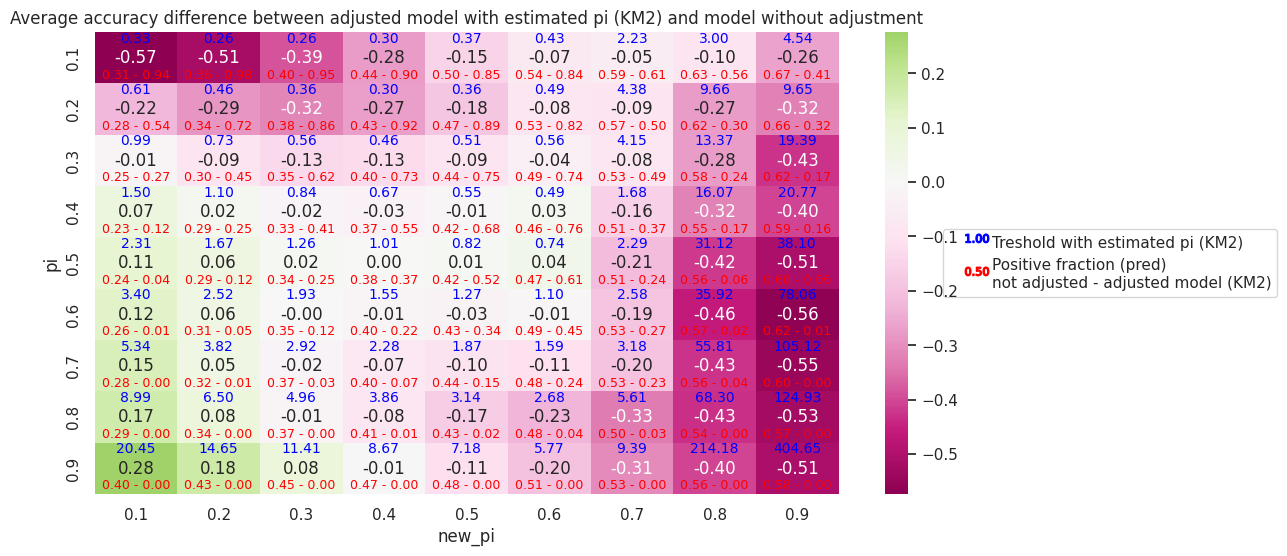

In [51]:
from matplotlib.text import TextPath

results_df["avg_km2_accuracy_diff"] = results_df["avg_km2_accuracy"] - results_df["avg_not_adjusted_accuracy"]

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with estimated pi (KM2) and model without adjustment")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km2_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km2_accuracy_diff"]),
    vmax= max(results_df["avg_km2_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km2_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_km2_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with estimated pi (KM2)")
positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (pred)\nnot adjusted - adjusted model (KM2)")
plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.show()

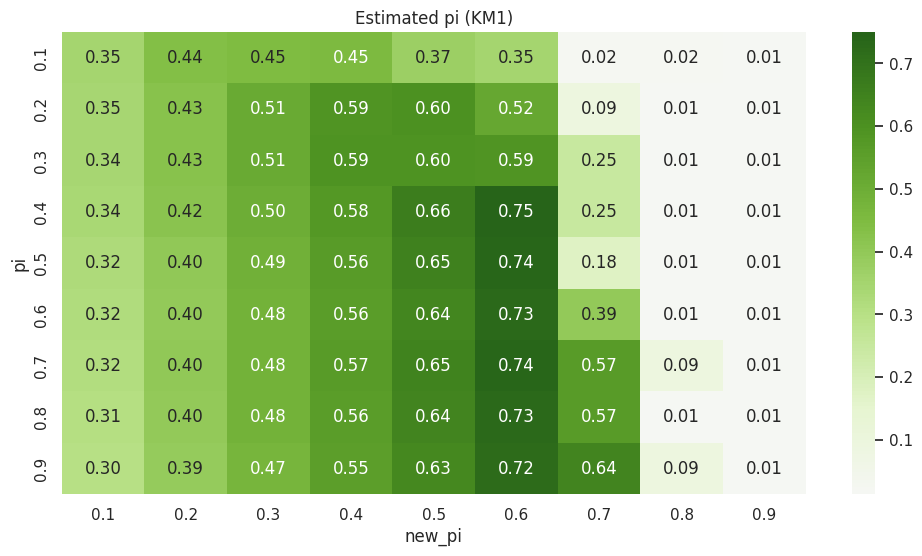

In [37]:
# plot histogram of the estimated pi (KM1) # MEAN=0.5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Estimated pi (KM1)")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km1_pi"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km1_pi"]),
    vmax= max(results_df["avg_km1_pi"]),
    center=0)
plt.show()

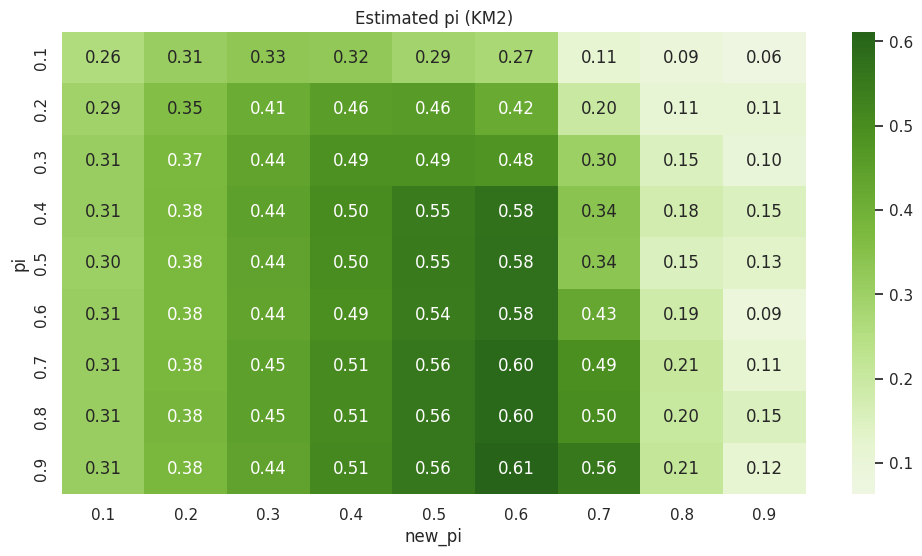

In [38]:
# plot histogram of the estimated pi (KM2) # MEAN=0.5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Estimated pi (KM2)")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_km2_pi"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_km2_pi"]),
    vmax= max(results_df["avg_km2_pi"]),
    center=0)
plt.show()